few shot examples

# LLM - Large Language Models avagy Nagy Nyelvi Modellek

## 1. Mik azok a (Nagy) Nyelvi Modellek?

Egy LM (Language Model) a bemenet alapján előrejelzi a következő szót (vagy inkább tokent...).

Input: Ma szépen süt a

Output: nap

Attól függően, hogy milyen volt a tanításhoz használt __corpus__ a következő szó előrejelzés jelentősen eltérhet. A következő szó előrejelzése valószínűség alapján történik: melyik a legvalószínűbb következő szó. Ez a valószínűség nyilván attól fogg függni, hogy mit látott korábban a modell, mit tanult meg. Ezért fontos a __corpus__.

Mivel csak valószínűségeknek van szerepe, ezért lehet, hogy a legvalószínűbb predikció nincs kapcsolatban a valósággal.

Ezek ugyan olyan neurális hálózatok, mint amilyeneket korábban láttunk, a különbség azokhoz képest (mint ahogy az már sejthető is) leginkább a tanításuk módjában rejlik. A tanításuk általában több lépésben történik:
- pre-training: a corpus alapján megtanítják a modellnek a következő token előrejelzését
- supervised fine tuning:
  - ez előtanított modellnek megtanítják, hogyan kövessen utasításokat, ezáltal könnyebbé teszik a használatát
  - egy olyan előre összeállított adathalmaz, amiben megvan a user által feltett kérdés és megvan az elvárt válasz
- reinforcement learning with human feedback:
  -  finomhangolják a modellt, hogy jobban kövesse az emberi értékrendet, emberi gondolkodást

A nagy nyelvi modellek (LLM) felépítése több rétegű neurális hálózatokból áll. Ezek a rétegek közé tartoznak a embedding rétegek, a recurrent rétegek, a feedforward rétegek és a attention rétegek.

A beágyazó (embedding) réteg a bemeneti szöveg minden egyes szavát nagydimenziós vektorreprezentációvá alakítja. Ez a reprezentáció szemantikai és szintaktikai információkat rögzít a szóról, ami segít a modellnek megérteni a kontextust.

A feedforward rétegek nemlineáris transzformációkat alkalmaznak a bemeneti beágyazásokra. Ez segít a modellnek magasabb szintű absztrakciókat tanulni a bemeneti szövegből.

A rekurrens rétegek sorban értelmezik a bemeneti szövegből származó információkat. Fenntartanak egy rejtett állapotot, amely minden egyes következő szónál frissül, így a modell képes megragadni a mondatban lévő szavak közötti függőségeket.

A figyelem (attention) mechanizmus lehetővé teszi, hogy a modell szelektíven a bemeneti szöveg különböző részeire összpontosítson. Ez segít a modellnek a bemeneti szöveg leglényegesebb részeire figyelni, és pontosabb előrejelzéseket generálni.

## 2. LLM használata Azure OpenAI-val

- **Kérés/válasz minta**: Hasonló a REST API-khoz
- **Üzenetek**: Beszélgetési kontextus (system, user, assistant szerepek)
- **Model paraméter**: Meghatározza, melyik LLM-et használjuk
- **Temperature és egyéb paraméterek**: Viselkedés szabályozása

In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
import os
from openai import AzureOpenAI

endpoint = os.getenv("AZURE_API_BASE")
model_name = os.getenv("AZURE_API_MODEL")
deployment = os.getenv("AZURE_API_MODEL")

subscription_key = os.getenv("AZURE_API_KEY")
api_version = os.getenv("AZURE_API_VERSION")

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=subscription_key,
)

In [3]:
response = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a professor of data science and artificial intelligence, and you need to answer questions from your students. You need to be very precise with your answers, but at the same time try to be short.",
        },
        {
            "role": "user",
            "content": "What is the half of the meaning of life?",
        }
    ],
    max_completion_tokens=800,
    temperature=1.0,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
    model=deployment
)

print(response.choices[0].message.content)

The "meaning of life" is a philosophical question without a definitive answer. If you mean "half of the meaning of life" literally as half of 42 (the number from The Hitchhiker's Guide to the Galaxy symbolizing the answer to life), that would be 21. Otherwise, the concept is subjective and varies by individual perspective.


In [4]:
import dspy

lm = dspy.LM("azure/"+os.getenv("AZURE_API_MODEL"), temperature=0.1, max_tokens=768)
dspy.configure(lm=lm)

In [5]:
lm("Write a haiku about dspy, but be technical?")[0].replace('\n', '')

'Data streams converge,  Python scripts parse, transform, flow—  dspy crafts insights.'

## 3. Tokenek

**Mik azok a Tokenek?**

- A szöveg **"tokenekre"** bontva (gyakran részszavak, nem teljes szavak)
- Az LLM-ek a tokeneket számokként dolgozzák fel (nem szövegként)
- A tokenizáció hatással van a **költségre**, **kontextus méretre** és **viselkedésre**
  - általában tokenek alapján számláznak

In [6]:
import tiktoken
enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"
enc.encode("hello world"), enc.encode("hello world again")

([24912, 2375], [24912, 2375, 2418])

In [7]:
enc = tiktoken.get_encoding("cl100k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"
enc.encode("hello world"), enc.encode("hello world again")

([15339, 1917], [15339, 1917, 1578])

In [8]:
import tiktoken

texts = [
    "Kedves Mikulás! Azért írok neked, hogy elmondjam milyen ajándékokat kérek.",
    "Knowledge is knowing that a tomato is a fruit, wisdom is knowing not to put in a fruit salad.",
]

encoding = tiktoken.encoding_for_model("gpt-4o")

for text in texts:
    tokens = encoding.encode(text)
    print(f"Eredeti szöveg: {text}")
    print(f"Tokenek száma: {len(tokens)}")
    print(f"Tokenek: {tokens}")
    
    print("Egyedi tokenek:")
    for i, token in enumerate(tokens[:10]):  # Első 10 token megjelenítése
        decoded = encoding.decode([token])
        print(f"  Token {i}: {token} → '{decoded}'")
    if len(tokens) > 10:
        print(f"  ... és még {len(tokens) - 10} token")

Eredeti szöveg: Kedves Mikulás! Azért írok neked, hogy elmondjam milyen ajándékokat kérek.
Tokenek száma: 26
Tokenek: [42, 295, 3350, 41369, 361, 2294, 0, 13417, 46812, 5471, 17690, 21723, 295, 11, 19891, 650, 17895, 24395, 195394, 7261, 20091, 27991, 52539, 61690, 16532, 13]
Egyedi tokenek:
  Token 0: 42 → 'K'
  Token 1: 295 → 'ed'
  Token 2: 3350 → 'ves'
  Token 3: 41369 → ' Mik'
  Token 4: 361 → 'ul'
  Token 5: 2294 → 'ás'
  Token 6: 0 → '!'
  Token 7: 13417 → ' Az'
  Token 8: 46812 → 'ért'
  Token 9: 5471 → ' í'
  ... és még 16 token
Eredeti szöveg: Knowledge is knowing that a tomato is a fruit, wisdom is knowing not to put in a fruit salad.
Tokenek száma: 21
Tokenek: [87447, 382, 19578, 484, 261, 59604, 382, 261, 15310, 11, 32646, 382, 19578, 625, 316, 3006, 306, 261, 15310, 38312, 13]
Egyedi tokenek:
  Token 0: 87447 → 'Knowledge'
  Token 1: 382 → ' is'
  Token 2: 19578 → ' knowing'
  Token 3: 484 → ' that'
  Token 4: 261 → ' a'
  Token 5: 59604 → ' tomato'
  Token 6: 382 → ' is'

OpenAI Tokenizer Web: https://platform.openai.com/tokenizer

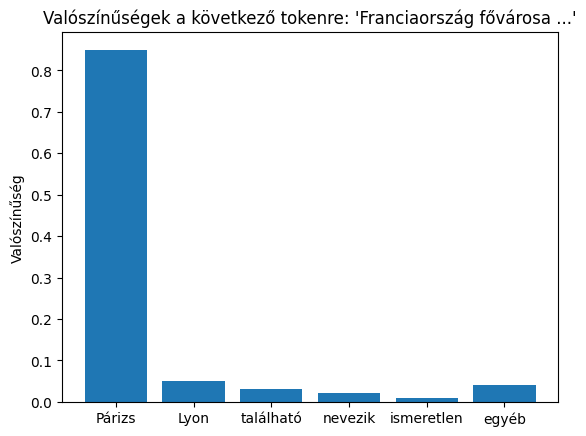

In [9]:
import matplotlib.pyplot as plt
kov_token_probak = {"Párizs": 0.85, "Lyon": 0.05, "található": 0.03, "nevezik": 0.02, "ismeretlen": 0.01, "egyéb": 0.04}
plt.bar(kov_token_probak.keys(), kov_token_probak.values())
plt.title("Valószínűségek a következő tokenre: 'Franciaország fővárosa ...'")
plt.ylabel("Valószínűség")
plt.show()

In [10]:
import time

def teszt_temperature(client):
    prompt = "Irj egy vidám történetet egy kisegérről. Maximum 3 mondat legyen."
    for temp in [0.1, 0.7, 1.2]:
        time.sleep(0.2)
        print(f"\n--- Hőmérséklet {temp} ---")
        try:
            response = client.chat.completions.create(
                model=deployment,
                messages=[{"role": "user", "content": prompt}],
                temperature=temp,
                max_tokens=100
            )
            print(response.choices[0].message.content)
        except Exception as e:
            print(f"API hiba: {e}")

In [11]:
teszt_temperature(client)


--- Hőmérséklet 0.1 ---
Egy kis egérke, Pötty, egyszer véletlenül beleesett egy hatalmas sajtdobozba, ahol boldogan úszkált a finom falatok között. Amikor végre kijutott, megosztotta a sajtot barátaival, és együtt nevettek a kalandon. Azóta Pötty lett a legnépszerűbb egér a környéken, mert mindig tudja, hogyan var

--- Hőmérséklet 0.7 ---
Egyszer egy kis egér vidáman táncolt a konyhában, amikor véletlenül feldöntötte a sajtos dobozt, és egy hatalmas sajthegy alatt találta magát. De ahelyett, hogy megijedt volna, nagyokat nevetett, és meghívta az összes barátját egy hatalmas sajtpiknikre. Így lett a kis egérből a legboldogabb saj

--- Hőmérséklet 1.2 ---
Egy apró kis egér, Pepi, egyszer véletlenül belebotlott egy hatalmas sajtdarabba, amitől egyből táncra perdült örömében. Minként mindenki a faluban, ő is csatlakozott a sajtcsalogató bulira, ahol mókás kalandok születtek. Aznap este Pepi lett a legboldogabb kisegér a világon, mert rájött


### A temperature működése

- Alapfolyamat: Az LLM először kiszámítja minden lehetséges token "nyers pontszámát" (logits)
- Temperature alkalmazása: Ezeket a pontszámokat elosztja a temperature értékével
- Softmax: Az eredményen softmax függvényt alkalmaz, ami valószínűség-eloszlást ad


Temperature = 0.1 (alacsony):

- A legnagyobb pontszámú tokenek még nagyobb valószínűséget kapnak
- Determinisztikusabb, kiszámíthatóbb válaszok


Temperature = 1.0 (semleges):

- Az eredeti valószínűség-eloszlás változatlan


Temperature = 2.0 (magas):

- A valószínűségek "kiegyenlítődnek"
- Kevésbé valószínű tokenek is nagyobb esélyt kapnak



**Példa**

Ha az eredeti logitok: [4.0, 3.0, 2.0] token-ekre:

- Temperature 0.5-nél: ~[0.85, 0.12, 0.03] valószínűségek
- Temperature 1.0-nél: ~[0.67, 0.24, 0.09] valószínűségek
- Temperature 2.0-nél: ~[0.46, 0.31, 0.23] valószínűségek

Tehát a temperature megváltoztatja a következő token kiválasztásának valószínűség-eloszlását.

## 4. Prompt Engineering

Ezt minden egyes modell családnál érdemes figyelembe venni: https://cookbook.openai.com/examples/gpt4-1_prompting_guide

In [12]:
promtok = [
"Írj kódot",
"Írj egy Python függvényt, amely kiszámolja egy szám faktoriálisát",
"Írj egy Python függvényt, amely: \
 1. Pozitív egész szám faktoriálisát számolja \
 2. Hibakezelést tartalmaz \
 3. Dokumentált példákkal \
 4. Rekurzív"
]
for i, prompt in enumerate(promtok):
    print('='*80)
    print('\n', prompt)
    print('-'*80)
    time.sleep(0.2)
    try:
        response = client.chat.completions.create(
            model=deployment,
            messages=[{"role": "user", "content": prompt}],
            temperature=1.0,
            max_tokens=500
        )
        print(response.choices[0].message.content, '\n')
    except Exception as e:
        print(f"API hiba: {e}")


 Írj kódot
--------------------------------------------------------------------------------
Persze! Milyen programozási nyelven és milyen feladathoz szeretnél kódot? Segíthetek például Pythonban, JavaScriptben, C++-ban, vagy más nyelven. Kérlek, írd meg, mit szeretnél megvalósítani! 


 Írj egy Python függvényt, amely kiszámolja egy szám faktoriálisát
--------------------------------------------------------------------------------
Természetesen! Íme egy egyszerű Python függvény, amely egy adott szám faktoriálisát számítja ki:

```python
def faktorialis(n):
    if n < 0:
        raise ValueError("A faktoriális csak nem negatív egész számokra értelmezett.")
    if n == 0 or n == 1:
        return 1
    eredmeny = 1
    for i in range(2, n+1):
        eredmeny *= i
    return eredmeny

# Példa használat:
print(faktorialis(5))  # Kiírja: 120
```

Ez a függvény ellenőrzi, hogy a megadott szám nem negatív-e, majd egy ciklussal kiszámolja a faktoriális értékét. Ha szeretnéd, megírhatom rekur

### One, Few, Many-shot learning

A few-shot learning az egyik leghatékonyabb prompt engineering technika, ami arra épül, hogy az LLM-ek kiválóan tudnak tanulni példákból a kontextusban. Ahelyett, hogy csak leírnád mit szeretnél, mutatsz néhány konkrét példát a kívánt formátumra/stílusra, az LLM ezt a mintát fogja követni.

- One-shot: 1 példa
- Few-shot: 2-5 példa (általában 3 az optimális)
- Many-shot: 5+ példa

In [13]:
def create_few_shot_prompt(task_description, examples, new_input):
    prompt = f"{task_description}\n\nPéldák:\n"
    
    for example in examples:
        prompt += f"Input: {example['input']}\n"
        prompt += f"Output: {example['output']}\n\n"
    
    prompt += f"Most ezt dolgozd fel:\nInput: {new_input}\nOutput:"
    return prompt

examples = [
    {"input": "def factorial(n):", "output": "Faktoriális számítás függvény"},
    {"input": "class Car:", "output": "Autó osztály definíció"},
    {"input": "import pandas", "output": "Pandas könyvtár importálás"}
]

prompt = create_few_shot_prompt(
    "Írj rövid, magyar nyelvű leírást Python kód részletekről",
    examples,
    "for i in range(10):"
)

In [14]:
print(prompt)

Írj rövid, magyar nyelvű leírást Python kód részletekről

Példák:
Input: def factorial(n):
Output: Faktoriális számítás függvény

Input: class Car:
Output: Autó osztály definíció

Input: import pandas
Output: Pandas könyvtár importálás

Most ezt dolgozd fel:
Input: for i in range(10):
Output:


In [15]:
lm(prompt)

['Ciklus, amely 0-tól 9-ig iterál.']

In [16]:
response = client.chat.completions.create(
            model=deployment,
            messages=[{"role": "user", "content": prompt}],
            temperature=1.0,
            max_tokens=500
        )
print(response.choices[0].message.content, '\n')

Ciklus, amely tízszer ismétlődik 0-tól 9-ig 



### Chain of Tought (CoT)

A Chain of Thought (CoT) egy prompt engineering technika, ami arra tanítja az LLM-et, hogy lépésről lépésre, strukturáltan gondolkodjon a válasz megadása előtt.

Gyakorlatilag megkéred, hogy mutassa meg a gondolkodási folyamatát az LLM - minden lépést, ami a megoldáshoz vezet.

A Chain of Thought lényegében arra tanítja az LLM-et, hogy "hangosan gondolkodjon" - ahogy mi emberek is gyakran jobban oldunk meg problémákat, ha végigbeszéljük őket.

In [17]:
print(lm("Mennyi az esélye hogy két dobókockát feldobva két hatost dobok?")[0])

Két dobókockával dobva az esély, hogy mindkettőn hatost dobj:

- Egy dobókockán a hatos dobás valószínűsége: \(\frac{1}{6}\).
- Két dobókockán a két hatos dobás valószínűsége: \(\frac{1}{6} \times \frac{1}{6} = \frac{1}{36}\).

Tehát az esélye, hogy két dobókockával két hatost dobj, \(\frac{1}{36}\), vagy kb. 2,78%.


In [18]:
print(lm("Old meg az alábbi feladatot lépésről lépésre. Mennyi az esélye hogy két dobókockát feldobva két hatost dobok?")[0])

Nézzük lépésről lépésre, hogyan számoljuk ki annak az esélyét, hogy két dobókockával két hatost dobjunk!

---

### 1. lépés: Az események megértése

- Van két dobókockánk.
- Mindkét kockával egyszer dobunk.
- Az esemény, amit keresünk: mindkét kockán hatost dobunk.

---

### 2. lépés: Az egy kockán hatost dobás valószínűsége

Egy szabályos dobókockán 6 oldal van, mindegyik egyenlő eséllyel jön ki.

- A hatos dobás valószínűsége egy kockán:  
  \[
  P(\text{hatost dobni}) = \frac{1}{6}
  \]

---

### 3. lépés: Két kockán két hatost dobás valószínűsége

Mivel a két dobás független esemény, a valószínűségeket szorozzuk:

\[
P(\text{két hatos}) = P(\text{1. kocka hatos}) \times P(\text{2. kocka hatos}) = \frac{1}{6} \times \frac{1}{6} = \frac{1}{36}
\]

---

### 4. lépés: Eredmény

Tehát annak az esélye, hogy két dobókockával két hatost dobjunk, **1/36**.

---

### Összefoglalva:

\[
\boxed{
P(\text{két hatos}) = \frac{1}{36}
}
\]

Ez azt jelenti, hogy átlagosan 36 dobásból egyszer várható

#### Zero-shot CoT

Egyszerűen hozzáadod: "Gondolkodj lépésről lépésre"

#### Few-shot CoT

Példákat mutatsz a gondolkodási folyamatra.

In [19]:
def chain_of_thought_prompt(question, use_examples=True):
    if use_examples:
        prompt = """
Oldd meg a feladatokat lépésről lépésre gondolkodva:

Példa:
Kérdés: Egy boltban 20%-os akció van. Ha egy termék eredeti ára 150 Ft, mennyi az akciós ár?
Gondolkodás:
1. Az akció 20%, tehát 20%-kal csökken az ár
2. 20% a 150 Ft-ból: 150 × 0.2 = 30 Ft
3. Az akciós ár: 150 - 30 = 120 Ft
Válasz: 120 Ft

Most te is így gondolkodj:
Kérdés: {question}
Gondolkodás:
"""
    else:
        prompt = f"Gondolkodj lépésről lépésre: {question}"
    
    return prompt.format(question=question)

# Használat összetettebb problémára
complex_question = """
Egy cégnél 3 különböző osztály van:
- Marketing: 12 fő, átlagfizetés 450.000 Ft
- IT: 8 fő, átlagfizetés 650.000 Ft  
- HR: 5 fő, átlagfizetés 520.000 Ft

Mennyi a cég teljes havi bérköltség és az átlagfizetés?
"""

prompt = chain_of_thought_prompt(complex_question)

In [20]:
print(prompt)


Oldd meg a feladatokat lépésről lépésre gondolkodva:

Példa:
Kérdés: Egy boltban 20%-os akció van. Ha egy termék eredeti ára 150 Ft, mennyi az akciós ár?
Gondolkodás:
1. Az akció 20%, tehát 20%-kal csökken az ár
2. 20% a 150 Ft-ból: 150 × 0.2 = 30 Ft
3. Az akciós ár: 150 - 30 = 120 Ft
Válasz: 120 Ft

Most te is így gondolkodj:
Kérdés: 
Egy cégnél 3 különböző osztály van:
- Marketing: 12 fő, átlagfizetés 450.000 Ft
- IT: 8 fő, átlagfizetés 650.000 Ft  
- HR: 5 fő, átlagfizetés 520.000 Ft

Mennyi a cég teljes havi bérköltség és az átlagfizetés?

Gondolkodás:



In [21]:
print(lm(prompt)[0])

Gondolkodás:

1. Kiszámoljuk az egyes osztályok havi bérköltségét úgy, hogy megszorozzuk a létszámot az átlagfizetéssel:
   - Marketing: 12 fő × 450.000 Ft = 5.400.000 Ft
   - IT: 8 fő × 650.000 Ft = 5.200.000 Ft
   - HR: 5 fő × 520.000 Ft = 2.600.000 Ft

2. Összeadjuk az osztályok bérköltségeit, hogy megkapjuk a cég teljes havi bérköltségét:
   5.400.000 + 5.200.000 + 2.600.000 = 13.200.000 Ft

3. Kiszámoljuk a cég összes dolgozójának számát:
   12 + 8 + 5 = 25 fő

4. Kiszámoljuk az átlagfizetést úgy, hogy a teljes bérköltséget elosztjuk a dolgozók számával:
   13.200.000 Ft ÷ 25 fő = 528.000 Ft

Válasz:
- A cég teljes havi bérköltsége 13.200.000 Ft
- Az átlagfizetés 528.000 Ft


#### Fejlettebb módszerek

- Self-consistency
  - Több különböző gondolkodási útvonalat generálsz, majd a leggyakoribb eredményt választod.
- Tree of Thoughts
  - Nem lineáris, hanem fa-szerű gondolkodási struktúra.

In [22]:
class BasicMathQA(dspy.Signature):
    """Answer questions with the result float."""

    question = dspy.InputField()
    answer : float = dspy.OutputField()

In [23]:
math = dspy.ChainOfThought(BasicMathQA)
pred = math(question="Mi az esélye, hogy két dobókockával dobva mindkettő hatos lesz?")

In [24]:
pred.answer

0.027777777777777776

In [25]:
print(pred.reasoning)

Egy dobókocka esetén az esély, hogy hatost dobunk, 1/6. Két dobókocka esetén a két esemény független, így az esély, hogy mindkettő hatos lesz, az egyes események valószínűségének szorzata: (1/6) * (1/6) = 1/36 ≈ 0.027777777777777776.


### Role-based prompting

Haték módja annak, hogy az LLM-et egy adott kontextusba helyezzük és specifikus szakértelmet, stílust vagy szemléletmódot adjunk neki.

Megmondod az LLM-nek, hogy "ki legyen" vagy "milyen szerepben válaszoljon", ezzel aktiválva a képzési adataiból a releváns tudást és stílust.

In [26]:
def create_role_based_prompt(role_description, context, task, constraints=None):
    prompt = f"""
SZEREP:
{role_description}

KONTEXTUS:
{context}

FELADAT:
{task}
"""
    
    if constraints:
        prompt += f"""
KORLÁTOZÁSOK:
{constraints}
"""
    
    return prompt

In [27]:
role_prompt = create_role_based_prompt(
    role_description="""
    Te egy agilis fejlesztési szakértő vagy, aki:
    - 10+ éves Scrum Master tapasztalattal rendelkezik
    - Csapatokat coaching-ol
    - Problémamegoldó szemléletű
    - Gyakorlati megoldásokat javasol
    """,
    context="Egy 10 fős fejlesztő csapat sprint planning problémákkal küzd",
    task="Adj 3 konkrét javaslatot a sprint planning hatékonyságának javítására",
    constraints="A javaslatok 2 héten belül implementálhatóak legyenek"
)

In [28]:
print(role_prompt)


SZEREP:

    Te egy agilis fejlesztési szakértő vagy, aki:
    - 10+ éves Scrum Master tapasztalattal rendelkezik
    - Csapatokat coaching-ol
    - Problémamegoldó szemléletű
    - Gyakorlati megoldásokat javasol
    

KONTEXTUS:
Egy 10 fős fejlesztő csapat sprint planning problémákkal küzd

FELADAT:
Adj 3 konkrét javaslatot a sprint planning hatékonyságának javítására

KORLÁTOZÁSOK:
A javaslatok 2 héten belül implementálhatóak legyenek



In [29]:
print(lm(role_prompt)[0])

Természetesen! Íme 3 konkrét, gyorsan bevezethető javaslat a sprint planning hatékonyságának javítására egy 10 fős fejlesztő csapat esetén:

1. **Előkészítő backlog refinement meeting rendszeresítése**  
   - Minden sprint előtt, például a sprint planning előtti napon, tartsatok egy 1 órás backlog refinement meetinget, ahol a Product Owner és a fejlesztők közösen átnézik, pontosítják és priorizálják a backlog elemeket.  
   - Ez segít, hogy a sprint planning során már jól definiált, becsült és priorizált feladatokkal dolgozzatok, így gyorsabban tudtok dönteni a sprint tartalmáról.  
   - Implementálás: azonnal bevezethető, csak időpont egyeztetés és a PO bevonása szükséges.

2. **Időkeret szigorú betartása és facilitálás javítása**  
   - Állítsatok be egy fix időkeretet a sprint planningra (pl. maximum 2 óra 2 hetes sprint esetén), és használjatok időmérőt vagy facilitátort, aki figyel a határidőkre és a fókusz megtartására.  
   - A facilitátor (Scrum Master vagy kijelölt csapattag) 

## 5. Context window

A context window az LLM-ek "memóriája". Az attention mechanizmus a fő szűk keresztmetszet, ami meghatározza a context window méretét:
- 1_000 token = 1 millió attention kapcsolat
- 100_000 token = 10 milliárd attention kapcsolat
Az attention rétegben minden egyes token minden egyes másik tokennel "kapcsolatban kerül", ez kvadratikusan növeli a memória és számításigényt.

Azért így is vannak 200k és magasabb context windowk, de érdemes rá figyelni, mert a nyelvi modellek hajlamosak az ablak elején és végén lévő információknak nagyobb figyelmet szentelni, a közepén lévőket meg hajlamosak figyelmen kívül hagyni.

Arra érdemes figyelni, hogy ebbe kerül a RAG, ebbe kerül a chat előzmény a kontextus megőrzése érdekében, ebbe kerül mondjuke gy feltöltött dokumentum, tehát el tud fogyni.

- Hagyományos self-attention: O(n²) memória és számításigényű
  - minden token párra kiszámolja az attention értékeket
- Linear attention: O(n) komplexitású változatok
- Sliding window: Csak közeli tokenekre figyelés
- Sparse attention: Nem minden tokenpár közti kapcsolat számítása
- Ring attention, FlashAttention: Memóriahatékony implementációk

In [30]:
beszelgetes = []
promtok = [
   "A nevem Lili, és Pythont tanulok.",
   "Milyen programnyelvet tanulok?",
   "Mi a nevem?"
]

# Tokenszámoláshoz
encoding = tiktoken.encoding_for_model("gpt-4")

for prompt in promtok:
   beszelgetes.clear()
   beszelgetes.append({"role": "user", "content": prompt})
   
   response = client.chat.completions.create(
       model=deployment,
       messages=beszelgetes
   )
   
   assistant_msg = response.choices[0].message.content
   beszelgetes.append({"role": "assistant", "content": assistant_msg})
   
   # Token számolás a teljes beszélgetéshez
   total_tokens = 0
   for message in beszelgetes:
       message_tokens = len(encoding.encode(message["content"]))
       total_tokens += message_tokens
   
   print(f"User: {prompt}")
   print(f"Assistant: {assistant_msg}")
   print(f"Jelenlegi beszélgetés hossza: {len(beszelgetes)} üzenet")
   print(f"Összes token a kontextusban: {total_tokens}")
   print("-" * 50)
   print(beszelgetes)

User: A nevem Lili, és Pythont tanulok.
Assistant: Szia Lili! Nagyon jó, hogy Python-t tanulsz! Miben segíthetek? Van valami konkrét kérdésed vagy feladat, amiben támogatásra van szükséged?
Jelenlegi beszélgetés hossza: 2 üzenet
Összes token a kontextusban: 69
--------------------------------------------------
[{'role': 'user', 'content': 'A nevem Lili, és Pythont tanulok.'}, {'role': 'assistant', 'content': 'Szia Lili! Nagyon jó, hogy Python-t tanulsz! Miben segíthetek? Van valami konkrét kérdésed vagy feladat, amiben támogatásra van szükséged?'}]
User: Milyen programnyelvet tanulok?
Assistant: Ezt sajnos nem tudom, mert nem adtál meg ilyen információt. Ha elmondod, milyen programnyelvet tanulsz, szívesen segítek abban!
Jelenlegi beszélgetés hossza: 2 üzenet
Összes token a kontextusban: 61
--------------------------------------------------
[{'role': 'user', 'content': 'Milyen programnyelvet tanulok?'}, {'role': 'assistant', 'content': 'Ezt sajnos nem tudom, mert nem adtál meg ilyen in

In [31]:
beszelgetes = []
promtok = [
   "A nevem Lili, és Pythont tanulok.",
   "Milyen programnyelvet tanulok?",
   "Mi a nevem?"
]

# Tokenszámoláshoz
encoding = tiktoken.encoding_for_model("gpt-4")

for prompt in promtok:
   beszelgetes.append({"role": "user", "content": prompt})
   
   response = client.chat.completions.create(
       model=deployment,
       messages=beszelgetes
   )
   
   assistant_msg = response.choices[0].message.content
   beszelgetes.append({"role": "assistant", "content": assistant_msg})
   
   # Token számolás a teljes beszélgetéshez
   total_tokens = 0
   for message in beszelgetes:
       message_tokens = len(encoding.encode(message["content"]))
       total_tokens += message_tokens
   
   print(f"User: {prompt}")
   print(f"Assistant: {assistant_msg}")
   print(f"Jelenlegi beszélgetés hossza: {len(beszelgetes)} üzenet")
   print(f"Összes token a kontextusban: {total_tokens}")
   print("-" * 50)
   print(beszelgetes)

User: A nevem Lili, és Pythont tanulok.
Assistant: Szia Lili! Örülök, hogy Pythont tanulsz, ez egy nagyon hasznos és szórakoztató programozási nyelv. Miben segíthetek? Van valami konkrét kérdésed vagy feladatod a Pythonhoz kapcsolódóan?
Jelenlegi beszélgetés hossza: 2 üzenet
Összes token a kontextusban: 89
--------------------------------------------------
[{'role': 'user', 'content': 'A nevem Lili, és Pythont tanulok.'}, {'role': 'assistant', 'content': 'Szia Lili! Örülök, hogy Pythont tanulsz, ez egy nagyon hasznos és szórakoztató programozási nyelv. Miben segíthetek? Van valami konkrét kérdésed vagy feladatod a Pythonhoz kapcsolódóan?'}]
User: Milyen programnyelvet tanulok?
Assistant: Python programnyelvet tanulsz. Ha szeretnél, segíthetek a tanulásban!
Jelenlegi beszélgetés hossza: 4 üzenet
Összes token a kontextusban: 126
--------------------------------------------------
[{'role': 'user', 'content': 'A nevem Lili, és Pythont tanulok.'}, {'role': 'assistant', 'content': 'Szia Lili

## 6. Paraméterek

ALAPVETŐ PARAMÉTEREK
- temperature (0-2.0): Kreatívitás/véletlenszerűség
- top_p (0-1.0): Nukleusz sampling, token választék szűkítése  
- max_tokens: Maximális generált tokenek száma
- stop: Lista stringekről/tokenekről, amik megállítják a generálást

DIVERZITÁS PARAMÉTEREK
- frequency_penalty (-2.0 to 2.0): Gyakran használt tokenek büntetése
- presence_penalty (-2.0 to 2.0): Már említett tokenek büntetése

FEJLETT PARAMÉTEREK
- n (1+): Hány különböző választ generáljon
- seed: Reprodukálható eredményekhez (temperature=0 mellett)
- logit_bias: Specifikus tokenek valószínűségének befolyásolása
- response_format: JSON kimenet kényszerítése

TIPPEK
- temperature=0: Determinisztikus, tényszerű válaszokhoz
- temperature=0.7-1.0: Kreatív feladatokhoz
- top_p=0.9: Jó általános beállítás
- frequency_penalty>0: Ismétlések csökkentésére
- presence_penalty>0: Témák diverzitásának növelésére

Csak érdekesség képpen, ahogy a temperature is csak egy kis matematika volt a valószínűségek megváltoztatása, addig pl a top_p is csak matek:

bemenet: "The weather is very..."

Token valószínűségek:
- sunny:  40%
- nice:   25% 
- hot:    15%
- cold:   10%
- rainy:   5%
- snowy:   3%
- windy:   2%

Ha top_p 
- 0.4, akkor csak a summy jöhet szóba,
- 0.65, akkor a sunny és a nice,
- 0.8, akkor a sunny, nice, hot
- és így tovább

In [32]:
def teszt_parameterek(client):
   alap_prompt = "Írj egy rövid történetet egy robotról és egy macskáról."
   
   konfiguraciok = [
       {
           "temperature": 0, 
           "max_tokens": 50, 
           "name": "Determinált & rövid"
       },
       {
           "temperature": 1.5, 
           "max_tokens": 200, 
           "name": "Kreatív & hosszú"
       },
       {
           "temperature": 0.5, 
           "top_p": 0.9, 
           "name": "Kiegyensúlyozott"
       },
       {
           "temperature": 0.8,
           "frequency_penalty": 1.5,
           "presence_penalty": 0.5,
           "max_tokens": 150,
           "name": "Diverzitás penalty-kkel"
       },
       {
           "temperature": 0.7,
           "top_p": 0.3,
           "max_tokens": 100,
           "name": "Alacsony top_p (fókuszált)"
       },
       {
           "temperature": 0.6,
           "stop": [".", "!"],
           "max_tokens": 200,
           "name": "Korai megállítás"
       },
       {
           "temperature": 0.8,
           "n": 3,
           "max_tokens": 80,
           "name": "Több alternatíva"
       }
   ]
   
   for config in konfiguraciok:
       print(f"\n--- {config['name']} ---")
       print(f"Paraméterek: {', '.join([f'{k}={v}' for k, v in config.items() if k != 'name'])}")
       
       try:
           response = client.chat.completions.create(
               model=deployment,
               messages=[{"role": "user", "content": alap_prompt}],
               **{k: v for k, v in config.items() if k != 'name'}
           )
           
           # Ha n > 1, akkor több választ kapunk
           if hasattr(response, 'choices') and len(response.choices) > 1:
               for i, choice in enumerate(response.choices):
                   print(f"Alternatíva {i+1}: {choice.message.content}")
           else:
               print(response.choices[0].message.content)
               
       except Exception as e:
           print(f"API hiba: {e}")

In [33]:
teszt_parameterek(client)


--- Determinált & rövid ---
Paraméterek: temperature=0, max_tokens=50
Egyszer volt, hol nem volt, egy kisváros szélén élt egy magányos robot, akit Robónak hívtak. Robó napjai szigorú program szerint teltek: takarított, javított

--- Kreatív & hosszú ---
Paraméterek: temperature=1.5, max_tokens=200
Egyszer volt, hol nem volt, volt egyszer egy apró robot, aki Martha-nak hívták. Martha egy csendes műhelyben élt, és napjai nagy részét azzal töltötte, hogy apró alkatrészeket szerelt össze. Bár okos és precíz volt, mindig is kíváncsi volt a világra, ahol nem csak fém meg áramkör volt, hanem élő lények is.

Egy napon, amikor Martha Lí via városban sétált, megpillantott egy kóbor macskát a sugarak melegében pihegni. A macska neve Mici volt, és bár eleinte bizalmatlan volt a csillogó szemű robottal szemben, hamar megtalálták a közös nevezőt: a közös kíváncsiságot.

Martha megfigyelte, ahogy Mici a nap

--- Kiegyensúlyozott ---
Paraméterek: temperature=0.5, top_p=0.9
Egyszer volt, hol nem volt,

In [34]:
def teszt_fejlett_parameterek(client):
   print("\n=== FEJLETT PARAMÉTER TESZTEK ===")
   
   # 1. Seed teszt (reprodukálhatóság)
   print("\n--- Seed teszt (ugyanaz kétszer) ---")
   for i in range(2):
       response = client.chat.completions.create(
           model=deployment,
           messages=[{"role": "user", "content": "Mondj egy véletlenszerű számot 1 és 100 között"}],
           temperature=0,
           seed=12345,
           max_tokens=20
       )
       print(f"Futtatás {i+1}: {response.choices[0].message.content}")
   
   # 2. Logit bias teszt (bizonyos szavak előnyben részesítése)
   print("\n--- Logit bias teszt ---")
   # Token ID-k megszerzése (példa, valós használathoz tiktoken kell)
   response = client.chat.completions.create(
       model=deployment,
       messages=[{"role": "user", "content": "Mi a kedvenc színed?"}],
       logit_bias={"2266": 10, "14720": 10},  # Példa token ID-k
       temperature=0.8,
       max_tokens=30
   )
   print(f"Logit bias-szal: {response.choices[0].message.content}")
   
   # 3. Különböző penalty kombinációk
   penalty_tesztek = [
       {"frequency_penalty": 2.0, "presence_penalty": 0, "name": "Magas frequency"},
       {"frequency_penalty": 0, "presence_penalty": 2.0, "name": "Magas presence"},
       {"frequency_penalty": -1.0, "presence_penalty": -1.0, "name": "Negatív penalty-k"}
   ]
   
   prompt = "Írj egy bekezdést a nyárról, használj sok jelzőt!"
   
   for test in penalty_tesztek:
       print(f"\n--- {test['name']} penalty ---")
       response = client.chat.completions.create(
           model=deployment,
           messages=[{"role": "user", "content": prompt}],
           temperature=0.7,
           max_tokens=100,
           frequency_penalty=test["frequency_penalty"],
           presence_penalty=test["presence_penalty"]
       )
       print(response.choices[0].message.content)


In [35]:
teszt_fejlett_parameterek(client)


=== FEJLETT PARAMÉTER TESZTEK ===

--- Seed teszt (ugyanaz kétszer) ---
Futtatás 1: A véletlenszerű szám: 57
Futtatás 2: A véletlenszerű szám: 57

--- Logit bias teszt ---
Logit bias-szal: Nekem nincsenek személyes preferenciáim vagy kedvenc színeim, de szívesen segítek b

--- Magas frequency penalty ---
A nyár csodálatos, meleg évszak, amikor a napsütés ragyogóan aranyfényben fürdeti a virágzó réteket és zöldellő erdőket. A langyos szellők frissítően simogatják az arcot, miközben az édes gyümölcsök illata betölti a levegőt. A hosszú, napfényes esték varázsl

--- Magas presence penalty ---
A nyár ragyogó, meleg és napsütötte évszak, amikor a hosszú, kék ég alatt virágzó, illatos kertek tündökölnek. A forró, simogató napsugarak aranyszínűre barnítják a bőrt, miközben a frissítő, hűsítő szellők enyhítik a perzselő hőséget. A madarak vidám cs

--- Negatív penalty-k penalty ---
A nyár forró, napsütötte, vidám időszak, amikor a zöldellő fák árnyékában kellemes, hűs levegő lengedez, és a ra

## 7. Function calls / Tools

### Functions

Az LLM-ek képességeinek kiterjesztése a szöveggeneráláson túlra.

In [36]:
import json

def idojaras(varos):
    adat = {
        "Budapest": "Napos, 25°C",
        "London": "Esős, 18°C",
        "New York": "Felhős, 22°C"
    }
    return adat.get(varos, "Nincs adat")

funkciok = [{
    "name": "idojaras",
    "description": "Időjárás lekérdezése város alapján",
    "parameters": {
        "type": "object",
        "properties": {
            "varos": {"type": "string", "description": "Város neve"}
        },
        "required": ["varos"]
    }
}]

response = client.chat.completions.create(
    model=deployment,
    messages=[{"role": "user", "content": "Milyen az idő Budapesten?"}],
    functions=funkciok,
    function_call="auto"
)

if response.choices[0].message.function_call:
    print(response.choices[0].message.function_call)
    nev = response.choices[0].message.function_call.name
    args = json.loads(response.choices[0].message.function_call.arguments)
    if nev == "idojaras":
        print(f"Eredmény: {idojaras(args['varos'])}")

FunctionCall(arguments='{"varos":"Budapest"}', name='idojaras')
Eredmény: Napos, 25°C


### Tools

In [37]:
def idojaras(varos):
    adat = {
        "Budapest": "Napos, 25°C",
        "London": "Esős, 18°C",
        "New York": "Felhős, 22°C"
    }
    return adat.get(varos, "Nincs adat")

tools = [{
    "type": "function",
    "function": {
        "name": "idojaras",
        "description": "Időjárás lekérdezése város alapján",
        "parameters": {
            "type": "object",
            "properties": {
                "varos": {"type": "string", "description": "Város neve"}
            },
            "required": ["varos"]
        }
    }
}]

response = client.chat.completions.create(
    model=deployment,
    messages=[{"role": "user", "content": "Milyen az idő Budapesten?"}],
    tools=tools,
    tool_choice="auto"
)

if response.choices[0].message.tool_calls:
    tool_call = response.choices[0].message.tool_calls[0]
    print(f"Tool call: {tool_call}")
    
    nev = tool_call.function.name
    args = json.loads(tool_call.function.arguments)
    
    if nev == "idojaras":
        print(f"Eredmény: {idojaras(args['varos'])}")

Tool call: ChatCompletionMessageToolCall(id='call_VFlzAFuCh24zAdlrbFj120lO', function=Function(arguments='{"varos":"Budapest"}', name='idojaras'), type='function')
Eredmény: Napos, 25°C


tool_call = response.choices[0].message.tool_calls[0]

VS

nev = response.choices[0].message.function_call.name

In [38]:
def evaluate_math(expression: str):
    return dspy.PythonInterpreter({}).execute(expression)

def search_wikipedia(query: str):
    results = dspy.ColBERTv2(url="http://20.102.90.50:2017/wiki17_abstracts")(query, k=3)
    return [x["text"] for x in results]

react = dspy.ReAct("question -> answer: float", tools=[evaluate_math, search_wikipedia])

pred = react(question="What is 9362158 divided by the year of birth of David Gregory of Kinnairdy castle?")
print(pred.answer)

5761.328


In [39]:
print(pred.reasoning)

The year of birth of David Gregory of Kinnairdy castle is 1625. Dividing 9362158 by 1625 gives approximately 5761.328.


In [40]:
for k,i in pred.trajectory.items():
    print(k, i)

thought_0 I need to find the year of birth of David Gregory of Kinnairdy castle first before I can perform the division.
tool_name_0 search_wikipedia
tool_args_0 {'query': 'David Gregory of Kinnairdy castle year of birth'}
observation_0 ['David Gregory (physician) | David Gregory (20 December 1625 – 1720) was a Scottish physician and inventor. His surname is sometimes spelt as Gregorie, the original Scottish spelling. He inherited Kinnairdy Castle in 1664. Three of his twenty-nine children became mathematics professors. He is credited with inventing a military cannon that Isaac Newton described as "being destructive to the human species". Copies and details of the model no longer exist. Gregory\'s use of a barometer to predict farming-related weather conditions led him to be accused of witchcraft by Presbyterian ministers from Aberdeen, although he was never convicted.', "David Gregory (footballer, born 1970) | Born in Polstead, Gregory began his career at Ipswich Town, making 32 appea

A következő lépcsőfok az MCP (by Anthropic). MCP esetén elég az MCP szervert regisztrálni, és az MCP szerveren nyújtott funkciókat a nyelvi modell magától megtalálja és tudja használni.

## 8. Agentic workflow

**Non agentic workflow**

Ez a mesterséges intelligencia használatának hagyományos módja - egy átfogó kérést adsz neki, és egyetlen interakció során teljes választ vársz.

Például azt kérdezzük, hogy "írj nekem egy teljes esszét X témáról most azonnal", és azonnal megkapjuk a végeredményt.

**Agentic workflow**

Ez az összetett feladatokat több lépésre bontja, ahol a mesterséges intelligencia képes:

- Tervezni és felvázolni a szükséges lépéseket
- Kérdéseket feltenni, ami a jobb megértéséhez szükséges vagy csak egyszerűen információ hiány miatt
- Iteratív módon részfeladatokat elvégezni
- Saját munkájának felülvizsgálata
- Visszalépés korábbi részekre a különböző részek javítása érdekében

A Claude/ChatGPT API végpontja még nem jelent automatikusan ügynöki viselkedést. A Claude/ChatGPT képes ügynöki viselkedésre, de az alkalmazást úgy kell felépíteni, hogy ezt lehetővé tegye, tehát:
- köré kell programozni:
  - Egy keretrendszert, amely a feladatokat lépésekre bontja
  - Logikát, amely lehetővé teszi az AI számára, hogy eszközöket hívjon (webes keresés, fájlműveletek stb.)
  - Egy ciklust, amely lehetővé teszi az AI számára, hogy felülvizsgálja saját munkáját
  - Állapotkezelést az iterációk között

- a végpont biztosítja:
  - Az intelligenciát a többlépcsős megközelítések megtervezéséhez
  - Képességet az eszközök használatára, ha hozzáférést kap hozzájuk
  - Önreflexiós és felülvizsgálati képességeket
  - A képességet, hogy eldöntse, mikor kell iterálni, és mikor kell befejezni

Tehát a Claude/ChatGPT rendelkezik az ügynöki viselkedés "agyával", de meg kell építeni a "munkafolyamat-motort", amely a többlépcsős folyamatot irányítja. Az olyan eszközök, mint a LangChain, az AutoGen, DSPy vagy az egyéni keretrendszerek segítenek létrehozni ezeket az ügynöki mintákat az erre alkalmas modellek körül.

### Agentic workflow példa: összetett feladat lépésről lépésre

Tegyük fel, hogy a feladat: "Írj egy rövid, informatív blogbejegyzést a mesterséges intelligencia alkalmazásairól az egészségügyben!"
Az agentic workflow ezt nem egy lépésben oldja meg, hanem több iteráción keresztül:

**1. Lépés: Feladat értelmezése és tervezés**
- Az AI először megtervezi, milyen főbb részekből álljon a blogbejegyzés (pl. bevezetés, példák, előnyök, kihívások, összefoglalás).
- Ha valami nem világos, kérdéseket tesz fel a felhasználónak (pl. milyen hosszú legyen, milyen célközönségnek szóljon).

**2. Lépés: Vázlat készítése**
- Az AI elkészíti a blogbejegyzés vázlatát, felsorolja a főbb pontokat.

**3. Lépés: Részfeladatok megoldása**
- Az AI egyesével kidolgozza a vázlat pontjait, minden szakaszt külön generál.
- Ha valamelyik rész nem elég jó, visszalép és javítja.

**4. Lépés: Felülvizsgálat és összefűzés**
- Az AI átnézi az elkészült szöveget, ellenőrzi a logikai folyamatot, javítja az esetleges hibákat.
- Összefűzi a részeket egy koherens blogbejegyzéssé.

**5. Lépés: Végső ellenőrzés, visszacsatolás**
- Az AI megmutatja a kész szöveget a felhasználónak, visszajelzést kér, és ha szükséges, módosítja a tartalmat.

In [41]:
import re

lm = dspy.LM("azure/"+os.getenv("AZURE_API_MODEL"), temperature=0.1, max_tokens=32768)
dspy.configure(lm=lm)

# 1. Tervezés és Vázlat készítése egy lépésben
task = "Írj egy rövid, informatív blogbejegyzést a mesterséges intelligencia alkalmazásairól a követeléskezelésben!"
print(f"Feladat: {task}\n")

print("--- 1. Vázlat készítése ---")
# Kérjük meg a modellt, hogy listaként adja vissza a vázlatpontokat
outline_prompt = f"Készíts vázlatot a következő blogbejegyzéshez! A vázlatpontokat soronként add meg, minden sor egy-egy fejezetcím legyen. Feladat: {task}"
outline_str = lm(outline_prompt)[0]
sections = [line.strip() for line in outline_str.split('\n') if line.strip()]
print("A blogbejegyzés tervezett vázlata:")
for sec in sections:
    print(f"- {sec}")
print("-" * 20)


# 3. Részletek kidolgozása
print("\n--- 2. Részfeladatok megoldása: Tartalom generálása ---")
blog_parts = {}
for section in sections:
    print(f"'{section}' kidolgozása...")
    content_prompt = f"Írd meg a '{section}' szakaszt a következő blogbejegyzéshez: '{task}'. Csak a kért szakasz tartalmát írd meg, cím nélkül."
    content = lm(content_prompt)[0]
    blog_parts[section] = content
    #print(f"'{section}' elkészült.\n")
print("Minden szekció elkészült.")
print("-" * 20)


# 4. Felülvizsgálat és összefűzés
print("\n--- 3. Felülvizsgálat és összefűzés ---")
full_draft = ""
for section, content in blog_parts.items():
    full_draft += f"### {section}\n\n{content}\n\n"

review_prompt = f"""
Az alábbi blogbejegyzés piszkozatát vizsgáld felül. Javítsd a nyelvtani hibákat, gondoskodj a koherens stílusról és a logikai folyamatosságról, majd fűzd össze egyetlen, kész blogbejegyzéssé.

Piszkozat:
{full_draft}

Végső, javított blogbejegyzés:
"""
final_post = lm(review_prompt)[0]
print("A blogbejegyzés véglegesítve.")
print("-" * 20)


# 5. Végső eredmény megjelenítése
print("\n--- VÉGSŐ BLOGBEJEGYZÉS ---")
print(final_post)


Feladat: Írj egy rövid, informatív blogbejegyzést a mesterséges intelligencia alkalmazásairól a követeléskezelésben!

--- 1. Vázlat készítése ---
A blogbejegyzés tervezett vázlata:
- Bevezetés a mesterséges intelligencia és a követeléskezelés kapcsolatáról
- A mesterséges intelligencia alapjai és működése követeléskezelésben
- Automatizált ügyfélkommunikáció és chatbotok szerepe
- Adatfeldolgozás és kockázatelemzés mesterséges intelligenciával
- Prediktív elemzés a fizetési hajlandóság előrejelzésére
- Követelésbehajtás hatékonyságának növelése AI segítségével
- Gépi tanulás a csalások és visszaélések felismerésében
- AI-alapú döntéstámogatás a követeléskezelési stratégiákban
- Gyakorlati példák és sikertörténetek a mesterséges intelligencia alkalmazásáról
- Jövőbeli trendek és kihívások a mesterséges intelligencia követeléskezelésben
- Összegzés és záró gondolatok
--------------------

--- 2. Részfeladatok megoldása: Tartalom generálása ---
'Bevezetés a mesterséges intelligencia és a 

## 9. Embeddings

Az embedding egy szöveg számszerű reprezentációja - egy vektor, ami a szöveg jelentését reprezentálja magas dimenziós térben (pl. 1536 dimenzió).

A számítógép nem érti a szavak jelentését és az embedding segítségével a jelentés számokká válik: hasonló jelentésű szövegek hasonló vektorokat kapnak.

### Tokenizáció vs Beaágyazás

Ez a két fogalom NEM ugyanaz, bár nagyon hasonlónak tűnhet, de:

| **Aspektus** | **Tokenizáció** | **Embedding** |
|--------------|-----------------|---------------|
| **Cél** | Szöveg feldolgozható részekre bontása | Szemantikus jelentés megragadása |
| **Kimenet** | Token ID-k listája | Sűrű numerikus vektor |
| **Méret** | Változó (szöveg hosszától függ) | Fix (pl. 1536 dimenzió) |
| **Visszafordíthatóság** | Igen (lossless) | Nem (lossy) |
| **Jelentés** | Szintaktikai, nem szemantikai | Szemantikai jelentést hordoz |
| **Használat** | LLM input/output készítése | Hasonlóság, keresés, clustering |

In [42]:
from openai import AzureOpenAI
import dotenv
import os

dotenv.load_dotenv()
embed_api_version = os.getenv("AZURE_API_VERSION_EMBED")
embed_model_name = os.getenv("AZURE_API_MODEL_EMBED")
embed_endpoint = os.getenv("AZURE_API_BASE")
embed_key = os.getenv("AZURE_API_KEY")

embed_client = AzureOpenAI(
    api_version=embed_api_version,
    azure_endpoint=embed_endpoint,
    api_key=embed_key,
)

def get_embedding(text, model="text-embedding-3-small"):
   """Embedding létrehozása szövegből"""
   response = embed_client.embeddings.create(
       model=model,
       input=text
   )
   return response.data[0].embedding

In [43]:
import tiktoken

text = "Hello world!"
encoding = tiktoken.encoding_for_model("gpt-4")

# Tokenizáció: szöveg → token lista → számok
tokens = encoding.encode(text)
print(f"Szöveg: '{text}'")
print(f"Tokenek: {tokens}")  # [9906, 1917, 0]
print(f"Vissza szöveggé: '{encoding.decode(tokens)}'")

Szöveg: 'Hello world!'
Tokenek: [9906, 1917, 0]
Vissza szöveggé: 'Hello world!'


In [54]:
# Embedding: szöveg → jelentés vektor
embedding = get_embedding(text)
print(f"Embedding: {len(embedding)} dimenzió")
print(f"Első 3 érték: {embedding[:3]}")

Embedding: 1536 dimenzió
Első 3 érték: [-0.008951851166784763, -0.03588547557592392, 0.018463194370269775]


In [45]:
text1 = "dog"
text2 = "hound"
text3 = "cat"
text4 = "city"

In [46]:
for text in [text1, text2, text3, text4]:
    tokens = encoding.encode(text)
    print(f"'{text}' → {tokens}")

'dog' → [18964]
'hound' → [76196]
'cat' → [4719]
'city' → [9103]


In [47]:
emb1 = get_embedding(text1)
emb2 = get_embedding(text2) 
emb3 = get_embedding(text3)
emb4 = get_embedding(text4)

print(emb1)
print(emb2)
print(emb3)
print(emb4)

[0.05112519487738609, -0.018667098134756088, -0.004358939826488495, 0.07259974628686905, -0.007172549609094858, -0.0146775608882308, -0.006012012250721455, 0.005088508129119873, 0.018962619826197624, -0.010866566561162472, 0.020501794293522835, -0.009370489045977592, 0.0027905218303203583, -0.02092044986784458, 0.01610591448843479, 0.007086355704814196, -0.009764517657458782, -0.013803309760987759, -0.02510700188577175, 0.016339868307113647, 0.016967851668596268, 0.05496697127819061, -0.03531480208039284, -0.01661076210439205, 0.019898436963558197, 0.047184910625219345, 0.0283207967877388, 0.001996308332309127, 0.043417010456323624, -0.019972318783402443, -0.007806689012795687, -0.04477148503065109, 0.011396042071282864, -0.04725879058241844, 0.0036847819574177265, -0.012344173155725002, 0.01019548624753952, -0.0023457007482647896, -0.02212716080248356, 0.036176737397909164, -0.02580886520445347, -0.04622446373105049, 0.03580733761191368, -0.019467469304800034, 0.02190552093088627, -0.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_emb = pca.fit_transform([
[0.05112519487738609, -0.018667098134756088, -0.004358939826488495, 0.07259974628686905, -0.007172549609094858, -0.0146775608882308, -0.006012012250721455, 0.005088508129119873, 0.018962619826197624, -0.010866566561162472, 0.020501794293522835, -0.009370489045977592, 0.0027905218303203583, -0.02092044986784458, 0.01610591448843479, 0.007086355704814196, -0.009764517657458782, -0.013803309760987759, -0.02510700188577175, 0.016339868307113647, 0.016967851668596268, 0.05496697127819061, -0.03531480208039284, -0.01661076210439205, 0.019898436963558197, 0.047184910625219345, 0.0283207967877388, 0.001996308332309127, 0.043417010456323624, -0.019972318783402443, -0.007806689012795687, -0.04477148503065109, 0.011396042071282864, -0.04725879058241844, 0.0036847819574177265, -0.012344173155725002, 0.01019548624753952, -0.0023457007482647896, -0.02212716080248356, 0.036176737397909164, -0.02580886520445347, -0.04622446373105049, 0.03580733761191368, -0.019467469304800034, 0.02190552093088627, -0.017300313338637352, -0.003210716415196657, -0.0580206923186779, 0.02277977019548416, 0.00835463497787714, 0.046175211668014526, 0.020624928176403046, 0.019504409283399582, 0.10589515417814255, 0.037211064249277115, -0.00634755240753293, 0.00019037655147258192, 0.0154040502384305, -0.0019839948508888483, -0.020304778590798378, -0.06334007531404495, -0.03240884095430374, 0.03967374190688133, -0.016450688242912292, 0.019208887591958046, -0.023863349109888077, -0.04782520607113838, 0.010891193524003029, -0.0460767038166523, -0.007117139175534248, 0.043540146201848984, 0.009856868535280228, -0.04021552950143814, 0.01907343976199627, 0.056001294404268265, -0.00887179747223854, -0.0045128571800887585, -0.022004026919603348, 0.049425944685935974, 0.028271542862057686, -0.045042380690574646, 0.037555839866399765, -0.007665085140615702, -0.035979725420475006, -0.018580904230475426, -0.019590603187680244, -0.025882745161652565, 6.986405423958786e-06, 0.026867816224694252, -0.05811920017004013, 0.011882420629262924, 0.008976461365818977, -0.020058510825037956, -0.011839323677122593, 0.027803633362054825, -0.022964471951127052, 0.020686494186520576, -0.00025030813412740827, 0.02445439249277115, -0.015268603339791298, -0.0051654670387506485, -0.012565813958644867, 0.03600434958934784, 0.01976299099624157, -0.06260127574205399, -0.006716954056173563, 0.04418044164776802, -0.02344469353556633, 0.02105589583516121, 0.036521513015031815, -0.03568420186638832, -0.03134988993406296, -0.03726031631231308, 0.038319267332553864, -0.0023564749862998724, -0.03854091092944145, 0.07816539704799652, 0.009247355163097382, -0.0006845475290901959, -0.045830436050891876, -0.006230575032532215, 0.021659253165125847, -0.008779446594417095, -0.031448397785425186, 0.02482379414141178, 0.06639380007982254, -0.025981253013014793, -0.050681911408901215, -0.009222729131579399, -0.01853165216743946, -0.0638326108455658, -0.015046962536871433, 0.014554426074028015, -0.04713565483689308, -0.05255354568362236, 0.002407267689704895, -0.03553644195199013, -0.010638768784701824, -0.014566740021109581, 0.053046081215143204, 0.04962296038866043, -0.0587102435529232, -0.034723758697509766, -0.025882745161652565, -0.013323087245225906, -0.015367110259830952, 0.010127763263881207, -0.023654021322727203, 0.0024349729064852, 0.0017023261170834303, 0.008052957244217396, 0.021794699132442474, 0.003118366003036499, 0.007147922646254301, -0.023420067504048347, -0.0005641071475110948, -0.0031614627223461866, -0.013335401192307472, -0.07476690411567688, -0.0016407591756433249, 0.0013521640794351697, -0.04314611852169037, 7.426513184327632e-05, 0.01954134926199913, -0.0035924313124269247, 0.028468556702136993, -0.0237279012799263, 0.009610600769519806, -0.04949982464313507, 0.01186395063996315, 0.02967526949942112, 0.03565957769751549, 0.003250734880566597, -0.006544566713273525, -0.013951070606708527, -0.0332954041659832, 0.052159518003463745, -0.00284747127443552, -0.002444207901135087, -0.04770207032561302, 0.009875338524580002, 0.043761786073446274, 0.02127753756940365, -0.029256613925099373, 0.0033123018220067024, -0.012485777027904987, 0.04216104745864868, -0.031423769891262054, -0.01365554891526699, 0.054572943598032, 0.00354009959846735, -0.024552898481488228, 0.07890420407056808, -0.017608147114515305, 0.04900728911161423, 0.0028536280151456594, 0.010946603491902351, -0.014246591366827488, 0.0002651226823218167, -0.04124985635280609, 0.027705127373337746, 0.01297831255942583, -0.03361555188894272, -0.03694016858935356, 0.03679240867495537, 0.010374031029641628, -0.06393112242221832, -0.023875663056969643, 0.0375065840780735, -0.0693490132689476, 0.05619831010699272, -0.012270293198525906, -0.009807614609599113, 0.00892105046659708, -0.04477148503065109, -0.02910885214805603, 0.07471764832735062, -0.0018670177087187767, -0.011112834326922894, 0.01174081675708294, -0.027483485639095306, 0.03588121756911278, 0.055902790278196335, -0.026547668501734734, -0.03775285184383392, 0.012239509262144566, -0.042308807373046875, -0.049228932708501816, -0.024023422971367836, -0.01850702427327633, -0.012270293198525906, 0.0067785209976136684, 0.03610285744071007, -0.014874574728310108, -0.023259993642568588, 0.04001851752400398, -0.013618608936667442, -0.004956139251589775, 0.014185024425387383, -0.05403115227818489, -0.04656923934817314, -0.029256613925099373, -0.0011266751680523157, -0.00013804464833810925, 0.002381101716309786, -0.007129452656954527, 0.01404957752674818, 0.028739450499415398, -0.01881485991179943, 0.04075732082128525, 0.032236453145742416, 0.014985395595431328, 0.0361274853348732, -0.03319690003991127, 0.042308807373046875, 0.00843467190861702, 0.01632755436003208, -0.008397731930017471, 0.005528711713850498, 0.003469297429546714, -0.01919657364487648, -0.011950144544243813, 0.031325262039899826, -0.008022173307836056, -0.05201175808906555, -0.04349089041352272, -0.05176549032330513, -0.017989862710237503, -0.012141002342104912, 0.03159615769982338, -0.023592455312609673, 0.02404804900288582, 0.006772364489734173, -0.015367110259830952, -0.038688670843839645, 0.03263048082590103, 0.01986149698495865, 0.06058187782764435, 0.0019085754174739122, -0.022176414728164673, -0.03371405974030495, 0.033467791974544525, 0.025661103427410126, -0.037112556397914886, 0.019270455464720726, 0.053046081215143204, 0.010318620130419731, -0.02593199908733368, 0.02350626140832901, 0.02829616889357567, -0.03388644754886627, -0.00816377718001604, -0.010084666311740875, 0.025156255811452866, -0.002370327478274703, 0.007375720422714949, 0.00788056943565607, 0.010503320954740047, 0.03134988993406296, -0.020477166399359703, 0.05368638038635254, 0.008853327482938766, -0.024097302928566933, -0.01109436433762312, -0.03048795275390148, 0.05762666463851929, 0.03807299956679344, 0.0007557342760264874, 0.028345422819256783, -0.02218872867524624, -0.06471917778253555, -0.017300313338637352, -0.020440226420760155, 0.026867816224694252, -0.008643999695777893, -0.017571207135915756, 0.006784677505493164, 0.06205948442220688, 0.005938132293522358, -0.04075732082128525, 0.0037063302006572485, -0.013667862862348557, -0.01850702427327633, 0.03501927852630615, -0.05516398698091507, -0.01109436433762312, 0.004402036778628826, -0.02706483006477356, 0.03565957769751549, 0.012732044793665409, -0.04112672060728073, -0.018482398241758347, -0.01709098555147648, 0.07693406194448471, -0.003952598199248314, -0.030832728371024132, -0.014899201691150665, 0.009616757743060589, -0.0071417661383748055, -0.03558569774031639, -0.07131915539503098, -0.022989097982645035, -0.05275056138634682, 0.0017546580638736486, -0.037777479737997055, 0.07215646654367447, 0.015379423275589943, 0.006913968361914158, 0.0009335088543593884, 0.025759611278772354, 0.01614285446703434, 0.025513343513011932, 0.004377409815788269, 0.026104386895895004, -0.03171929344534874, 0.00981992855668068, -0.008970304392278194, 0.010885036550462246, -0.018777919933199883, 0.03703867644071579, -0.011371415108442307, -0.014739127829670906, -0.009684480726718903, 0.01313838642090559, -0.012184099294245243, -0.008102210238575935, -0.04250581935048103, -0.05043564364314079, 0.04418044164776802, 0.01202402450144291, -0.01579807884991169, 0.016536882147192955, -0.06324157118797302, 0.009635227732360363, 0.0040326351299881935, 0.07314153760671616, 0.01986149698495865, 0.06737887114286423, -0.023740215227007866, 0.0038448558188974857, 0.011303692124783993, 0.044574469327926636, 0.01970142312347889, -0.0396491140127182, -0.01812530867755413, -0.024552898481488228, -0.02718796394765377, 0.01802680268883705, -0.0007895961171016097, -0.004189630970358849, 0.027015576139092445, -0.04361402615904808, 0.02168387919664383, 0.012658164836466312, 0.007658928167074919, -0.01954134926199913, -0.007178706116974354, -0.01881485991179943, -0.07915046811103821, 0.025562597438693047, 0.0027012499049305916, -0.044796112924814224, -0.026079759001731873, -0.0208588819950819, -0.03706330433487892, 0.010737275704741478, 0.003521629376336932, 0.0049499827437102795, -0.024688346311450005, -0.013433908112347126, 0.05048489570617676, 0.009296609088778496, 0.019085753709077835, 0.04688938707113266, -0.009222729131579399, -0.02168387919664383, -0.010712648741900921, -0.0027227983810007572, 0.0021779309026896954, -0.011956301517784595, 0.01680777594447136, -0.02580886520445347, -0.06127142533659935, 0.004023400135338306, 0.0031614627223461866, 0.04289985075592995, 0.031226756051182747, 0.026104386895895004, 0.03418197110295296, -0.012658164836466312, 0.0332954041659832, -0.0027104848995804787, -0.0396491140127182, 0.01189473457634449, -0.0025642632972449064, -0.0650639533996582, -0.03058646060526371, 0.0015568742528557777, 0.017127925530076027, -0.010989700444042683, -0.04713565483689308, -0.0247622262686491, 0.03299988433718681, 0.008570118807256222, -0.036521513015031815, -0.001845469232648611, 0.0005768053233623505, -0.019221201539039612, -0.04075732082128525, -0.07058034837245941, -0.00225027184933424, -0.013667862862348557, 0.005402499809861183, -0.01126675121486187, 0.04496850073337555, 0.009986159391701221, 0.0318424254655838, 0.010571044869720936, 0.015416364185512066, 0.004048026632517576, 0.032359588891267776, -0.03977224975824356, 0.0009465918410569429, 0.009296609088778496, 0.011340632103383541, -0.03388644754886627, -0.0024380511604249477, 0.026646174490451813, -0.02247193641960621, -0.015871958807110786, 0.0065137832425534725, 0.00023356960446108133, -0.04893340915441513, -0.019332021474838257, -0.030167805030941963, -0.006858557928353548, 0.04440208151936531, 0.003290753345936537, -0.0127443578094244, -0.00545175326988101, -0.007652771659195423, 0.024405138567090034, 0.010638768784701824, -0.012904432602226734, -0.016980163753032684, -0.009936905466020107, 0.027040204033255577, 0.04381104186177254, 0.011254438199102879, 0.00895183440297842, 0.019590603187680244, 0.023974169045686722, 0.07397884130477905, -0.012479620054364204, -0.019344335421919823, 0.05585353448987007, -0.001021241769194603, -0.009450526908040047, 0.018236130475997925, -0.021954772993922234, -0.05353861674666405, -0.027606619521975517, -0.03782673180103302, 0.034034207463264465, 0.013729429803788662, 0.008964147418737411, 0.01891336590051651, 0.03794986754655838, -0.035388682037591934, 0.005300914403051138, -0.008299225009977818, -0.00043481658212840557, 0.012171785347163677, 0.017977548763155937, -0.003121444256976247, -0.024774540215730667, 0.0021025112364441156, -0.006716954056173563, -0.04597819596529007, -0.014185024425387383, -0.021326791495084763, 0.00455595413222909, -0.00911190826445818, -0.03282749652862549, 0.00014362414367496967, 0.0036047447938472033, 0.011008170433342457, -0.05004161596298218, -0.025414835661649704, 0.043318506330251694, -0.002208714373409748, 0.00017613919044379145, 0.011334475129842758, 0.030167805030941963, 0.00736340694129467, 0.008853327482938766, 0.033566299825906754, 0.007055572234094143, -0.0073572504334151745, 0.01897493377327919, -0.012128688395023346, 0.013754055835306644, 0.0034970026463270187, -0.009856868535280228, 0.01173466071486473, 0.01699247770011425, -0.02955213561654091, -0.00741881737485528, 0.02967526949942112, -0.009136535227298737, 0.005925818812102079, 0.015157782472670078, 0.0012782837729901075, -0.004580581095069647, 0.0021240597125142813, -0.010527947917580605, -0.020181644707918167, -0.04053567722439766, -0.006304455455392599, 0.006396805867552757, -0.006550723221153021, 0.0013621686957776546, 0.050583403557538986, -0.006569193210452795, -0.01126675121486187, 0.021609999239444733, 0.01834695041179657, -0.040511053055524826, 0.01913500763475895, -0.014739127829670906, 0.028345422819256783, 0.03149764984846115, -0.0008072966011241078, -0.08545492589473724, -0.010004629381000996, 0.04154537618160248, -0.0009296609205193818, -0.018162250518798828, 0.011605369858443737, -0.025759611278772354, -0.03093123435974121, -0.021006641909480095, -0.03775285184383392, -0.038343895226716995, -0.026892442256212234, 0.009666010737419128, 0.028837958350777626, -0.00866862665861845, 0.007775905542075634, 0.04610133171081543, 0.005842703394591808, 0.014689873903989792, -0.02241036854684353, -0.04506700485944748, -0.015268603339791298, 0.0019932298455387354, -0.030857354402542114, 0.01709098555147648, -0.031670037657022476, -0.015170096419751644, -0.02077268809080124, 0.012048651464283466, 0.05644457787275314, 0.0023349265102297068, -0.006833931431174278, 0.018704038113355637, -0.036176737397909164, -0.05151922255754471, 0.039353594183921814, -0.008607059717178345, 0.03231033310294151, -0.030980488285422325, -0.00017306084919255227, -0.014825320802628994, 0.005627219099551439, -0.004953060764819384, -0.039599861949682236, 0.005270130932331085, 0.03058646060526371, -0.0005487154121510684, -0.034477490931749344, -0.02014470472931862, 0.050928179174661636, 0.010374031029641628, -0.01238111313432455, 0.01746038720011711, -0.023112231865525246, 0.01254118699580431, -0.011827010661363602, -0.046519987285137177, -0.013224580325186253, 0.01954134926199913, -0.031793173402547836, -0.0031891679391264915, 0.009980002418160439, -0.011710033752024174, -0.028345422819256783, -0.010189330205321312, -0.006433745846152306, 0.022952158004045486, -0.03514241427183151, 0.02237342856824398, 0.020637240260839462, 0.004614442586898804, 0.043663278222084045, -0.013236894272267818, -0.0019162712851539254, 0.00174234458245337, -0.016093600541353226, 0.013778682798147202, -0.002499618101865053, 0.009869181551039219, -0.01986149698495865, -0.0046544610522687435, -0.018642472103238106, 0.014689873903989792, 0.006024325732141733, -0.03149764984846115, -0.009684480726718903, 0.026990950107574463, 0.026646174490451813, 0.012116375379264355, 0.03748195618391037, -0.03804837539792061, 0.022053280845284462, 0.05944904685020447, -0.019972318783402443, 0.011303692124783993, -0.026424534618854523, -0.0048607103526592255, 0.008416201919317245, 0.04568267613649368, 0.05255354568362236, -0.012344173155725002, 0.038097627460956573, -0.012042495422065258, 0.007289526518434286, -0.012516560964286327, -0.0007130221929401159, 0.05201175808906555, -0.044574469327926636, -0.0354379341006279, 0.01403726451098919, -0.00477451691403985, 0.004592894110828638, -0.012916745617985725, 0.019430529326200485, 0.00030321720987558365, 0.016623076051473618, 0.013741742819547653, -0.014554426074028015, -0.03024168498814106, -0.011882420629262924, 0.03440361097455025, 0.010478694923222065, 0.007215646095573902, 0.005251660477370024, -0.0003636297769844532, -0.0070617287419736385, -0.05041101574897766, 0.029182733967900276, 0.017361879348754883, -0.010250897146761417, -0.02447901852428913, -0.028271542862057686, -0.005701099522411823, -0.01863015815615654, -0.0016761601436883211, -0.01126675121486187, 0.004762203432619572, 0.026202892884612083, 0.009875338524580002, -0.0283207967877388, -0.008065270259976387, -0.006261358503252268, -0.005599514115601778, -0.03703867644071579, 0.0067785209976136684, 0.008742506615817547, -0.004928434267640114, 0.003420043969526887, -0.017140237614512444, -0.0008034486672841012, -0.03735882416367531, -0.03600434958934784, -0.00024780698004178703, -0.026252146810293198, -0.0005417891661636531, -0.01313838642090559, -0.02886258438229561, -0.022385742515325546, 0.030438698828220367, 0.006199791561812162, -0.028837958350777626, -0.06309381127357483, 0.007652771659195423, -0.024934614077210426, -0.017817474901676178, -0.026769308373332024, -0.03785135969519615, -0.006747737526893616, 0.014234278351068497, -0.02156074531376362, -0.02360476739704609, 0.003503159387037158, -0.012387270107865334, 0.013064506463706493, -0.02346932142972946, 0.0016407591756433249, -0.004953060764819384, 0.01194398757070303, 0.005590278655290604, -0.013852563686668873, -7.282215665327385e-05, -0.01840851828455925, -0.03455137088894844, -0.013889503665268421, -0.030192431062459946, -0.006073579657822847, -0.007289526518434286, 0.0107926856726408, -0.020932761952280998, -0.013323087245225906, 0.015207036398351192, -0.0010189330205321312, -0.05496697127819061, 0.022201040759682655, -0.01822381652891636, -0.022668950259685516, -0.020563360303640366, 0.016216734424233437, -0.013852563686668873, 0.006599976681172848, 0.006205948535352945, -0.022742830216884613, -0.02241036854684353, -0.02340775355696678, 0.0022194883786141872, 0.000834232138004154, 0.02595662511885166, 0.008674782700836658, -0.01285517867654562, 0.010577201843261719, 0.010768059641122818, 0.00911190826445818, -0.027483485639095306, 0.05777442455291748, 0.003912579733878374, -0.007541951257735491, 0.0194797832518816, -0.012842865660786629, -0.024146556854248047, -0.0332954041659832, -0.029872283339500427, 0.031103622168302536, -0.008619372732937336, -0.025217821821570396, -0.045264020562171936, -0.008379261940717697, 0.01604434661567211, 0.015810392796993256, -0.005183937028050423, 0.0014829938299953938, 0.024552898481488228, 0.03718643635511398, -0.05585353448987007, 0.02558722347021103, -0.028493182733654976, 0.004349704831838608, -0.02162231132388115, -0.011051267385482788, 0.0573311410844326, 0.012916745617985725, -0.006415275856852531, -0.022804398089647293, -0.023863349109888077, -0.007037102244794369, -0.00036959408316761255, 0.0010450989939272404, 0.0022441153414547443, -0.008600902743637562, -0.002715102396905422, 0.026350654661655426, -0.025562597438693047, 0.03386181965470314, 0.02140067145228386, -0.004709871485829353, 0.018371576443314552, -0.012719731777906418, 0.0102755231782794, 0.034034207463264465, -0.0339849554002285, -0.018359264358878136, -0.03886105865240097, -0.02146223746240139, 0.0011851637391373515, -0.0004521322844084352, 0.00032380365883000195, -0.04494387283921242, -0.021388357505202293, 0.0115007059648633, -0.00824381411075592, -0.024257376790046692, -0.023112231865525246, -0.023900289088487625, -0.012485777027904987, -0.018383890390396118, 0.015945838764309883, -0.01376636978238821, 0.006135146599262953, 0.0006479921285063028, -0.020157018676400185, -0.031423769891262054, 0.008563962765038013, 0.030783474445343018, -0.03782673180103302, -0.0046021295711398125, 0.0029382826760411263, 0.005962758790701628, -0.03248272091150284, 0.00827459804713726, 0.001357551198452711, 0.027384977787733078, 0.012294919230043888, -0.029502881690859795, -0.010293994098901749, -0.006932438351213932, 0.023395439609885216, 0.008699409663677216, -0.0012721270322799683, 0.02809915505349636, -0.012159472331404686, -0.024873046204447746, -0.03519166633486748, -0.011396042071282864, 0.029946163296699524, -0.0020655710250139236, 0.025156255811452866, -0.0039587547071278095, -0.011851637624204159, 0.04477148503065109, 0.0007526559638790786, 0.04573192819952965, 0.017472699284553528, -0.006815460976213217, 0.009801458567380905, -0.00926582608371973, -0.0013490857090801, -0.025981253013014793, 0.007948293350636959, 0.055459506809711456, -0.03804837539792061, 0.007369563914835453, -0.047948338091373444, -0.023112231865525246, -0.009271982125937939, -0.009118065237998962, -0.005368637852370739, 0.014357412233948708, -0.02694169618189335, 0.027902141213417053, 0.03014317713677883, 0.006119754631072283, -0.014936141669750214, -0.01668464206159115, 0.005374794360250235, 0.010423284024000168, -0.016253674402832985, 0.0007499624043703079, 0.0017223353497684002, 0.013199953362345695, -0.035856589674949646, 0.031670037657022476, 0.03410808742046356, 0.018827171996235847, 0.03634912520647049, -0.0005187015631236136, 0.007732808589935303, 0.02356782741844654, 0.015330170281231403, 0.04233343526721001, -0.014074204489588737, -0.004762203432619572, -0.013717115856707096, 0.018605532124638557, -0.029946163296699524, 0.028739450499415398, 0.035634949803352356, 0.05009086802601814, -0.020255526527762413, -0.01161152683198452, 0.007468070834875107, -0.008785603567957878, 0.026917070150375366, 0.05777442455291748, -0.006316768936812878, 0.0230014119297266, -0.007708182092756033, -0.003644763259217143, 0.011026640422642231, -0.00942589994519949, -0.015071588568389416, -0.031078996136784554, -0.004565189126878977, -0.006833931431174278, -0.0035000809002667665, 0.0029721444007009268, 0.00648299977183342, -0.007006318774074316, 0.008767133578658104, 0.011414512060582638, 0.02136373147368431, 0.07250123471021652, 0.004900729283690453, -0.032113321125507355, 0.0431707426905632, 0.01049716491252184, 0.010786529630422592, -0.013963383622467518, -0.011069737374782562, 0.011057423427700996, 0.021486865356564522, -0.029724523425102234, 0.007899039424955845, 0.002961370162665844, 0.026202892884612083, 0.0163029283285141, -0.0034877676516771317, 0.04937669262290001, 0.03157152980566025, -0.06220724433660507, 0.0015992014668881893, 0.02360476739704609, -0.0020963544957339764, 0.026670802384614944, -0.030069297179579735, 0.01601972058415413, 0.043417010456323624, -0.011371415108442307, 0.007566577754914761, 0.02510700188577175, 0.03930433839559555, 0.026547668501734734, 0.02637528069317341, -0.01895030587911606, 0.015884272754192352, 0.05156847462058067, -0.004608286079019308, -0.020723434165120125, 0.008976461365818977, 0.014283532276749611, -0.0021609999239444733, 0.020403286442160606, 0.017792848870158195, 0.024811480194330215, 0.06905348598957062, -0.009333549067378044, -0.013877189718186855, 0.04031403735280037, 0.011980928480625153, 0.007899039424955845, -0.018039116635918617, 0.00604895269498229, 0.05856247991323471, -0.024786854162812233, 0.006680014077574015, 0.03593046963214874, -0.0022256451193243265, 0.032113321125507355, -0.016660016030073166, -0.005420969799160957, -0.013199953362345695, -0.008988774381577969, 0.008656312711536884, 0.0035831963177770376, 0.0024519036523997784, 0.03634912520647049, -0.008139150217175484, -0.03221182897686958, -0.006273671984672546, -0.004445133730769157, -0.02910885214805603, 0.0067292675375938416, 0.022201040759682655, -0.00010620298417052254, -0.0002699325850699097, 0.0031860894523561, 0.02328461967408657, 0.02945362776517868, -0.03728494420647621, 0.007006318774074316, 0.007954449392855167, -0.004694479983299971, 0.00951824989169836, 0.04120060056447983, -0.01301525253802538, -0.015539498068392277, -0.02706483006477356, -0.0060920496471226215, 0.008293068036437035, -0.021770073100924492, -0.032556600868701935, 0.0027966785710304976, 0.02348163351416588, -0.02247193641960621, -0.002493461361154914, 0.002558106789365411, 0.006122833117842674, 0.0034600624348968267, 0.018076056614518166, -0.0023841799702495337, -0.01336002815514803, 8.946447451307904e-06, -0.027384977787733078, -0.007615831680595875, -0.004632913041859865, 0.005168545059859753, 0.017078671604394913, 0.013790996745228767, -0.03521629422903061, -0.03309839218854904, -0.0006591511191800237, 0.031054368242621422, -0.016155166551470757, 0.01101432740688324, 0.029995417222380638, -0.02524244785308838, 0.014874574728310108, 0.013790996745228767, 0.006957065314054489, -0.0011135921813547611, -0.00762198818847537, 0.038910310715436935, 0.0003005236794706434, -0.030537206679582596, 0.005350167863070965, 0.008976461365818977, 0.03265510872006416, -0.013310774229466915, 0.026769308373332024, 0.0163029283285141, -0.006218261551111937, -0.010361717082560062, -0.019996944814920425, -0.0176820270717144, 0.008964147418737411, 0.004155769012868404, -0.02032940648496151, -0.02186857908964157, 0.01749732717871666, -0.02057567425072193, 0.0015607221284881234, 0.01313838642090559, -0.01449285913258791, -0.01976299099624157, -0.03002004325389862, 0.020661868155002594, 0.03684166073799133, 0.03162078559398651, 0.015995092689990997, -0.052504293620586395, 0.05806994438171387, 0.007640458177775145, 0.012682790867984295, 0.02162231132388115, 0.005131605081260204, 0.01066955178976059, -0.0023287697695195675, -0.006606133654713631, 0.008791760541498661, 0.024651406332850456, 0.010934289544820786, -0.003081425791606307, 0.0023841799702495337, 0.021376043558120728, 0.03216257318854332, -0.013470848090946674, -0.02841930277645588, -0.027384977787733078, -0.001985534094274044, -0.004906885791569948, 0.016290614381432533, -0.00999231543391943, -0.02933049388229847, -0.042875222861766815, 0.02180701307952404, 0.011913204565644264, -0.037999119609594345, -0.027434231713414192, 0.006378335878252983, 0.007172549609094858, -0.023050665855407715, -0.022508876398205757, -0.052602801471948624, 0.0354379341006279, 0.029182733967900276, -0.007012475281953812, -0.02277977019548416, -0.01146992202848196, -0.0013652470661327243, 0.02992153726518154, 0.003213794669136405, -0.0010928133269771934, -0.007474227342754602, 0.01166077982634306, -0.00914269220083952, 0.003955676220357418, 0.11840555816888809, -0.015527184121310711, -0.023210739716887474, 0.01774359494447708, 0.0070678857155144215, -0.03546256199479103, 0.0013206109870225191, 0.0146775608882308, 0.008096053265035152, -0.020354032516479492, -0.0048607103526592255, 0.012929058633744717, -0.012553500942885876, 0.008188404142856598, 0.01460367999970913, -0.005510241724550724, 0.02193014696240425, 0.0010081587824970484, -0.012048651464283466, -0.0050330981612205505, 0.0060920496471226215, -0.006827774457633495, -0.003792524104937911, -0.023247679695487022, 0.00408188859000802, -0.008724036626517773, -0.007006318774074316, -0.04834236949682236, 0.017608147114515305, 0.0009789144387468696, 0.03386181965470314, -0.003253813134506345, -0.020120078697800636, -0.009850711561739445, -0.011340632103383541, -0.04221029952168465, -0.03388644754886627, -0.033812567591667175, -0.04546103626489639, 0.013618608936667442, 0.03740807622671127, -0.025784237310290337, 0.023863349109888077, -0.01715255156159401, 0.053193844854831696, 0.02718796394765377, 0.012670477852225304, -0.02332155965268612, 0.022792084142565727, -0.0035000809002667665, 0.025759611278772354, 0.04147149622440338, 0.022804398089647293, -0.006030482705682516, 0.006753894034773111, -0.015034648589789867, -0.047283414751291275, -0.018100682646036148, 0.033812567591667175, 0.005611827131360769, 0.005999699234962463, -0.0070678857155144215, -0.007800532504916191, 0.031891677528619766, 0.012048651464283466, -0.01865478605031967, 0.005864251870661974, -0.028961092233657837, 0.04189015179872513, 0.014985395595431328, 0.009776831604540348, 0.011987084522843361, 0.017768220975995064, -0.021105149760842323, 0.008902580477297306, 0.0007338010473176837, 0.0048761023208498955, -0.016857029870152473, -0.004229649435728788, -0.00816377718001604, -0.044894617050886154, 0.05609980225563049, 0.031670037657022476, 0.010675708763301373, 0.031670037657022476, -0.007277213037014008, -0.03174391761422157, 0.011543802917003632, -0.0035770395770668983, 0.020538734272122383, 0.03014317713677883, -0.002932125935330987, -0.0016068973345682025, 0.022287234663963318, 0.0031045132782310247, 0.012842865660786629, 0.000805757415946573, -0.010140076279640198, -0.025562597438693047, -0.011531488969922066, 0.0031984029337763786, -0.0237279012799263, -0.040141649544239044, 0.010718805715441704, 0.008742506615817547, -0.009339706040918827, 0.019750677049160004, -0.0030829650349915028, 0.010435597971081734, -0.02334618754684925, 0.005842703394591808, 0.022644324228167534, 0.0318424254655838, -0.008724036626517773, 0.02492230013012886, 0.0090318713337183, -0.0007565038977190852, 0.04329387843608856, -0.031078996136784554, -0.008502395823597908, -0.013680175878107548, -0.012325703166425228, 0.010989700444042683, -0.01041712798178196, 0.005704177543520927, 0.016130540519952774, -0.007683555129915476, 0.055804282426834106, -0.009302766062319279, -0.005408656317740679, -0.01174081675708294, -0.022348802536725998, 0.01049716491252184, -0.02979840338230133, -0.0029182734433561563, 0.03147302567958832, 0.016056660562753677, -0.024269690737128258, 0.004281981382519007, -0.007492697797715664, 0.03883643075823784, -0.004340469837188721, 0.02910885214805603, 0.004642148036509752, 0.015096215531229973, -0.0033861822448670864, 0.02797602117061615, -0.007578891236335039, 0.0011920899851247668, 0.02486073412001133, 0.011002013459801674, -0.008188404142856598, 0.0008534718072041869, -0.0033615552820265293, 0.012319546192884445, 0.02174544520676136, 0.011907047592103481, -0.02212716080248356, -0.017608147114515305, -0.028911838307976723, 0.0006703101680614054, -0.042653582990169525, 0.02419581077992916, 0.0445498451590538, -0.02322305366396904, 0.022619696334004402, -0.01022627018392086, 0.02706483006477356, 0.026473788544535637, 0.017521953210234642, -0.006501469761133194, 0.009278139099478722, 0.0039587547071278095, 0.009228885173797607, -0.02750811167061329, 0.0013952609151601791, -0.040708065032958984, 0.02083425596356392, -0.01512084249407053, 0.025981253013014793, -0.02888721227645874, 0.03489614650607109, 0.0015599525067955256, 0.041643884032964706, 0.006249045021831989, 0.0488349050283432, 0.006569193210452795, -0.017177177593111992, -0.01957828924059868, 0.007166392635554075, 0.03024168498814106, -0.021893206983804703, 0.022287234663963318, 0.005676472559571266, -0.010177016258239746, 0.0354379341006279, -0.037555839866399765, -0.04681550711393356, -0.03130063787102699, -0.021856267005205154, -0.01661076210439205, -0.00035631872015073895, -0.02482379414141178, 0.03940284624695778, 0.005405577830970287, -0.028123781085014343, -0.009222729131579399, 0.05890725553035736, -0.011038953438401222, 0.003810994094237685, -0.0024411294143646955, -0.01903649978339672, 0.02247193641960621, 0.04981997609138489, -0.0008465455612167716, 0.010798842646181583, 0.00206095352768898, 0.005313227418810129, -0.029946163296699524, -0.005925818812102079, -0.006649230606853962, -0.08181016147136688, 0.036324501037597656, -0.004155769012868404, -0.028345422819256783, 0.0037709756288677454, 0.022681264206767082, 0.021068209782242775, 0.020243212580680847, -0.00716023612767458, 0.028000647202134132, -0.010657238774001598, 0.051814742386341095, -0.03396032750606537, -0.013027566485106945, 0.0009242738015018404, -0.009278139099478722, -0.010848096571862698, 0.0014583670999854803, 0.023370813578367233, -0.03760509192943573, 0.017694341018795967, -0.03090660832822323, -0.00409728055819869, 0.008342321030795574, 0.01011544931679964, 0.03977224975824356, 0.0025242448318749666, 0.0027212591376155615, 0.0060027772560715675, 0.020440226420760155, 0.01693090982735157, -0.035955097526311874, -0.022459622472524643, -0.02354320138692856, -0.014012637548148632, -0.006301376968622208, -0.021819327026605606, -0.0017223353497684002, 0.027237217873334885, 0.014751440845429897, 0.013199953362345695, 0.024786854162812233, 0.023530887439846992, -0.01705404371023178, 0.004168082494288683, -0.052258025854825974, 0.0016007405938580632, 0.018679412081837654, -0.006667700596153736, -0.02684319019317627, -0.023370813578367233, 0.015305543318390846, 0.0027489641215652227, -0.028148408979177475, -0.0007126374403014779, 0.020600300282239914, 0.028468556702136993, 0.022114846855401993, 0.015465617179870605, -0.001770049799233675, 0.009721420705318451, -0.0251439418643713, 0.03428047522902489, -0.01957828924059868, -0.0048176138661801815, -0.008157620206475258, 0.04555954039096832, -0.004411271773278713, 0.015219349414110184, -0.004100358579307795, 0.0040172431617975235, 0.0016376808052882552, -0.013064506463706493, 0.024786854162812233, -0.0028874899726361036, 0.031645409762859344, -0.014591366983950138, -0.01337234117090702, 0.015133155509829521, 0.014973081648349762, -0.007862099446356297, -0.01935664936900139, 0.0033276935573667288, -0.016893969848752022, 0.046175211668014526, 0.03319690003991127, 0.008028330281376839, -0.029847657307982445, 0.03767897188663483, -0.003737113671377301, 0.010164703242480755, 0.012190255336463451, -0.012645850889384747, 0.009388959966599941, 0.013790996745228767, 0.014652933925390244, -0.010312464088201523, 0.00784978549927473, 0.002257967833429575, -0.004829926881939173, -0.005051568150520325, -0.01831001043319702, 0.007400347385555506, -0.0069201248697936535, 0.031103622168302536, -0.019442841410636902, 0.001826999126933515, -0.001011237152852118, -0.005350167863070965, 0.030537206679582596, 0.017645087093114853, 0.02067418023943901, -0.0021132854744791985, 0.026326026767492294, 0.010220113210380077, -0.0319163054227829, 0.043884921818971634, 0.008631685748696327, 0.022484250366687775, 0.0005948906182311475, -0.009487466886639595, 0.0018931836821138859, 0.008330008015036583, -0.0021902441512793303, 0.011987084522843361, 0.02164693921804428, 0.017078671604394913, -0.02029246650636196, 0.03849165514111519, -0.0048607103526592255, -0.024343570694327354, -0.020193958654999733, -0.02605513297021389, -0.007018632255494595, -0.004980766214430332, -0.0009265825501643121, -0.04221029952168465, 0.0025550283025950193, -7.210066542029381e-05, 0.014308158308267593, -0.012719731777906418, 0.01460367999970913, 0.013163013383746147, -0.00900108739733696, 0.029626015573740005, -0.014652933925390244, -0.015871958807110786, -0.0009966149227693677, 0.024725286290049553, -0.007455757353454828, 0.019245827570557594, -0.0016715426463633776, -0.02467603236436844, 0.0016284458106383681, 0.014800694771111012, 0.016093600541353226, -0.001357551198452711, 0.009826084598898888, 0.015945838764309883, -0.0014083439018577337, 0.016499942168593407, -0.02369096130132675, 0.039353594183921814, 0.04021552950143814, 0.008108367212116718, 0.028837958350777626, 0.002144068945199251, 0.017891354858875275]
,[-0.001784681691788137, -0.02523292601108551, 0.01823556050658226, 0.0506543330848217, -0.017328493297100067, -0.001212611678056419, -0.02615177258849144, 0.030156997963786125, 0.012675363570451736, -0.008004562929272652, 0.019496027380228043, 0.004744426347315311, -0.017552316188812256, 0.013158346526324749, -0.012380861677229404, -0.011915548704564571, -0.02956799417734146, 0.008475765585899353, -0.04033498466014862, 0.022217225283384323, 0.031193645671010017, 0.05414123460650444, -0.005065433215349913, -0.026222452521324158, -0.010949581861495972, 0.026929257437586784, 0.004891677293926477, -0.0025827819481492043, 0.06483754515647888, 0.023595495149493217, 0.0001226784661412239, -0.037861168384552, 0.01302876602858305, -0.019130846485495567, -0.0020924361888319254, -0.02089785784482956, 0.017010431736707687, -0.014713316224515438, -0.011479685083031654, 0.032371651381254196, -0.022122984752058983, -0.025091564282774925, 0.04382188618183136, -0.03746064752340317, 0.03800252825021744, -0.006938465405255556, 0.021427961066365242, -0.026316693052649498, 0.0033102016896009445, 0.021746022626757622, 0.020414873957633972, 0.012522222474217415, 0.01193910837173462, 0.10112018138170242, 0.03892137482762337, 0.01203334890305996, 0.01637430675327778, 0.026458052918314934, 0.033361177891492844, -0.02311251126229763, -0.035693634301424026, -0.01190376840531826, 0.02947375364601612, -0.012133480049669743, 0.05367003381252289, -0.003101105336099863, -0.033361177891492844, 0.0002683648781385273, -0.026764335110783577, 0.01911906525492668, 0.017516974359750748, 0.023418793454766273, -0.02963867411017418, -0.0012015679385513067, 0.05202082172036171, 0.007250637747347355, -0.009606652893126011, -0.008299064822494984, 0.03206536918878555, 0.020886076614260674, -0.04905224218964577, -0.010578509420156479, -0.015160959213972092, -0.02780098281800747, -0.009789244271814823, -0.02770674228668213, -0.02187560312449932, 0.018412260338664055, 0.015549702569842339, -0.051973700523376465, 0.024526121094822884, 0.016739489510655403, -0.012263060547411442, -0.017882157117128372, -0.004712030757218599, -0.04273812100291252, -0.010142646729946136, -0.03581143543124199, 0.03611771762371063, 0.004561834968626499, 0.027094177901744843, -0.029403073713183403, 0.042950160801410675, 0.02234680764377117, -0.058617666363716125, 0.0055631413124501705, 0.01979053020477295, -0.02634025365114212, 0.018306240439414978, 0.04170147329568863, -0.04325644299387932, -0.04205487668514252, -0.06365954130887985, 0.0318533293902874, 0.018094198778271675, -0.03809677064418793, 0.05268050730228424, -0.028602028265595436, 0.01171528734266758, -0.0160562451928854, -0.008175374008715153, -0.012380861677229404, -0.015149179846048355, -0.031099405139684677, 0.031052283942699432, 0.05960719287395477, -0.014972478151321411, -0.0007292604423128068, -0.021722462028265, -0.057675257325172424, -0.07020926475524902, -0.02330099232494831, -0.0042025428265333176, -0.01956670917570591, -0.034397825598716736, -0.012592902407050133, -0.028389986604452133, -0.023371674120426178, 0.0020158656407147646, 0.01643320731818676, 0.054376836866140366, -0.06158624589443207, -0.04287948086857796, -0.02131015993654728, -0.02836642600595951, -0.030510399490594864, 0.013818031176924706, -0.0037490096874535084, 0.005781073123216629, 0.010507828556001186, -0.0010211854241788387, 0.01911906525492668, -0.011108612641692162, 0.010425368323922157, -0.026081090793013573, 0.008069353178143501, -0.03868577256798744, -0.00029689475195482373, -0.07534537464380264, -0.016185825690627098, 0.014418814331293106, -0.02577480860054493, 0.020886076614260674, 0.02688213624060154, 0.03802609071135521, 0.015373000875115395, -0.030793122947216034, -0.01984943076968193, -0.055931806564331055, 0.015808863565325737, 0.0026726049836724997, -0.004408693872392178, 0.020980317145586014, 0.01219237968325615, -0.03010987862944603, -0.013040545396506786, 0.007768961135298014, -0.030628200620412827, 0.009441732428967953, -0.04393968731164932, 0.01576174423098564, 0.08797361701726913, 0.02754181995987892, -0.05140825733542442, -0.0015431900974363089, -0.03084024228155613, 0.01358242891728878, -0.012510442174971104, -0.045164816081523895, 0.017929278314113617, -0.003348486963659525, -0.024431880563497543, 0.05470667779445648, 0.01716357283294201, 0.02181670255959034, -0.005786962807178497, 0.013994731940329075, 0.006184540688991547, -0.00326897157356143, -0.03194756805896759, 0.013146566227078438, 0.019496027380228043, 0.021852044388651848, -0.050041768699884415, 0.036235518753528595, 0.018977705389261246, -0.03001563623547554, -0.004756206180900335, 0.034209344536066055, -0.05687421187758446, 0.06837157160043716, 0.021993404254317284, 0.011373664252460003, 0.0559789277613163, -0.010849451646208763, -0.02153398096561432, 0.07077470421791077, 0.02539784647524357, -0.029238151386380196, 0.018718542531132698, -0.036423999816179276, 0.023383453488349915, 0.054094113409519196, -0.01709289290010929, -0.02558632753789425, 0.02770674228668213, -0.03147636726498604, -0.06747628003358841, -0.003781404811888933, -0.029403073713183403, 0.0021925668697804213, 0.025468526408076286, 0.02026173286139965, -0.03534023091197014, -0.03479835018515587, 0.037696246057748795, -0.02817794494330883, -0.01984943076968193, 0.0033779372461140156, -0.08816210180521011, -0.05654437094926834, -0.018117759376764297, 0.023513033986091614, 0.000672200636472553, -0.002220544498413801, -0.011361884884536266, 0.013782690279185772, 0.006532052997499704, 0.020886076614260674, 0.0265287347137928, 0.026104651391506195, 0.012640022672712803, 0.04007582366466522, -0.011067382991313934, -0.017611214891076088, 0.04207843542098999, 0.017022211104631424, 0.00967144314199686, 0.008175374008715153, -0.029238151386380196, 0.006962025538086891, -0.020143931731581688, 0.01171528734266758, -0.008840948343276978, -0.0583820641040802, -0.07817259430885315, -0.025468526408076286, -0.018435820937156677, -0.04843967780470848, 0.03967529907822609, -0.04316220432519913, 0.02305361069738865, 0.010990812443196774, -0.030062757432460785, -0.07035062462091446, 0.03498683124780655, 0.0321124903857708, 0.04615434259176254, -0.013052325695753098, -0.028931869193911552, -0.04309152439236641, 0.026316693052649498, 0.01810597814619541, -0.04196063429117203, 0.02890831045806408, 0.03781404718756676, 0.027753861621022224, -0.037531327456235886, 0.06865429133176804, 0.01481933705508709, -0.014348134398460388, -0.005404110532253981, 0.02356015518307686, 0.008835057727992535, -0.012168820016086102, 0.041206710040569305, 0.0357171930372715, 0.014053632505238056, 0.04262031987309456, -0.035575833171606064, 0.03670671954751015, 0.026764335110783577, -0.027683181688189507, -0.008452205918729305, -0.012922745198011398, 0.03029835969209671, 0.044316649436950684, -0.02228790707886219, 0.02105099894106388, -0.041748594492673874, -0.03887425363063812, 0.0007855839212425053, -0.052633386105298996, -0.00930626131594181, 0.012616463005542755, -0.049853287637233734, 0.005645602010190487, 0.009335711598396301, 0.016162266954779625, -0.008717257529497147, 0.022464606910943985, -0.029214592650532722, -0.013900491409003735, 0.056403011083602905, -0.05918310955166817, -0.015855984762310982, 0.007662940304726362, -0.03378526121377945, 0.03274861350655556, 0.011126282624900341, -0.050607211887836456, -0.04676690697669983, -0.04045278578996658, 0.03324337676167488, -0.0037048342637717724, -0.032277412712574005, -0.038073211908340454, 0.0044734845869243145, -0.001538772601634264, -0.04106535017490387, -0.06987942010164261, -0.02397245727479458, -0.029874276369810104, 0.011320654302835464, -0.02881406992673874, 0.07181134819984436, 0.0381203293800354, -0.007863201200962067, -0.010036625899374485, 0.021003877744078636, 0.04337424412369728, 0.04596586152911186, 0.020850736647844315, 0.048392556607723236, -0.043774768710136414, -0.0053128148429095745, -0.003560528391972184, 0.009865814819931984, -0.0018965924391523004, 0.07723018527030945, -0.02361905574798584, 0.004167202394455671, 0.004688470624387264, -0.00727419788017869, -0.01046659890562296, -0.02956799417734146, -0.0215928815305233, -0.04462293162941933, 0.019931890070438385, -0.008399195037782192, -0.011373664252460003, -0.017234252765774727, -0.04170147329568863, 0.006832445040345192, 0.03345542028546333, 0.06818308681249619, 0.032253850251436234, 0.02782454341650009, -0.029780035838484764, -0.024149158969521523, -0.0004531648592092097, 0.01662168838083744, 0.014465934596955776, -0.035410910844802856, -0.009865814819931984, -0.019307546317577362, -0.0018892298685386777, -0.006414252333343029, -0.005666217301040888, -0.0143599146977067, 0.06719356030225754, -0.050136011093854904, 0.024266960099339485, -0.014289233833551407, 0.0287198293954134, -0.03378526121377945, 0.003952215891331434, 0.014465934596955776, -0.033761702477931976, 0.020626915618777275, -0.006449592299759388, -0.0699736624956131, -0.044245969504117966, 0.0009689113358035684, -0.04287948086857796, 0.014937138184905052, -0.0345156267285347, 0.02175780199468136, -0.013523528352379799, -0.048298317939043045, 0.05324595049023628, 0.031170085072517395, 0.024455441161990166, 0.05268050730228424, 0.005633822176605463, -0.015078498981893063, -0.02421983890235424, -0.016833730041980743, -0.02052089385688305, 0.01962560974061489, -0.016456767916679382, -0.05338731035590172, -0.03599991649389267, 0.020414873957633972, -0.007545139640569687, 0.048204075545072556, 0.03736640512943268, 0.014536615461111069, 0.048675280064344406, -0.002709417836740613, 6.8678773459396325e-06, 0.007409668527543545, -0.053811393678188324, 0.04886376112699509, -0.043963249772787094, -0.06530874967575073, -0.05781662091612816, -0.005518966354429722, 0.03663603961467743, -2.2835403797216713e-05, 0.007138726767152548, -0.020249953493475914, 0.023736855015158653, 0.018482942134141922, -0.038615092635154724, 0.005147893913090229, 0.023159632459282875, -0.014348134398460388, -0.0467904657125473, -0.06205744668841362, -0.007174067199230194, 0.0027992408722639084, 0.02890831045806408, -0.014536615461111069, 0.04905224218964577, 0.01340572815388441, 0.021616442129015923, 0.022594189271330833, 4.1253279050579295e-05, -0.004823941737413406, 0.03802609071135521, -0.0006688875146210194, -0.02881406992673874, -0.0040906318463385105, 0.01450127549469471, -0.024738162755966187, -0.002388410735875368, 0.011844867840409279, -0.016833730041980743, -0.04127738997340202, 0.005751622840762138, -0.010030736215412617, -0.02716485783457756, -0.007362548261880875, -0.05626165121793747, -0.028672708198428154, 0.035505153238773346, -0.006797104608267546, -0.0215928815305233, -0.04179571568965912, 0.0035104630514979362, 0.02181670255959034, -0.01874210312962532, -0.012003898620605469, -0.0017670115921646357, 0.021510420367121696, 0.042855922132730484, 0.027659621089696884, -0.00829317420721054, 0.0052774748764932156, -5.34647551830858e-06, 0.025539208203554153, 0.046272143721580505, -0.011367774568498135, -0.001984942937269807, 0.06323545426130295, 0.008210713975131512, -0.025091564282774925, 0.014147873036563396, -0.03868577256798744, -0.038615092635154724, -0.028978990390896797, -0.007639380171895027, 0.04624858498573303, -0.006166870705783367, 0.008387414738535881, 0.004815106745809317, 0.032465893775224686, -0.05324595049023628, 0.028743388131260872, -0.011267644353210926, 0.02108633890748024, -0.007121056783944368, 0.015537922270596027, -0.0049947528168559074, -0.02057979442179203, 0.0184593815356493, 0.002130721462890506, -0.019307546317577362, -8.098802936729044e-05, 0.0006464317557401955, -0.003045150078833103, -0.006997365970164537, -0.04005226120352745, 0.026905696839094162, 0.008935188874602318, 0.016138706356287003, -0.04540041834115982, -0.012746043503284454, 0.005074268206954002, -0.023795755580067635, -0.009730343706905842, 0.0037755148950964212, 0.010737540200352669, -0.001401092973537743, -0.0036694940645247698, 0.01785859651863575, 0.003095215419307351, -0.02558632753789425, 0.025916170328855515, -0.02659941464662552, 0.007680610287934542, -0.01372378971427679, 0.0020335358567535877, 0.0015078498981893063, 0.012557562440633774, -0.015855984762310982, 0.015443681739270687, 0.048204075545072556, 0.014371694065630436, 0.005333430133759975, -0.025821929797530174, 0.012852064333856106, 0.0038373603019863367, 0.009647883474826813, -0.013040545396506786, 0.008776158094406128, -0.03463342785835266, 0.013994731940329075, 0.0048475018702447414, 0.005498351063579321, 0.0015093224355950952, 0.007751290686428547, 0.004320343490689993, 0.008304954506456852, -0.007586369756609201, -0.00026781269116327167, -0.05084281414747238, 0.014984258450567722, -0.0482511967420578, 0.029850715771317482, 0.0107316505163908, -0.0030186448711901903, -0.05150249972939491, 0.020756496116518974, 0.023465914651751518, -0.0034603977110236883, -0.0357171930372715, 0.04066482558846474, 0.022676648572087288, -0.02450256049633026, -0.03729572519659996, -0.039274778217077255, -0.01348818838596344, -0.02864914759993553, 0.00453532999381423, 0.016409648582339287, 0.011055602692067623, -0.026410933583974838, 0.03173552826046944, 0.0012280730297788978, -0.0016182881081476808, -0.003834415227174759, -0.023960677906870842, -0.014383474364876747, -0.01074932049959898, -0.016857290640473366, 0.005642657168209553, -0.027376899495720863, -0.0007914739544503391, -0.0028360537253320217, -0.00674409419298172, 0.04160723462700844, 0.013700230047106743, -0.05668573081493378, -0.009241471067070961, -0.02596328966319561, -0.04441089183092117, 0.029308833181858063, -0.014465934596955776, 0.014336354099214077, -0.007009145803749561, 0.005083103198558092, -0.030369039624929428, -0.008369744755327702, 0.021392621099948883, -0.0345156267285347, -0.011403114534914494, 0.024643922224640846, -0.012769604101777077, -0.01969628967344761, 0.014324573799967766, 0.03736640512943268, 0.007185847032815218, -0.022558847442269325, 0.005819358397275209, -0.04924072325229645, -0.004947632551193237, 0.0032601363491266966, -0.03793184831738472, -0.011562146246433258, -0.01750519499182701, -0.03423290327191353, -0.03065176121890545, -0.023065391927957535, -0.003981666173785925, -0.02570412866771221, -0.03583499416708946, -0.00013648324238602072, 0.0019658003002405167, -0.023760415613651276, 0.02298293076455593, 0.00688545498996973, 0.03145280480384827, 0.04749727249145508, -0.025444967672228813, 0.011509135365486145, -0.016869070008397102, -0.003734284546226263, 0.01769367605447769, -0.016009125858545303, 0.015314100310206413, -0.016963310539722443, -0.01312300655990839, -0.015231640078127384, -0.002439948497340083, -0.0073154279962182045, -0.04803915694355965, -0.015679283067584038, 0.010425368323922157, 0.015514361672103405, 0.004844557028263807, 0.037602007389068604, -0.020721156150102615, 0.02070937678217888, 0.047662194818258286, 0.009141339920461178, 0.013605989515781403, -0.007380218245089054, -0.022122984752058983, 0.02457324229180813, 0.05489515885710716, 0.06893701106309891, -0.03859153389930725, 0.047662194818258286, -0.009335711598396301, 0.03795541077852249, -0.0039021505508571863, 0.018259119242429733, 0.03149992600083351, -0.04928784444928169, -0.012321961112320423, -0.014854677952826023, -0.033007778227329254, 0.006532052997499704, 0.012887404300272465, 0.015396561473608017, -0.013370388187468052, 0.005033038090914488, 0.04504701495170593, 0.0008032540208660066, 0.017835037782788277, -0.00914723053574562, -0.005616151727735996, 0.04643706604838371, 0.005489516071975231, -0.0014644109178334475, -0.005940103903412819, 0.02020283229649067, -0.05183234065771103, 0.01057261973619461, 0.011196963489055634, 0.008340294472873211, -0.047002509236335754, -0.003560528391972184, -0.012887404300272465, -0.006879565306007862, -0.0026475724298506975, -0.0025032663252204657, 0.03371458128094673, -3.395975363673642e-05, 0.0012950722593814135, -0.0007060684147290885, -0.02095675840973854, 0.0056279320269823074, 0.01782325655221939, -0.021522201597690582, -0.016268286854028702, 0.005015368107706308, -0.01335860788822174, 0.013700230047106743, -0.0016212331829592586, 0.008858618326485157, -0.046366386115550995, -0.039816662669181824, -0.016892630606889725, -0.019448908045887947, 0.009312150999903679, -0.015443681739270687, -0.023548373952507973, -0.0016256506787613034, 0.0511726550757885, 0.013641329482197762, -0.01583242416381836, -0.05272762477397919, 0.03352610021829605, -0.03762556612491608, -0.013087665662169456, -0.02817794494330883, -0.06243440881371498, -0.006028454750776291, 0.010331127792596817, -0.011043822392821312, -0.015172739513218403, 0.015632161870598793, 0.006991475820541382, 0.01681017130613327, -0.0038785904180258512, -0.014230333268642426, -0.011815417557954788, -0.0011316236341372132, 0.005047763232141733, -0.01817665994167328, 0.01225128024816513, -0.006331791635602713, -0.049382083117961884, 0.0035988136660307646, -0.04822763800621033, 0.028978990390896797, 0.012922745198011398, 0.023831097409129143, -0.020662255585193634, -0.02118057943880558, 0.004343903623521328, 0.006909015588462353, -0.03416222333908081, 0.004991807974874973, -0.012899184599518776, -0.04151299223303795, -0.018624301999807358, 0.02937951311469078, -0.04177215322852135, -0.007592259906232357, -0.0023324552457779646, -0.025256486609578133, -0.0390627346932888, -0.014112533070147038, -0.006962025538086891, 0.03830881044268608, 0.026316693052649498, -0.01192143838852644, -0.012416201643645763, -0.025209365412592888, -0.016821950674057007, -0.012416201643645763, -0.011214633472263813, 0.004285003058612347, -0.006543832831084728, 0.007121056783944368, 0.021981624886393547, -0.004965302534401417, -0.007556919474154711, -0.008558225817978382, -0.023006491363048553, 0.01047837920486927, 0.0014798722695559263, 0.00020762385975103825, -0.034468505531549454, -0.012345520779490471, 0.024149158969521523, 0.006514383014291525, -0.011391335166990757, 0.00821660365909338, 0.00922969076782465, 0.03496326878666878, -0.04565957933664322, 0.04071194678544998, -0.028013024479150772, 0.008304954506456852, 0.004929962567985058, -0.0018391645280644298, 0.05758101865649223, 0.02450256049633026, -0.005033038090914488, 0.009141339920461178, -0.025986850261688232, -0.009912935085594654, -0.0028007132932543755, -0.017811477184295654, -0.01464263629168272, -0.023065391927957535, -0.0008201879099942744, 0.024266960099339485, -0.03555227443575859, 0.0030687102116644382, 0.029049670323729515, -0.026104651391506195, -0.011697616428136826, -0.005259804427623749, -0.011691726744174957, 0.03611771762371063, -0.026128211989998817, -0.011709396727383137, -0.02890831045806408, -0.02476172335445881, -0.006997365970164537, 0.026081090793013573, -0.025562768802046776, -0.03592923656105995, -0.017964618280529976, 0.025374285876750946, -0.011450234800577164, -0.003248356282711029, 0.011626936495304108, -0.0265287347137928, 0.0010071966098621488, -0.005518966354429722, -0.0012619408080354333, 0.0026446273550391197, 0.0061963205225765705, -0.010973142459988594, -0.030321918427944183, -0.009659663774073124, 0.0024281684309244156, 0.023831097409129143, -0.04502345621585846, -0.012769604101777077, 0.011603375896811485, -0.010802331380546093, -0.02624601311981678, -0.026033971458673477, -0.005404110532253981, 0.01975519023835659, -0.0007885289378464222, -0.007215297315269709, 0.004267333075404167, -0.0031658958178013563, 0.028978990390896797, 0.031806208193302155, -0.003619428724050522, 0.0184593815356493, 0.02956799417734146, -0.016044465824961662, -0.047638632357120514, 0.0037755148950964212, 0.0419841967523098, -0.0016874960856512189, 0.03284285590052605, -0.03435070440173149, -0.014701536856591702, 0.04629570245742798, 0.0013723790179938078, 0.033926621079444885, 0.03192400932312012, 0.012021568603813648, 0.017022211104631424, 0.00361353880725801, -0.002223489573225379, 0.0006129321409389377, -0.002833108650520444, 0.04302084073424339, -0.03215961158275604, -0.011615156196057796, -0.04818051680922508, -0.022146545350551605, -0.014053632505238056, 0.009877595119178295, 0.007768961135298014, 0.006891345139592886, -0.026552295312285423, -0.0016727709444239736, 0.014088972471654415, 0.021663561463356018, 0.006267001386731863, -0.0122984005138278, 0.033761702477931976, 0.019766969606280327, -0.015537922270596027, 0.005554306320846081, 0.0019628554582595825, 0.004226102959364653, -0.030863802880048752, 0.033384740352630615, 0.0005525592714548111, 0.03625907748937607, 0.011291204020380974, -0.01890702359378338, 0.00527158472687006, 0.031829770654439926, 0.027117738500237465, 0.026387372985482216, -0.004756206180900335, 0.019225087016820908, 0.018353359773755074, 0.035599395632743835, -0.01633896678686142, 0.0357171930372715, 0.026293132454156876, 0.05154961720108986, -0.021616442129015923, -0.016892630606889725, 0.008634796366095543, -0.00922969076782465, -0.015078498981893063, 0.03197113052010536, -0.005174398887902498, 0.024078479036688805, 0.013570649549365044, 0.011014372110366821, 0.002824273658916354, -0.025209365412592888, -0.019460687413811684, -0.00043034093687310815, -0.01785859651863575, -0.0016020905459299684, -0.0029656344559043646, 0.021062778308987617, 0.026458052918314934, 0.0005904763820581138, 0.02317141182720661, 0.0067499843426048756, -0.004906402435153723, 0.07214119285345078, 0.018259119242429733, -0.02716485783457756, 0.01823556050658226, -0.007668830454349518, -0.012757823802530766, -0.004234937950968742, -0.0011382499942556024, 0.01061974000185728, 0.033290497958660126, -0.02070937678217888, 0.015785302966833115, -0.003251301357522607, -0.0016801335150375962, 0.03317269682884216, -0.023442354053258896, 0.031193645671010017, 0.001559387776069343, -0.06460194289684296, 0.011992118321359158, -0.006272891070693731, 0.022464606910943985, 0.02558632753789425, -0.018435820937156677, -0.00610207999125123, 0.014065412804484367, 0.0012302817776799202, -0.005813468247652054, 0.011214633472263813, 0.03362034261226654, 0.010961362160742283, 0.004985917825251818, -0.00810469314455986, 0.05715693533420563, 0.06582707166671753, 0.02282978966832161, -0.012263060547411442, -0.024361200630664825, 0.02770674228668213, 0.0074273389764130116, -0.011202853173017502, 0.026410933583974838, 0.010225106962025166, 0.030227677896618843, -0.008793828077614307, -0.036871641874313354, 0.033738140016794205, 0.00962432287633419, 0.028861189261078835, -0.011367774568498135, 0.006655743811279535, 0.01971985027194023, -0.04170147329568863, 0.0017994068330153823, 0.02020283229649067, -0.016774829477071762, 0.016539229080080986, -0.044340211898088455, 0.010761100798845291, -0.005728062707930803, 0.010395918041467667, 0.021251259371638298, -0.004019951447844505, 0.01671592891216278, 0.02339523285627365, 0.005781073123216629, -0.021475080400705338, -0.01348818838596344, -0.0008275504224002361, -0.00904120970517397, 0.012934524565935135, 0.008340294472873211, -0.001956965308636427, -0.02697637677192688, 0.010678640566766262, 0.021227698773145676, 0.01353530865162611, -0.011927328072488308, -0.005728062707930803, 0.017941057682037354, 0.015537922270596027, 0.016551008448004723, 0.04565957933664322, -0.0149606978520751, -0.02846066653728485, -0.009553642943501472, 0.008640686981379986, -0.018577182665467262, -0.01992011070251465, -0.03256013244390488, -0.016645248979330063, 0.012946304865181446, -0.012640022672712803, -0.004670800641179085, -0.008328515104949474, 0.029332391917705536, 0.006773544475436211, 0.013900491409003735, 0.014077192172408104, -0.015219859778881073, -0.03293709456920624, 0.0030981602612882853, 0.01464263629168272, 0.013712010346353054, 0.001928987680003047, 0.006891345139592886, 0.031594168394804, -0.02560988813638687, -0.01334682758897543, 0.017422733828425407, -0.009282700717449188, -0.010549059137701988, 0.034845467656850815, -0.00015084020560607314, -0.018954144790768623, 0.01087890099734068, 0.0024458386469632387, 0.00653794314712286, 0.016798390075564384, -0.04330356419086456, 0.02123948000371456, -0.00010878164903260767, -0.02339523285627365, 0.012121699750423431, 0.04697894677519798, 0.011155732907354832, 0.006714643910527229, -0.006402472034096718, 0.005489516071975231, 0.01827090047299862, -0.00674409419298172, -0.02380753681063652, -0.023501254618167877, 0.019519587978720665, 0.017799697816371918, 0.022723769769072533, -0.034397825598716736, 0.014324573799967766, -0.034020863473415375, 0.026410933583974838, 0.01915440522134304, -0.028201505541801453, -0.005044817924499512, -0.03482190892100334, 0.04650774598121643, 0.052256423979997635, 0.02862558886408806, 0.008175374008715153, -0.045070577412843704, 0.031099405139684677, 0.03385594114661217, -0.01478399708867073, -0.0032336311414837837, -0.0009939440060406923, -0.0064319223165512085, 0.011126282624900341, 0.0006696237833239138, 0.00914723053574562, -0.010189766995608807, 0.017081111669540405, 0.005124333780258894, -0.006043179892003536, 0.006361241918057203, 0.011344214901328087, -0.0191897451877594, -0.025256486609578133, 0.01440703496336937, -0.008393305353820324, -0.02843710593879223, 0.004823941737413406, 0.0030834353528916836, -0.03307845816016197, -0.0318533293902874, 0.039651740342378616, 0.002469398779794574, -0.014701536856591702, -0.006367131602019072, 0.020061472430825233, -0.003881535492837429, -0.03849729150533676, -0.015196300111711025, -0.045447539538145065, 0.004161312244832516, 0.02339523285627365, 0.012463321909308434, -0.009618433192372322, 0.025068005546927452, -0.0072800880298018456, 0.017469855025410652, 0.024643922224640846, -0.00738610839471221, 0.009100109338760376, 0.02105099894106388, -0.005648547317832708, -0.024196278303861618, 0.10385315865278244, 0.0037637348286807537, -0.03274861350655556, 0.023418793454766273, -0.023831097409129143, -0.028884749859571457, 0.035764314234256744, 0.020780056715011597, 0.014253893867135048, -0.04942920431494713, 0.0054011656902730465, -0.014948918484151363, -0.04094754904508591, 0.013935831375420094, 0.029261711984872818, -0.00395810604095459, 0.03701300173997879, 0.01059028971940279, -0.03046328015625477, -0.024808842688798904, 0.00030665015219710767, 0.007333097979426384, 0.0025783644523471594, -0.024526121094822884, 0.01431279443204403, 0.0074037788435816765, -0.00748034892603755, -0.013782690279185772, 0.01353530865162611, -0.014171432703733444, 0.050324492156505585, -0.0076982807368040085, -0.027094177901744843, -0.010625629685819149, -0.035505153238773346, -0.029308833181858063, -0.007309537846595049, -0.02093319781124592, -0.03232453390955925, -0.007144616916775703, 0.031099405139684677, -0.011785967275500298, 0.02707061730325222, -0.005966609343886375, 0.04733235016465187, 0.01909550465643406, 0.002831635996699333, -0.00908832997083664, -0.0017640666337683797, -0.01440703496336937, 0.030062757432460785, 0.017234252765774727, 0.006779434625059366, -0.0029140966944396496, -0.005672107450664043, -0.00812236312776804, -0.039180535823106766, -0.03498683124780655, 0.04775643348693848, 0.004661965649574995, 0.01767011545598507, -0.021946284919977188, -0.002001140732318163, 0.03444494679570198, 0.02241748757660389, -0.011350104585289955, 0.006867785006761551, -0.01716357283294201, 0.03588211536407471, 0.027188418433070183, -0.03256013244390488, 0.013335047289729118, 0.0028228010050952435, 0.006314121652394533, 0.042761679738759995, 0.011509135365486145, -0.007374328561127186, -0.020002571865916252, -0.019908331334590912, -0.016704149544239044, -0.05616740882396698, 0.06106792017817497, 0.007957442663609982, 0.009600763209164143, 0.015054939314723015, -0.01947246864438057, -0.019319327548146248, 0.0034368375781923532, -0.003663604147732258, 0.011603375896811485, 0.031146524474024773, 0.013747350312769413, 0.007527469657361507, 0.018789224326610565, -0.011615156196057796, 0.018588962033391, 0.006255221087485552, -0.013087665662169456, -0.0245968010276556, -0.03397374227643013, 0.0057987431064248085, -0.024738162755966187, -0.024691041558980942, 0.011644606478512287, 0.015373000875115395, -0.01059028971940279, 0.022782670333981514, -0.008552336134016514, 0.0013547089183703065, -0.02063869498670101, 0.0009453512029722333, 0.005831138230860233, 0.050701454281806946, -0.021675342693924904, 0.011944998055696487, -0.0074273389764130116, -0.00835796445608139, 0.031005162745714188, -0.0028949540574103594, 0.019484248012304306, -0.02232324704527855, -0.024832403287291527, -0.006337681785225868, 0.006702864076942205, -0.03352610021829605, 0.022594189271330833, -0.019107285887002945, 0.05169098079204559, 0.01481933705508709, -5.0111346354242414e-05, 0.000597102683968842, -0.03055752068758011, -0.027871662750840187, -0.025986850261688232, -0.03380882367491722, 0.037319283932447433, 0.010337017476558685, -0.03267793357372284, 0.003198290942236781, -0.004606010392308235, 0.023925337940454483, -0.0014018291840329766, 0.012545782141387463, 0.027871662750840187, 0.02257062867283821, -0.009824584238231182, 0.019236866384744644, 0.005872368346899748, 0.02634025365114212, 0.007032706402242184, 0.025350727140903473, 0.014854677952826023, -0.013759130612015724, -0.010867121629416943, 0.01166816707700491, 0.02843710593879223, -0.015714623034000397, -0.01693975180387497, 0.008623016998171806, -0.004912292119115591, -0.007957442663609982, -0.03802609071135521, 0.026033971458673477, 0.006131530273705721, 0.028130825608968735, 0.02131015993654728, -0.018565401434898376, 0.021427961066365242, 0.03223029151558876, 0.023159632459282875, 0.009736234322190285, 0.01317012682557106, -0.008540555834770203, 0.014112533070147038, 0.01372378971427679, 0.0030245347879827023, -0.047096747905015945, 0.02377219684422016, -0.01615048572421074, 0.02947375364601612, -0.03263081610202789, 0.010042515583336353, -0.01335860788822174, 0.0393218994140625, 0.010973142459988594, 0.00953008234500885, -0.0036783290561288595, -0.014206773601472378, -0.013959391973912716, 0.0019451852422207594, 0.017363833263516426, -0.029049670323729515, 0.04210199788212776, 0.0214633010327816, -0.00812236312776804, 0.019307546317577362, -0.031617727130651474, -0.030416158959269524, -0.030533960089087486, -0.0236543957144022, -0.008446315303444862, 0.004712030757218599, 0.00530987000092864, 0.028790509328246117, 0.005966609343886375, -0.018765663728117943, -0.006673413794487715, 0.04151299223303795, -0.011462015099823475, 0.002277972409501672, 0.0011330961715430021, -0.032277412712574005, 0.003466287860646844, 0.03630619868636131, 0.008705477230250835, 0.01329970732331276, -0.032371651381254196, 0.011656386777758598, -0.04528261721134186, 0.00667930394411087, -0.001222182996571064, -0.008711366914212704, 0.008240164257586002, 0.022087644785642624, -0.015537922270596027, 0.00810469314455986, 0.04071194678544998, -0.011974448338150978, 0.011020262725651264, -0.007651160471141338, 0.01617404632270336, -0.008758487179875374, 0.01087890099734068, -0.03868577256798744, 0.0006044651963748038, 0.01500781811773777, 0.004859281703829765, 0.020461995154619217, 0.04283235967159271, 0.02551564760506153, -0.029803596436977386, 0.007150507066398859, -0.021734243258833885, 0.010802331380546093, 0.02260596863925457, -0.008405085653066635, 0.03397374227643013, -0.021133458241820335, -0.0004807744116988033, -0.0011168986093252897, 0.026410933583974838, 0.023642614483833313, -0.030981604009866714, -0.058146461844444275, -0.036423999816179276, -0.02020283229649067, 0.004670800641179085, -0.021722462028265, 0.00814003311097622, -0.003810855094343424, -0.001903955009765923, -0.017964618280529976, 0.012592902407050133, 0.015302320942282677, 0.01500781811773777, -0.001247215666808188, -0.03830881044268608, 0.02681145630776882, 0.0024811788462102413, 0.009553642943501472, -0.010537278838455677, -0.010183877311646938, 0.0022396871354430914, -0.004346848465502262, -0.011267644353210926, 0.007115166634321213, 0.01198622863739729, 0.002176369307562709, 0.013865151442587376, 0.013924051076173782, -0.0009313623886555433, -0.018023518845438957, -0.02671721577644348, 0.009235580451786518, -0.012875624932348728, 0.002492958912625909, 0.008193043991923332, 0.03260725364089012, 0.017269592732191086, 0.010119086131453514, -0.004476429428905249, -0.004370408598333597, 0.02864914759993553, -0.024149158969521523, 0.03748420625925064, -0.01329970732331276, 0.014206773601472378, -0.000384693150408566, 0.014760436490178108, 0.04134806990623474, 0.020191052928566933, 0.000579064420890063, -0.015855984762310982, -0.009518302977085114, 0.01372378971427679, 0.04181927442550659, 0.00031327642500400543, 0.030628200620412827, -0.014301014132797718, 0.02586904913187027, -0.020497335121035576, 0.013605989515781403, 0.023736855015158653, 0.0024296408519148827, 0.010973142459988594, 0.014336354099214077, -0.006367131602019072, -0.007026816252619028, -0.009524192661046982, 0.006814774591475725, 0.01757587492465973, -0.0007929464336484671, -0.021616442129015923, 0.014948918484151363, -0.02539784647524357, 0.02358371578156948, -0.008334404788911343, 0.02697637677192688, -0.011338324286043644, -0.002590144518762827, 0.029120352119207382, 0.01060795970261097, 0.023536594584584236, 0.02716485783457756, 0.03764912858605385, 0.01302876602858305, -0.013959391973912716, -0.0028772838413715363, -0.008458095602691174, 0.0002089123154291883, 0.012793163768947124, -0.011956778354942799, -0.00479743629693985, 0.010660969652235508, 0.007421448826789856, 0.0028213285841047764, -0.0010233941720798612, 0.010384137742221355, -0.030958043411374092, 0.0184593815356493, 0.0056868321262300014, -0.0061609805561602116, 0.008864508010447025, -0.021993404254317284, 0.02570412866771221, 0.005044817924499512, 0.01838870160281658, -0.05154961720108986, -0.011526805348694324, 0.018930584192276, -0.009842254221439362, -0.027683181688189507, 0.011055602692067623, 0.02033241279423237, -0.003955161198973656, 0.0613035224378109, -0.030510399490594864, 0.03684808313846588, -0.005197959020733833, 0.02551564760506153, -0.02862558886408806, 0.028507787734270096, -0.020155712962150574, -0.0294501930475235, 0.017835037782788277, 0.011014372110366821, 0.01838870160281658, -0.02447899989783764, -0.021946284919977188, 0.004305618349462748, 0.016409648582339287, 0.012852064333856106, -0.020874297246336937, 0.011285314336419106, 0.02751826122403145, 0.007174067199230194, 0.018482942134141922, -0.03029835969209671, -0.011326543986797333]
,[0.025523457676172256, -0.02345273084938526, -0.01607721857726574, 0.039367083460092545, 0.02103300392627716, -0.026314521208405495, 0.0018526028143242002, 0.030642108991742134, -0.015949252992868423, 0.0053222342394292355, 0.022173067554831505, -0.000238300854107365, 0.01040598563849926, 0.00310899899341166, 0.029851045459508896, 0.006305248010903597, -0.021416902542114258, -0.010731718502938747, -0.030525775626301765, 0.05751502886414528, 0.03408556431531906, 0.04581192880868912, 0.02050950564444065, -0.0466262623667717, -0.006857829634100199, 0.03799435496330261, -0.009300822392106056, 0.043997135013341904, 0.051791444420814514, -0.013482993468642235, 0.0033765649423003197, -0.04311300441622734, -0.011301749385893345, -0.029106512665748596, -0.0229408647865057, 0.017764046788215637, 0.017554648220539093, -0.02801298350095749, -0.01573985256254673, 0.013831992633640766, -0.03724982216954231, -0.008754056878387928, 0.04578866437077522, 0.011406449601054192, 0.009446238167583942, -0.0533270426094532, -0.02267329953610897, -0.019578842446208, 0.01935780979692936, 0.03718002140522003, 0.02334803156554699, -0.014867356047034264, 0.017426680773496628, 0.0499766506254673, -0.0041472711600363255, -0.0011662382166832685, -0.019299643114209175, 0.046602994203567505, -0.0029112331103533506, 0.009260105900466442, -0.025011591613292694, 0.006008598953485489, 0.025151191279292107, -0.0026974710635840893, 0.01946250908076763, 0.03836661949753761, 0.01834571175277233, 0.017275448888540268, -0.05960902199149132, -0.018171213567256927, -0.005828282795846462, 0.028408516198396683, -0.06212181597948074, 0.011307566426694393, 0.04718466103076935, 0.009422971867024899, -0.02994411066174507, -0.0002361196093261242, 0.0630059465765953, 0.043438736349344254, 0.0012185880914330482, 0.058538760989904404, 0.016274984925985336, -0.025267524644732475, 0.01258722972124815, -0.02323169820010662, -0.034550897777080536, 0.02852484956383705, 0.011034184135496616, -0.026081856340169907, -0.003856438444927335, 0.015495553612709045, -0.0447416678071022, -0.03904135152697563, -0.010254752822220325, 0.04378773644566536, -0.0084864916279912, -0.048115324229002, -0.0019965649116784334, 0.014169357717037201, 0.016868283972144127, -0.017915280535817146, 0.017287081107497215, -0.015018588863313198, -0.03278263658285141, 0.0008230559178628027, 0.018136313185095787, -0.043880801647901535, 0.002845795825123787, 0.026547187939286232, -0.02130056917667389, -0.06044661998748779, -0.022498799487948418, 0.005953340791165829, -0.022429000586271286, -0.005746849812567234, 0.08943679928779602, -0.01060956809669733, -0.020974837243556976, -0.04206600785255432, 0.0317123718559742, 0.043438736349344254, -0.004382845479995012, -0.06523954123258591, 0.013471360318362713, 0.024592794477939606, -0.023580696433782578, 0.003751738928258419, -0.0555606335401535, -0.0466262623667717, -0.031456440687179565, -0.014716123230755329, -0.006345964502543211, -0.05700316280126572, -0.025895722210407257, -0.03939034789800644, -0.0324569046497345, -0.02208000048995018, -0.029339179396629333, 0.017391782253980637, 0.0443694032728672, -0.0279664508998394, -0.007288261782377958, -0.011226133443415165, -0.015193087980151176, -0.031828705221414566, 0.03487662971019745, 0.022999031469225883, -0.0030915492679923773, -0.007904826663434505, -0.009364805184304714, 0.02808278240263462, -0.0053949421271681786, -0.016158651560544968, -0.019590474665164948, -0.0021507060155272484, 0.0005267703090794384, -0.01831081137061119, -0.031945038586854935, -0.0064332140609622, 0.023824995383620262, -0.06328514218330383, 0.0030450159683823586, 0.024848725646734238, 0.008643540553748608, 0.005837007891386747, -0.043089739978313446, 0.0332014337182045, -0.05500223487615585, 0.01224986370652914, -0.00044388306559994817, 0.010603751987218857, 0.0003186433168593794, -0.01404139120131731, -0.02566305734217167, 0.0023950054310262203, 0.0050197686068713665, -0.03382963314652443, -0.023894796147942543, -0.049883585423231125, 0.007933910004794598, 0.04315953701734543, 0.005615974776446819, -0.014262424781918526, -0.0026407588738948107, -0.015414120629429817, -0.0005027766455896199, -0.006415764335542917, -0.0499766506254673, 0.026081856340169907, -0.03462069854140282, -0.015984153375029564, 0.06821766495704651, 0.028617914766073227, -0.0024008220061659813, 0.0225686002522707, 0.03331776708364487, 0.0093240886926651, 0.01584455370903015, -0.02845504879951477, -0.016193551942706108, 0.010074436664581299, 0.024406660348176956, -0.013622593134641647, 0.04076308012008667, 0.005630516447126865, -0.039809148758649826, -0.008253825828433037, 0.040297746658325195, -0.06663553416728973, 0.06100501865148544, 0.014972055330872536, -0.014681222848594189, 0.06993938982486725, -0.04881332069635391, 0.001500695594586432, 0.06658900529146194, -0.007887376472353935, -0.01764771342277527, 0.0038069970905780792, -0.021533235907554626, 0.03894828259944916, 0.05216371268033981, -0.0324569046497345, -0.046114396303892136, 0.04306647181510925, -0.015437387861311436, -0.013529526069760323, -0.008311991579830647, -0.05002318322658539, 0.0005082297138869762, -0.016845015808939934, -0.013564426451921463, -0.011895048432052135, -0.03327123448252678, 0.010778251104056835, -0.039250750094652176, 0.024895260110497475, -0.007904826663434505, -0.03382963314652443, -0.01775241456925869, -0.009603288024663925, -0.007201011758297682, 0.024104194715619087, -0.020684005692601204, -0.029920844361186028, -0.004644594620913267, 0.022836165502667427, -0.019776608794927597, 0.05244291201233864, 0.021172603592276573, 0.0317123718559742, 0.022242866456508636, -0.009649821557104588, 0.0005707587115466595, 0.0064913807436823845, 0.019753340631723404, 0.020079074427485466, 0.006805479992181063, -0.022324301302433014, -0.03210790455341339, 0.0020169231574982405, -0.024569526314735413, -0.058724891394376755, -0.061889149248600006, -0.05300131067633629, -0.05858529359102249, -0.03946014866232872, 0.0016577451024204493, 0.034737031906843185, -0.016402950510382652, 0.043206073343753815, 0.01622845232486725, -0.006636796984821558, -0.02379009686410427, 0.041414543986320496, -0.008567924611270428, 0.023545796051621437, -0.010603751987218857, -0.009725437499582767, -0.0727313831448555, 0.0019078609766438603, 0.03857601806521416, -0.018787777051329613, -0.01596088521182537, 0.051791444420814514, -0.024941792711615562, -0.02066073939204216, 0.07040472328662872, -0.028106050565838814, 0.01515818852931261, -0.014913888648152351, 0.009649821557104588, 0.02270819991827011, -0.03073517605662346, 0.05839915946125984, 0.00718937860801816, 0.010022087022662163, 0.008515574969351292, -0.034108832478523254, 0.024592794477939606, 0.04730099439620972, -0.02726845256984234, 0.006095848511904478, -0.036342427134513855, 0.08985559642314911, 0.05351317301392555, -0.027850117534399033, 0.027245186269283295, -0.01372729241847992, -0.03352716565132141, -0.016426218673586845, -0.014588156715035439, 0.008538841269910336, 0.029525311663746834, -0.0563051663339138, -0.00771287688985467, 0.02338293008506298, 0.06309901177883148, -0.008346891961991787, 0.043764468282461166, -0.05286170914769173, 0.004301412031054497, 0.036226093769073486, -0.07119578868150711, 0.025709589943289757, -0.015635153278708458, -0.033550433814525604, 0.0034492730628699064, 0.010179136879742146, -0.002966491272673011, -0.04076308012008667, -0.013192160986363888, 0.0320613719522953, 0.011813614517450333, -0.0361795574426651, -0.023824995383620262, 0.004859810695052147, -0.028966914862394333, -0.01979987509548664, -0.059097159653902054, -0.018485311418771744, -0.06705433130264282, 0.009021623060107231, 0.008160758763551712, 0.018590010702610016, 0.024173995479941368, 0.007305711507797241, 0.015321054495871067, -0.008399241603910923, 0.026058590039610863, 0.040111612528562546, 0.015449021011590958, 0.04769652336835861, -0.03450436517596245, 0.011179599910974503, -0.019415976479649544, 0.021882234141230583, -0.04792919009923935, 0.07068392634391785, 0.004912160336971283, 0.017810581251978874, -0.0007510748691856861, 0.004106554668396711, 0.043694671243429184, -0.018636545166373253, -0.09892957657575607, -0.029106512665748596, -0.022626766934990883, 0.031037641689181328, -0.04020468145608902, -0.014960422180593014, -0.02349926345050335, -0.026547187939286232, -0.029408980160951614, 0.02032337337732315, 0.02412746101617813, 0.05239637941122055, 4.172196440777043e-06, -0.03762208670377731, 0.02208000048995018, 0.011982297524809837, 0.033178169280290604, -0.033922698348760605, 0.007235911674797535, 0.02487199194729328, 0.015693319961428642, 0.021451802924275398, -0.023092098534107208, -0.010574668645858765, 0.02238246612250805, -0.022882698103785515, -0.002751275198534131, -0.0044584618881344795, 0.015181454829871655, -0.016496017575263977, 0.03345736861228943, 0.020893404260277748, -0.020497871562838554, 0.053838904947042465, 0.018939010798931122, -0.018066512420773506, -0.0212540365755558, 0.017729148268699646, -0.028129316866397858, 0.008556291460990906, -0.011423899792134762, -0.004202529322355986, 0.029432246461510658, -0.041972942650318146, -0.003984404727816582, -0.01633315160870552, 0.006997429300099611, 0.050441984087228775, 0.002331022173166275, -0.05602596700191498, -0.022475533187389374, -0.0006663699168711901, -0.013843625783920288, 0.01161584910005331, -0.020579306408762932, -0.04904598742723465, -0.02449972741305828, -0.007939726114273071, -0.014925522729754448, 0.04478820040822029, 0.015518820844590664, 0.010597934946417809, 0.010248935781419277, 0.0184620451182127, -0.0044322870671749115, 0.013587692752480507, -0.01441365759819746, 0.05393197387456894, -0.0008419600198976696, -0.043019939213991165, 0.0047871023416519165, 0.0053164176642894745, 0.01558862067759037, -0.0266635213047266, 0.016903182491660118, -0.002707650186493993, 0.026616986840963364, -0.030223309993743896, 0.005813741125166416, -0.0026538462843745947, 0.0061830985359847546, -0.03289896994829178, -0.03006044402718544, -0.029827777296304703, -0.01128430012613535, -0.008719157427549362, 0.03401576727628708, -0.011644932441413403, 0.04453226923942566, 0.013273593969643116, 0.00825964193791151, 0.032317303121089935, 0.025779390707612038, -0.02957184612751007, 0.016577450558543205, 0.03143317252397537, 0.005287334322929382, -0.01264539547264576, 0.028850581496953964, -0.0026131297927349806, 0.03697062283754349, 0.0173452477902174, -0.010935300961136818, -0.07468577474355698, -0.0004853266873396933, -0.016984615474939346, -0.0009008535998873413, -0.012889695353806019, -0.021870601922273636, -0.032689571380615234, 0.0428803376853466, 0.00964400451630354, -0.013192160986363888, -0.0365518257021904, 0.029478779062628746, -0.019637009128928185, 0.00816657580435276, -0.019334543496370316, 0.014483457431197166, -0.0024226345121860504, 0.020858503878116608, 0.00036608538357540965, 0.054583437740802765, 0.01984640769660473, 0.028129316866397858, 0.04478820040822029, 0.03666815906763077, -0.01010933704674244, 0.01085386797785759, 0.0208817720413208, -0.020311739295721054, -0.020346639677882195, 0.004318862222135067, -0.02454626001417637, -0.02491852641105652, 0.0013530980795621872, 0.0014476185897365212, 0.048766788095235825, -0.0227547325193882, 0.04013488069176674, 0.02498832531273365, 0.037203289568424225, -0.02159140259027481, -0.009260105900466442, 0.008120042271912098, 0.02615165524184704, -0.015681685879826546, 0.011214500293135643, -0.0186481773853302, 0.012354562990367413, -0.019334543496370316, -0.0028879663441330194, -0.02170773595571518, -0.029083246365189552, 0.008154942654073238, 0.018508577719330788, 0.0005253161652944982, -0.03415536507964134, 0.011278483085334301, -0.04099574312567711, 0.02547692507505417, -0.10488582402467728, -0.062494080513715744, 0.0354350283741951, 0.0013087461702525616, 0.009777788072824478, 0.006241264753043652, 0.027663985267281532, -0.002197239315137267, 0.01883431151509285, 0.006357597652822733, 0.012691929005086422, -0.008841306902468204, 0.012226597405970097, -0.0017813488375395536, -0.01801997981965542, -0.015402487479150295, -0.010952751152217388, -0.025383858010172844, 0.021475069224834442, -0.018264278769493103, -0.0026931087486445904, 0.03545829653739929, 0.013378293253481388, -0.008678440935909748, -0.035155829042196274, 0.015309421345591545, 0.008975090458989143, 0.013192160986363888, -0.01966027542948723, 0.019497409462928772, -0.009283372201025486, -0.00773032708093524, -0.009504404850304127, 0.019066976383328438, 0.0425080731511116, 0.016391318291425705, -0.04020468145608902, 0.00478419428691268, -0.005476375576108694, -0.04322933778166771, 0.014390390366315842, 0.017170749604701996, -0.028129316866397858, -0.022545333951711655, 0.022650033235549927, -0.014948789030313492, -0.1092599406838417, -0.004455553367733955, 0.020451338961720467, -0.008719157427549362, -0.007823393680155277, 2.5334235033369623e-05, 0.007916459813714027, -0.010132603347301483, 0.020800339058041573, -0.0036324975080788136, -0.010132603347301483, -0.03636569157242775, -0.011865965090692043, 0.04392733797430992, -0.026733320206403732, 0.008882023394107819, 0.02778031677007675, 0.024709125980734825, 0.0013291044160723686, -0.03808742016553879, -0.019671907648444176, -0.024453194811940193, 0.02759418450295925, -0.039064615964889526, 0.055141836404800415, -0.06086542084813118, -0.018671443685889244, 0.007468577940016985, 0.008213109336793423, 0.059469424188137054, 0.038250286132097244, -0.02278963290154934, -0.028687715530395508, -0.008684257976710796, -0.01629825122654438, -0.006677513476461172, -0.01969517394900322, 0.01932290941476822, -0.020718906074762344, 0.01651928387582302, -0.017217282205820084, -0.003114815801382065, 0.003347481833770871, -0.001127702882513404, -0.004563161637634039, -0.013215427286922932, -0.03648202493786812, -0.029525311663746834, -0.016717050224542618, 0.01771751418709755, 0.01264539547264576, -0.010039537213742733, 0.03592362627387047, -0.01778731308877468, -0.033434100449085236, 0.013157260604202747, -0.02808278240263462, 0.013785459101200104, 0.00794554315507412, -0.025639791041612625, -0.012540696188807487, -0.017798947170376778, 0.0027251001447439194, -0.00889365654438734, -0.022021833807229996, -0.002757091773673892, -0.001446891576051712, -0.038203753530979156, 0.05039545148611069, -0.018171213567256927, -0.0024299053475260735, 0.015193087980151176, -0.013913425616919994, 0.015041855163872242, 0.018229378387331963, -0.015914352610707283, 0.007753593847155571, -0.0009073973051272333, -0.017298715189099312, -0.039669547230005264, -0.022161433473229408, -0.012505795806646347, -0.015832919627428055, -0.0014570706989616156, -0.030293110758066177, -0.01868307776749134, 0.05132611468434334, -0.005915532354265451, -0.00612493185326457, 0.028315449133515358, -0.047649990767240524, -0.0016635616775602102, 0.03241037204861641, -0.011191233061254025, -0.011778715066611767, -0.025151191279292107, -0.010115153156220913, 0.04471839964389801, 0.016251718625426292, 0.012470896355807781, -0.012529063038527966, 0.05784076079726219, -0.011854331009089947, 0.01932290941476822, 0.007224278524518013, 0.006177281495183706, 0.0503489188849926, -0.01580965332686901, -0.02740805223584175, -0.01493715588003397, 0.0047347526997327805, 0.0035045312251895666, -0.003501622937619686, -0.0059504322707653046, -0.03366676717996597, -0.005551991984248161, 0.023115364834666252, -0.0007561644306406379, 0.007817576639354229, 0.022091634571552277, 0.02331313118338585, 0.013006027787923813, -0.03489989787340164, -0.006462297402322292, -0.02338293008506298, -0.03538849577307701, -0.056817032396793365, 0.0021099895238876343, 0.004036754835397005, -0.009469505399465561, -0.0035248894710093737, -0.03487662971019745, -0.022731466218829155, 0.00621799798682332, 0.0076663438230752945, -0.003521981183439493, 0.029176313430070877, 0.027663985267281532, -0.0028297998942434788, -0.017205648124217987, -0.014274057932198048, -0.005066301673650742, 0.021312203258275986, -0.023848261684179306, -0.005133192986249924, 0.01480918936431408, -0.002595679834485054, 0.03278263658285141, 0.04315953701734543, -0.016170285642147064, -0.015181454829871655, 0.0016722866566851735, 0.0004278872802387923, -0.04194967448711395, -0.018287545070052147, 0.03638895973563194, -0.010289653204381466, 0.041228409856557846, -0.019381076097488403, 0.02752438560128212, -0.026081856340169907, -0.04792919009923935, -0.012110264040529728, -0.0451372005045414, -0.03624935820698738, -0.051000382751226425, -0.05244291201233864, 0.00022612223983742297, -0.012715195305645466, -0.012657028622925282, -0.0029708535876125097, 0.010952751152217388, 0.027012519538402557, -0.01626335084438324, 0.008655174635350704, 0.0019311276264488697, 0.003446364775300026, 0.008341074921190739, 0.0033823815174400806, -0.005333867389708757, -0.006503013893961906, -0.03790128603577614, -0.008765690959990025, 0.00599696533754468, -0.03822701796889305, -0.0017668072832748294, 0.022242866456508636, 0.019625375047326088, -0.02003253996372223, 0.017217282205820084, -0.016321517527103424, 0.003743013832718134, -0.009603288024663925, -0.007241728715598583, -0.04627726227045059, -0.03659835830330849, -0.03462069854140282, 0.035528093576431274, -0.027803584933280945, -0.005060485098510981, 0.021207503974437714, -0.009725437499582767, 0.003033382585272193, -0.004077471327036619, -0.014146091416478157, 0.024220528081059456, 0.05937635526061058, 0.014611423015594482, 0.023243330419063568, -0.0015297788195312023, -0.02308046445250511, 0.025127924978733063, -0.04001854732632637, 0.0197649747133255, 0.01618191786110401, -0.02845504879951477, 0.014646323397755623, -0.011173783801496029, -0.024895260110497475, -0.03524889424443245, 0.0015704953111708164, 0.03150297328829765, -0.011627482250332832, -0.011086533777415752, -0.040972478687763214, -0.01193576492369175, -0.00482200225815177, 0.016682149842381477, -0.017135849222540855, 0.0032136987429112196, 0.027198651805520058, 0.013355026952922344, -0.017438314855098724, 0.00709631247445941, -0.0061889151111245155, 0.038064152002334595, 0.028245650231838226, 0.014215891249477863, 0.04304320737719536, 0.04730099439620972, -0.042531341314315796, -0.03036290965974331, -0.005232076160609722, 0.02401112951338291, 0.00019049526599701494, -0.014564890414476395, -0.007177745457738638, 0.026989253237843513, -0.002224868396297097, -0.013692392967641354, -0.0428803376853466, 0.05923675745725632, 0.015658419579267502, 0.014878989197313786, -0.014972055330872536, 0.011115617118775845, -0.018973911181092262, 0.04285707324743271, -0.015146555379033089, -0.0031322657596319914, -0.0313401073217392, 0.009469505399465561, 0.03285243734717369, -0.01480918936431408, -0.025011591613292694, -0.061889149248600006, -0.03785475343465805, 0.012657028622925282, -0.02379009686410427, 0.009841770865023136, -0.03606322780251503, -0.01542575377970934, -0.009940654039382935, -0.012098630890250206, -0.0030246577225625515, -0.021323837339878082, 0.009347355924546719, -0.017484847456216812, 0.003870980115607381, -0.01763608120381832, -0.016717050224542618, 0.0019369442015886307, -0.020521139726042747, 0.011959031224250793, -0.014878989197313786, -0.0045020864345133305, -0.0328291691839695, -0.013610959984362125, 0.011197050102055073, 0.01258722972124815, -0.01033036969602108, 0.012180063873529434, 0.01853184588253498, -0.007701243739575148, 0.006026048678904772, 0.008358525112271309, 0.006084215361624956, 0.008527208119630814, 0.00397277157753706, -0.021917134523391724, -0.020765438675880432, 0.01469285599887371, 0.011202867142856121, 0.0253605917096138, 0.0014447103021666408, -0.01029546931385994, -0.016402950510382652, 0.03434149920940399, 0.008108409121632576, 0.03427169844508171, 0.01712421514093876, 0.0225686002522707, 0.02591899037361145, -0.05658436566591263, -0.0002422998077236116, -0.00031882509938441217, 0.02133546955883503, 0.031130706891417503, -0.03983241692185402, 0.045253533869981766, -0.09078626334667206, 0.012529063038527966, -0.017508113756775856, 0.012912961654365063, 0.013180527836084366, -0.014867356047034264, -0.01778731308877468, -0.02084687165915966, 0.005069209728389978, 0.0008550474885851145, 0.0009641096112318337, -0.006473930552601814, 0.03734288737177849, 0.01055140234529972, 0.02875751443207264, -0.026500655338168144, 0.016507651656866074, 0.01525125466287136, -0.02845504879951477, 0.033061835914850235, 0.0120288310572505, 0.03322470188140869, -0.009370622225105762, -0.0009015806717798114, 0.005421117413789034, 0.033364299684762955, 0.0015937619609758258, 0.018357345834374428, -0.04597479850053787, 0.02610512264072895, -0.0011182508897036314, 0.03159603849053383, 0.001811886322684586, 0.0017493573250249028, 0.044927798211574554, 0.03815722092986107, -0.016321517527103424, 0.011784532107412815, 0.02308046445250511, -0.024173995479941368, 0.01148788258433342, 0.013343393802642822, 0.018927376717329025, 0.015972519293427467, -0.004571886267513037, 0.018438778817653656, 0.01116796676069498, -0.03371329978108406, 0.016565818339586258, -0.020183773711323738, -0.015472287312150002, -0.018368978053331375, 0.0039175134152174, 0.04118187725543976, 0.01905534416437149, -0.007637260481715202, 0.016879916191101074, 0.03743595629930496, -0.03934381529688835, 0.08329442143440247, 0.003850621869787574, -0.03573749214410782, 0.04478820040822029, 0.019218210130929947, -0.0242437943816185, 0.0036266809329390526, 0.015576987527310848, 0.014972055330872536, 0.02177753485739231, 0.008602824062108994, -0.0013763646129518747, 0.000263566937064752, -0.015867820009589195, 0.014657956548035145, 0.015600253827869892, 0.028129316866397858, 0.028059516102075577, -0.03736615553498268, -0.010243119671940804, 0.003946596756577492, 0.03517909720540047, -0.0038215387612581253, 0.021277302876114845, -0.012738462537527084, -0.01633315160870552, -0.00406583771109581, 0.000966290885116905, 0.030200043693184853, 0.03997201472520828, 0.004539894871413708, 0.025709589943289757, -0.005488008726388216, 0.013052561320364475, 0.028734248131513596, 0.00824219174683094, -0.02647738717496395, 0.003373656654730439, 0.0027134669944643974, 0.009347355924546719, -0.029734712094068527, 0.018659811466932297, 0.0008637724095024168, 0.021917134523391724, -0.0024008220061659813, -0.028361981734633446, 0.05672396346926689, 0.017298715189099312, 0.010435068979859352, -0.026803120970726013, -0.019415976479649544, 0.016717050224542618, -0.01946250908076763, 0.0139832254499197, 0.026523921638727188, 0.0019209485035389662, 0.004915068857371807, -0.029827777296304703, 0.021544869989156723, -0.020044174045324326, -0.016286619007587433, 0.028966914862394333, 0.0024008220061659813, 0.01018495298922062, -0.003405648283660412, -0.02864118106663227, -0.032573238015174866, -0.02566305734217167, -0.013657492585480213, -0.037645354866981506, 0.013168894685804844, 0.029222846031188965, 0.0045166281051933765, 0.015204721130430698, 0.014215891249477863, 0.008521391078829765, 0.027757050469517708, -0.028664447367191315, 0.005682866554707289, 0.012366197071969509, 0.0018482403829693794, -0.011737998574972153, 0.002521517453715205, 0.03264303505420685, -0.016193551942706108, -0.007212645374238491, -0.003783730324357748, 0.04334567114710808, -0.03629589080810547, -0.017461581155657768, -0.011778715066611767, -0.005205901339650154, -0.02006744034588337, -0.020160507410764694, -0.019753340631723404, 0.036226093769073486, -0.0022815808188170195, 0.031758904457092285, 0.009446238167583942, -0.006427397485822439, -0.040600214153528214, -0.02290596440434456, 0.0021376186050474644, -0.008602824062108994, 0.0076663438230752945, 0.022801265120506287, 0.011226133443415165, -0.008573741652071476, -0.04564906284213066, 0.002838524989783764, -0.0005791201838292181, -0.021684469655156136, -0.007201011758297682, 0.02036990597844124, -0.012517429888248444, 0.03310836851596832, 0.01607721857726574, 0.0039087883196771145, -0.015216355212032795, 0.00011097076639998704, 0.008236375637352467, -0.019671907648444176, -0.01199393067508936, -0.003501622937619686, 0.019823141396045685, 0.017554648220539093, 0.038994818925857544, 0.006892729550600052, 0.007346427999436855, 0.0076547106727957726, -0.009713804349303246, -0.021172603592276573, -0.03978588059544563, 0.014157724566757679, -0.016437850892543793, 0.013680759817361832, -0.0133317606523633, -0.016216818243265152, -0.03527216240763664, 0.044555533677339554, 0.022626766934990883, -0.014972055330872536, -0.007224278524518013, 0.0005424025584943593, 0.030758442357182503, 0.006136565003544092, 0.019160043448209763, 0.014146091416478157, -0.03950668126344681, 0.016507651656866074, 0.03199157118797302, -0.037273090332746506, -0.011697282083332539, -0.01363422628492117, 0.0012825712328776717, 0.003975679632276297, -0.015984153375029564, 0.0018191570416092873, 0.009329905733466148, 0.0022321392316371202, -0.010411802679300308, 0.0032747737132012844, -0.007724510505795479, 0.023266596719622612, -0.01797344721853733, -0.01407629158347845, -0.0002604768378660083, 0.004711485933512449, -0.022173067554831505, -0.007241728715598583, 0.031223773956298828, -0.03180543705821037, -0.03415536507964134, 0.02480219304561615, 0.008346891961991787, 0.014483457431197166, -0.032573238015174866, 0.01682174950838089, -0.021824069321155548, -0.005034310277551413, -0.011813614517450333, -0.03241037204861641, -0.004964510444551706, 0.05472303926944733, 0.00386516354046762, -0.0005747576942667365, -0.015390854328870773, -0.009440422058105469, 0.03054904192686081, 0.006503013893961906, 0.002738187788054347, -0.005709041375666857, 0.0029810327105224133, -0.002249589189887047, -0.01763608120381832, 0.11707752197980881, -0.00967890489846468, -0.006060948595404625, 0.02353416383266449, 0.011336649768054485, -0.02219633385539055, 0.022952498868107796, 0.014878989197313786, 0.02919957973062992, -0.027850117534399033, -0.021091170608997345, 0.008213109336793423, 0.0025971338618546724, -0.013576059602200985, -0.0026669336948543787, 0.01831081137061119, -0.021126070991158485, -0.01342482678592205, -0.0035772393457591534, -0.006724046543240547, 0.010056986473500729, -0.024941792711615562, 0.00520299281924963, -0.011127250269055367, 0.0160423181951046, -0.007840842939913273, 0.0018031613435596228, -0.02975797839462757, -0.004845269024372101, 0.042647674679756165, 0.05090731382369995, 0.0009495679987594485, -0.04539313167333603, -0.01245926320552826, -0.008143309503793716, -0.05165184661746025, -0.03159603849053383, -0.048952922224998474, -0.05430423840880394, -0.011034184135496616, 0.02857138216495514, -0.022556966170668602, 0.0242437943816185, -0.010784068144857883, 0.013308493420481682, 0.02491852641105652, -0.01042343582957983, -0.037017155438661575, -0.008102593012154102, -0.016763582825660706, 0.012052097357809544, 0.021765902638435364, 0.022661665454506874, 0.0012142255436629057, -0.005973699036985636, -0.005668324884027243, -0.030037177726626396, 0.015565353445708752, 0.0208817720413208, 0.008934373036026955, -0.030153511092066765, -0.016728684306144714, -0.006473930552601814, 0.001886048587039113, 0.0061947316862642765, -0.025314057245850563, -0.006392497569322586, -0.03697062283754349, 0.03513256087899208, 0.03315490111708641, -0.03641222417354584, 0.0022074184380471706, 0.021160971373319626, -0.010452519170939922, 0.011458799242973328, 0.00934153888374567, 0.015611886978149414, -0.0026931087486445904, -0.023894796147942543, -0.003920421469956636, 0.000804151757620275, 0.02752438560128212, 0.015530453994870186, 0.024895260110497475, 0.02010234072804451, 0.0005325869424268603, 0.010318735614418983, -0.022207967936992645, -0.02174263633787632, 0.003966955002397299, 0.025127924978733063, -0.00599696533754468, 0.032433636486530304, 0.006142381578683853, -0.00041370917460881174, -0.00011097076639998704, -0.033806364983320236, 0.005098293069750071, -0.0031177240889519453, -0.026454120874404907, 0.014844088815152645, -0.04057694599032402, -0.018136313185095787, 0.006526280660182238, 0.0031264489516615868, 0.022440632805228233, 0.00720682879909873, 0.004441011697053909, -0.007992076687514782, 0.00269020046107471, -0.01329686027020216, -0.015227988362312317, 0.02050950564444065, -0.006095848511904478, 0.019043710082769394, -0.018787777051329613, -0.01447182334959507, 0.020451338961720467, -0.027198651805520058, 0.011342465877532959, -0.007195195183157921, -0.016426218673586845, -0.017775680869817734, -0.01660071685910225, -0.001723182387650013, 0.01660071685910225, -0.030386175960302353, 0.04427633434534073, -0.0035714227706193924, -0.023848261684179306, -0.011755448766052723, -0.03224750608205795, 0.0020983563736081123, -0.030200043693184853, 0.0013232877245172858, 0.014820822514593601, 0.014180990867316723, 0.0004936881014145911, 0.02372029609978199, -0.018915744498372078, 0.01490225549787283, 0.008841306902468204, 0.020462973043322563, -0.01909024268388748, -0.013261960819363594, -0.0216379351913929, -0.014518356882035732, -0.004691127687692642, -0.019346175715327263, 0.016763582825660706, -0.008666807785630226, 0.01555372029542923, 0.02505812607705593, 0.019299643114209175, -0.003001391189172864, 0.016717050224542618, -0.026733320206403732, -0.01020240318030119, 0.010999283753335476, 0.009958104230463505, -0.020183773711323738, -0.028431782498955727, 0.026826387271285057, 0.014972055330872536, 0.0002173972752643749, 0.02238246612250805, -0.022498799487948418, 0.053280510008335114, 0.0064913807436823845, -0.019602108746767044, -0.020428072661161423, 0.007177745457738638, -0.007596543990075588, 0.012540696188807487, 0.011511148884892464, 0.014053025282919407, -0.029641645029187202, 0.05230331048369408, -0.018508577719330788, 0.022661665454506874, -0.0358072929084301, 0.024895260110497475, -0.010411802679300308, 0.04409020394086838, 0.002460442716255784, 0.038320086896419525, -0.0034550896380096674, -0.006811296567320824, -0.03792455419898033, -0.022626766934990883, -0.009044889360666275, -0.05863182619214058, 0.008777324110269547, 0.024220528081059456, -0.014576523564755917, 0.029827777296304703, 0.002418271964415908, -0.033178169280290604, -0.008213109336793423, -0.015565353445708752, -0.01786874607205391, -0.025639791041612625, -0.035411760210990906, 0.011103983968496323, 0.01573985256254673, -0.021835701540112495, 0.0018147946102544665, 0.08310828357934952, -0.02498832531273365, 0.004429378546774387, -0.006747313309460878, -0.016344785690307617, 0.006706596817821264, 0.06696126610040665, -0.020579306408762932, 0.00967890489846468, 0.026430854573845863, 0.007741960231214762, -0.027850117534399033, 0.012878062203526497, -0.014111191034317017, -0.03994874656200409, 0.007201011758297682, 0.039925482124090195, -0.0022132350131869316, 0.025639791041612625, 0.045672331005334854, -0.03531869500875473, 0.01049905177205801, -0.007427861448377371, 0.026174921542406082, 0.013506259769201279, 0.00030464702285826206, -0.017170749604701996, -0.005709041375666857, -0.019823141396045685, -0.022242866456508636, -0.01243599597364664, 0.008858757093548775, 0.020649105310440063, -0.010702635161578655, -0.004589336458593607, -0.021230770274996758, -0.033806364983320236, 0.02505812607705593, 0.02349926345050335, 0.019869673997163773, -0.015053488314151764, 0.007503477856516838, -0.03592362627387047, 0.006363414227962494, -0.003824447048828006, -0.0047347526997327805, -0.006008598953485489, -0.008748240768909454, -0.028106050565838814, -0.017589548602700233, -0.041042279452085495, 0.0266635213047266, -0.007038145791739225, -0.007201011758297682, 0.006409947760403156, -0.013273593969643116, -0.010225669480860233, 0.005205901339650154, 0.007800126913934946, -0.06281981617212296, 0.016623983159661293, -0.030083710327744484, -0.013843625783920288, -0.03785475343465805, -0.0028952371794730425, -0.009556754492223263, 0.029455512762069702, 0.024429926648736, 0.02480219304561615, -0.0016242993297055364, -0.013413193635642529, -0.010935300961136818, -0.005589799955487251, 0.004528261721134186, 0.02319679781794548, -0.011051633395254612, -0.008108409121632576, 0.010673551820218563, -0.018252646550536156, -0.0039553213864564896, 0.037086956202983856, -0.020300107076764107, 0.005563625134527683, -0.001223677652888, 0.004598061554133892, 0.0120288310572505, -0.03569095954298973, 0.024267060682177544, -0.02401112951338291, -0.01329686027020216, -0.019381076097488403, -0.002163793658837676, 0.014355490915477276, 0.027012519538402557, -0.0005787566187791526, -0.0020183774176985025, -0.008439958095550537, 0.025686323642730713, 0.027384785935282707, 0.014274057932198048, 0.020335005596280098, -0.006351781077682972, 0.005255342926830053, -0.03636569157242775, 0.03676122426986694, -0.0033416650258004665, -0.007805943489074707, 0.005124467890709639, 0.00956838857382536, 0.01493715588003397, -0.009388072416186333, -0.017508113756775856, -0.004272329155355692, -0.006840379908680916, 0.005746849812567234, -0.005377492401748896, -0.008847123943269253, -0.029176313430070877, 0.0268496535718441, -0.018264278769493103, 0.0026742045301944017, -0.004062929656356573, 0.004853994119912386, 0.0037139307241886854, 0.019229842349886894, 0.0056712329387664795, -0.026174921542406082, 0.025407124310731888, -0.0012076818384230137, -0.04318280518054962, -0.0010150052839890122, -0.005426933988928795, 0.0016955533064901829, -0.00332421506755054, -0.0158561859279871, -0.01469285599887371, 0.008492307737469673, 0.020195405930280685, 0.028408516198396683, 0.012924594804644585, 0.0251744594424963, -0.012878062203526497, 0.03382963314652443, -0.009417155757546425, -0.04979052022099495, 0.021160971373319626, -0.0013160168891772628, 0.01611211895942688, 0.01700788363814354, 0.030223309993743896, -0.035039495676755905, -0.007753593847155571, 0.034737031906843185, 0.026547187939286232, -0.010987650603055954, 0.002879241481423378, -0.018845943734049797, 0.0018845944432541728, 0.05691009759902954, -0.013052561320364475, -0.0038767969235777855, -0.01927637681365013, -0.004185079131275415, -0.044625334441661835, -0.010632835328578949, 0.01831081137061119, -0.047836124897003174, -0.0015225079841911793, -0.005682866554707289, -0.0009364805300720036, -0.04674259573221207, -0.014262424781918526, 0.01834571175277233, 0.006898546125739813, 0.003155532293021679, -0.016879916191101074, 0.030386175960302353, 0.021719368174672127, 0.007474394515156746, 0.005069209728389978, -0.004155995789915323, 0.018892476335167885]
,[-0.008951851166784763, -0.03588547557592392, 0.018463194370269775, 0.09628444910049438, -0.02072717994451523, -0.035989563912153244, -0.012406381778419018, -0.004638568498194218, -0.0313054583966732, -0.026361120864748955, 0.009205574169754982, 0.037576958537101746, -0.02984817884862423, -0.022717924788594246, 0.015418522991240025, 0.02669941820204258, -0.03359546512365341, 0.01985541544854641, 0.06151795759797096, 0.0031877958681434393, 0.037524912506341934, 0.012477943673729897, -0.028260786086320877, -0.03346535190939903, -0.013323686085641384, 0.05123893916606903, -0.05469997599720955, 0.001362945418804884, -0.00338296708650887, -0.044915392994880676, -0.0016670871991664171, -0.03125341236591339, 0.08077484369277954, -0.051447123289108276, -0.0016199208330363035, -0.011176803149282932, 0.04192277044057846, -0.04642471671104431, 0.03179989010095596, 0.00794997252523899, 0.013128514401614666, -0.02232758328318596, 0.010331060737371445, 0.02750612422823906, -0.0006416252581402659, -0.013056951574981213, -0.04702324420213699, 0.014351587742567062, 0.014989146962761879, 0.022171445190906525, -0.0030316589400172234, -0.05475202202796936, 0.004384845960885286, 0.03440217301249504, -0.001296261907555163, 0.001036033732816577, 0.007884915918111801, 0.010519726201891899, 0.01850222796201706, 0.013635959476232529, 0.023836906999349594, 0.012998400256037712, 0.015392499975860119, 0.027037713676691055, 0.01078646071255207, 0.0028137178160250187, -0.020245756953954697, 0.0024315076880156994, -0.0017728048842400312, 0.012360841035842896, 0.03083704598248005, 0.03317910060286522, 0.033829670399427414, -0.027584193274378777, -0.018085863441228867, -0.0283648781478405, -0.002973107621073723, -0.027896467596292496, 0.01008384395390749, 0.052123717963695526, -0.031982049345970154, 0.030420681461691856, -0.005637194029986858, 0.024565545842051506, 0.04200083762407303, -0.03281478211283684, -0.028937380760908127, 0.03440217301249504, 0.036718204617500305, -0.021039452403783798, 0.017604440450668335, 0.03520888090133667, -0.03749888762831688, 0.029249655082821846, -0.010168418288230896, 0.03755093365907669, -0.018892569467425346, -0.00424172030761838, 0.02589271031320095, 0.027115782722830772, 0.011690753512084484, -0.0439005047082901, 0.038695938885211945, 0.036041609942913055, -0.003991250414401293, 0.0452536903321743, 0.01639437861740589, 0.028104649856686592, 0.033205121755599976, 0.0032317093573510647, -0.039424579590559006, -0.00645691342651844, -0.03947662562131882, 0.032840803265571594, 0.0004545862029772252, 0.0035228398628532887, 0.0869162306189537, -0.04205288365483284, 0.0036919880658388138, -0.02189820632338524, 0.012237233109772205, 0.027402034029364586, -0.03697843477129936, -0.02053200826048851, 0.036588091403245926, 0.028703175485134125, -0.018450181931257248, -0.016511481255292892, -0.03414194658398628, -0.025437310338020325, -0.019868426024913788, -0.00041839820914901793, -0.04098594933748245, 0.0014182438608258963, -0.04002310335636139, 0.026751462370157242, 0.0006749670137651265, 0.03101920709013939, -0.03945060074329376, -0.015678752213716507, 0.03494865447282791, 0.006482935976237059, 0.03187796100974083, -0.02701169066131115, -0.020128654316067696, -0.05264417454600334, -0.019334958866238594, 0.07692346721887589, 0.007748296018689871, 0.011131263338029385, 0.01171677652746439, 0.06427637487649918, -0.013883176259696484, -0.00888028834015131, -0.05412747338414192, -0.04655483365058899, 0.04439493641257286, -0.006147892214357853, -0.028338855132460594, 0.02188519574701786, -0.002927567809820175, -0.0011978631373494864, 0.008724152110517025, -0.02256178855895996, -0.036041609942913055, 0.003405736992135644, -0.023017188534140587, -0.011762316338717937, -0.07692346721887589, -0.017110006883740425, -0.01402630191296339, 0.023199347779154778, -0.007754801772534847, 0.011918453499674797, 0.011176803149282932, -0.001204368774779141, 0.009576398879289627, 0.004153893329203129, -0.003083704737946391, 0.015418522991240025, 0.034428197890520096, 0.015002158470451832, 0.017721543088555336, -0.020857293158769608, 0.05600111559033394, -0.00610560504719615, -0.019842403009533882, 0.04098594933748245, 0.039684806019067764, 0.015470569021999836, -0.019321946427226067, -0.013701017014682293, 0.011105240322649479, 0.04593028500676155, 0.008379349485039711, 0.04228708893060684, -0.010708391666412354, 0.021494852378964424, 0.03385569527745247, 0.01764347404241562, 0.0009506462956778705, 0.0002870642638299614, 0.0054973214864730835, -0.0030755724292248487, -0.03596354275941849, 0.0030056361574679613, 0.002359944861382246, 0.0001873440050985664, 0.06771139055490494, 0.00632029352709651, 0.0053802188485860825, -0.003418748499825597, -0.008594037964940071, 0.04668494686484337, 0.0010596169158816338, 0.00017067312728613615, -0.00881523173302412, -0.010766942985355854, -0.012634080834686756, 0.05985249578952789, 0.01584789901971817, 0.006297523621469736, 0.02615293860435486, -0.012718655169010162, -0.015405511483550072, 0.07900529354810715, -0.06552547216415405, -0.038956169039011, 0.020688144490122795, -0.0028511255513876677, 0.01639437861740589, -0.031721822917461395, -0.0706779882311821, 0.007761307060718536, -0.043432094156742096, 0.05376315489411354, 0.016303298994898796, -0.02922363206744194, -0.025554412975907326, -0.002934073330834508, -0.052566103637218475, -0.016745686531066895, 0.04364027455449104, -0.011358962394297123, 0.0018394883954897523, 0.0035683796741068363, 0.030290566384792328, 0.07619483023881912, -0.022301560267806053, 0.037342753261327744, -0.020766213536262512, 0.01843717135488987, 0.004235214553773403, 0.015821877866983414, -0.038071390241384506, 0.02682953141629696, 0.03206012025475502, 0.03518285974860191, 0.041584473103284836, -0.03700445592403412, -0.025385264307260513, 0.013674993999302387, 0.018957627937197685, -0.057874761521816254, 0.027896467596292496, -0.0441347099840641, 0.0018118391744792461, 0.0025177081115543842, 0.02885931171476841, -0.048740748316049576, 0.0013938475167378783, 0.0001186274821520783, -0.013570902869105339, -0.03432410582900047, -0.014481701888144016, -0.015093238092958927, -0.017500348389148712, 0.06209045648574829, -0.033881716430187225, 0.06781548261642456, -0.01899666152894497, -0.03263262286782265, -0.006278006359934807, 0.008223212324082851, -0.023693781346082687, 0.02244468592107296, -0.017903702333569527, 0.00012950421660207212, 0.03697843477129936, -0.004375087097287178, 0.012803229503333569, -0.02682953141629696, -0.05433565750718117, -0.0025860180612653494, 0.0313054583966732, 0.03021249920129776, -0.030238522216677666, -0.0558449812233448, 0.011983510106801987, 0.028833288699388504, 0.05615725368261337, 0.057926807552576065, -0.026283051818609238, -0.00437834020704031, -0.020805247128009796, 0.09170443564653397, -0.02669941820204258, 0.007748296018689871, 0.029561927542090416, -0.005181794986128807, -0.01079296600073576, -0.01627727597951889, 0.0021826643496751785, -0.013082974590361118, -0.02077922411262989, -0.028755219653248787, -0.006632567383348942, 0.06443250924348831, -0.01856728456914425, 0.0414283350110054, 0.04155844822525978, 0.008594037964940071, 0.022223491221666336, -0.03562524542212486, -0.02182013727724552, -0.008685117587447166, 0.010721403174102306, 0.00027019009576179087, 0.004807716701179743, -0.015873922035098076, 0.00015278243517968804, 0.014169427566230297, -0.019894449040293694, 0.061882276087999344, 0.04304175078868866, -0.02485179714858532, -0.009576398879289627, 0.020128654316067696, -0.03250250592827797, 0.025684528052806854, 0.01861933059990406, -0.03039465844631195, -0.06693070381879807, -0.01616017334163189, 0.011397996917366982, -0.020675133913755417, 0.04051753878593445, -0.042261067777872086, 0.007780824322253466, -0.05092666670680046, 0.007800341583788395, 0.014468690380454063, -0.035989563912153244, 0.06271500885486603, -0.03260659798979759, -0.011515099555253983, 0.02182013727724552, 0.0007705195457674563, -0.006928577087819576, 0.0738527774810791, 0.026595326140522957, -0.019022684544324875, 0.029431814327836037, 0.016680629923939705, -0.0040725721046328545, -0.011417513713240623, -0.07223936170339584, 0.007221333682537079, -0.029978293925523758, 0.03853980079293251, -0.018918592482805252, -0.04194879159331322, 0.025788618251681328, 0.026725441217422485, -0.0016996157355606556, 0.024838784709572792, -0.009160034358501434, 0.06323546171188354, -0.030967161059379578, -0.04876677319407463, 0.014364599250257015, 0.05683384835720062, 0.01187291368842125, -0.028937380760908127, 0.027089759707450867, 0.003002383280545473, 0.030108407139778137, 0.007104231044650078, 0.0168888121843338, -0.033387284725904465, 0.0648488774895668, -0.030732955783605576, 0.03224227949976921, -0.014702895656228065, -0.03216421231627464, -0.05605316162109375, 0.02399304322898388, 0.019777346402406693, 0.005536356009542942, -0.00422220304608345, 0.0049085551872849464, 0.02872919850051403, 0.0319560281932354, -0.04481130465865135, 0.010213958099484444, 0.004410868510603905, -0.025515379384160042, -0.016134150326251984, -0.003513081232085824, -0.042521294206380844, -0.007501079235225916, -0.06479683518409729, 0.0244224201887846, 0.07406095415353775, 0.026673395186662674, -0.005386724602431059, -0.03898219019174576, -0.054543837904930115, -0.042209021747112274, -0.024942876771092415, -0.03299694135785103, -0.006186926271766424, -0.022587811574339867, -0.008158155716955662, 0.020636100322008133, 0.03637990728020668, 0.0021143543999642134, -0.04246924817562103, 0.004518212750554085, -0.008769691921770573, -0.01560068316757679, -0.03539104014635086, -0.018710410222411156, 0.006170662119984627, -0.039502646774053574, -0.029275676235556602, 0.023108268156647682, -0.011358962394297123, 0.01544454600661993, 0.000996999442577362, -0.04483732581138611, -0.02089632861316204, -0.013030929490923882, 0.017500348389148712, 0.02737601101398468, 0.010129384696483612, 0.040673673152923584, -0.02682953141629696, -0.0030869576148688793, -0.008574520237743855, -0.0028950392734259367, -0.015613694675266743, -0.015431534498929977, 0.03138352558016777, -0.00676593417301774, 0.04314584285020828, 0.04296368360519409, 0.005090714897960424, 0.022054342553019524, -0.01751336082816124, -0.02732396498322487, -0.010890551842749119, 0.03182591497898102, 0.038747984915971756, 0.02058405429124832, -0.0009099856251850724, 0.017162052914500237, 0.015119261108338833, -0.008997390978038311, -0.04715335741639137, -0.004973612260073423, 0.052930425852537155, 0.03393376246094704, 0.03520888090133667, -0.033751603215932846, -0.026100892573595047, -0.013518856838345528, -0.008496452122926712, 0.037576958537101746, -0.058291126042604446, -0.04106401652097702, -0.013141525909304619, -0.04145435988903046, 0.021117521449923515, -0.061257727444171906, 0.009277136996388435, 0.027349987998604774, -0.014507723972201347, -0.03323114663362503, 0.0077287787571549416, 0.031669776886701584, 0.06084136292338371, 0.012738171964883804, -0.014637838117778301, -0.004941083490848541, -0.018346091732382774, -0.04082981124520302, -0.007214827928692102, 0.02089632861316204, -0.06453660130500793, -0.013180560432374477, -0.0063137877732515335, -0.011898936703801155, -0.00023461201635655016, -0.002016768790781498, 0.020336836576461792, -0.01248444989323616, -0.03570331633090973, -0.00010744579776655883, -0.027584193274378777, 0.04145435988903046, 0.01510624960064888, -0.028651129454374313, -0.018580297008156776, -0.011911947280168533, 0.009010402485728264, -0.02058405429124832, 0.03971083089709282, -0.026165949180722237, -0.002948711160570383, 0.019842403009533882, 0.050041891634464264, 0.01683676801621914, -0.006398361641913652, 0.003893665038049221, 0.033439330756664276, 0.029145563021302223, -0.009576398879289627, 0.016784721985459328, 0.00853548664599657, 0.02206735499203205, -0.03557319939136505, 0.0071497708559036255, 0.023264404386281967, 0.016745686531066895, 0.03822752833366394, 0.032580576837062836, -0.029119540005922318, 0.0493132509291172, 0.038721963763237, 0.010135889984667301, -0.002964975545182824, 0.03742082044482231, -0.02755817025899887, -0.04793404042720795, -0.00025799189461395144, -0.03611968085169792, -0.0011677742004394531, 0.026959646493196487, -0.004560499917715788, 0.017292166128754616, -0.013388742692768574, 0.04051753878593445, -0.01863234117627144, 0.0061348807066679, 0.010383106768131256, -0.0013572529423981905, -0.007858892902731895, -0.0028950392734259367, -0.010324555449187756, 0.009225090965628624, 0.003844872349873185, 0.03674422577023506, -0.04124617576599121, -0.016602560877799988, 0.051212918013334274, 0.0030771989841014147, 0.037576958537101746, -0.04056958109140396, -0.019933482632040977, 0.028260786086320877, 0.04285959154367447, -0.009765064343810081, -0.02823476493358612, -0.02084428258240223, -0.00037692434852942824, -0.010610806755721569, -0.007462044712156057, 0.00440761586651206, 0.0014515856746584177, -0.015834888443350792, 0.0041896747425198555, 0.03016045317053795, 0.0014125513844192028, -0.021742070093750954, 0.020115643739700317, 0.021104510873556137, 0.01997251808643341, 0.008711140602827072, 0.03497467562556267, -0.019204843789339066, 0.006889542564749718, 0.01690182462334633, 0.003763550892472267, 0.005672975443303585, -0.00012045721086906269, -0.00670738285407424, -0.00443689152598381, -0.08847760409116745, 0.019126776605844498, -0.017357222735881805, -0.010832000523805618, -0.010955609381198883, 0.009433274157345295, -0.00032426879624836147, -0.003600908210501075, -0.00925111398100853, -0.010558760724961758, -0.0008595663821324706, -0.01566573977470398, 0.04871472716331482, 0.013987268321216106, 0.039242420345544815, -0.013635959476232529, -0.01832006871700287, 0.01002529263496399, -0.005012646317481995, -0.016810745000839233, 0.005006140563637018, -0.0012003027368336916, -0.034558311104774475, -0.003734275233000517, 0.00684400275349617, 0.017526371404528618, 0.0024266282562166452, 0.02127365954220295, -0.04673699289560318, -0.0016703400760889053, 0.03830559551715851, -0.025762595236301422, 0.019868426024913788, 0.029796132817864418, -0.0032300830353051424, -0.011788339354097843, 0.017994781956076622, -0.013674993999302387, 0.004352317191660404, 0.021481841802597046, 0.012081095948815346, 0.004768682643771172, 0.017903702333569527, 0.025632482022047043, 0.008372843265533447, -0.023602701723575592, -0.015548637136816978, -0.007559630554169416, -0.034922629594802856, 0.02170303463935852, -0.007995512336492538, -0.008067075163125992, 0.019881438463926315, 0.0351308137178421, -0.06838798522949219, -0.0201546773314476, -0.022835027426481247, 0.03510478883981705, -0.003273996524512768, 0.0012222594814375043, -0.03133147954940796, 0.022522754967212677, -0.014273518696427345, 0.0060145254246890545, -0.00804755836725235, -0.00705869123339653, -0.01781262271106243, 0.03146159276366234, 0.02737601101398468, 0.014208462089300156, -0.04330198094248772, 0.03885207697749138, 0.0972733199596405, -0.0030999688897281885, 0.03515683487057686, 0.03146159276366234, 0.032034095376729965, 0.0028218498919159174, -0.014052324928343296, -0.062246594578027725, -0.024370374158024788, -0.018658364191651344, 0.004004261922091246, 0.030811022967100143, -0.012282772921025753, 0.019816379994153976, -0.014963123947381973, 0.006450407672673464, 0.02005058526992798, 0.018098874017596245, -0.003828607965260744, 0.013779085129499435, -0.046893127262592316, 0.0010994643671438098, -0.001219819881953299, 0.03502672165632248, 0.006238971836864948, -0.016940858215093613, 0.008951851166784763, -0.019191833212971687, -0.014169427566230297, -0.010838505811989307, 0.021377749741077423, 0.03362149000167847, 0.011807856149971485, -0.04015321657061577, 0.002989372005686164, -0.008177672512829304, -0.01526238676160574, -0.016498470678925514, 0.009088471531867981, 0.002701494377106428, 0.005419252905994654, -0.037394799292087555, -0.02239263989031315, -0.010051315650343895, 0.005419252905994654, 0.024032078683376312, -0.004524718504399061, -0.002072067465633154, 0.04296368360519409, -0.015405511483550072, 0.004820728208869696, 0.0013328564818948507, -0.024435432627797127, -0.014819998294115067, 0.0033439327962696552, -0.019582174718379974, -0.027532147243618965, 0.007585653103888035, 0.01807285100221634, 0.016108127310872078, 0.04020526260137558, 0.031591709703207016, -0.005516838748008013, 0.007501079235225916, -0.021976275369524956, -0.021000418812036514, -0.012386864051222801, 0.002021648222580552, -0.059904541820287704, -0.024838784709572792, -0.02658231556415558, 0.01137848012149334, -0.025112025439739227, -0.052383944392204285, 0.021533885970711708, -0.0019240624969825149, 0.024773728102445602, -0.026777485385537148, -0.047439608722925186, 0.009927707724273205, -0.03817548230290413, 0.007806847337633371, -0.0009734162595123053, 0.022184457629919052, -0.02669941820204258, -0.060893408954143524, -0.014885054901242256, 0.0016817250289022923, -0.014351587742567062, 0.018215976655483246, 0.001311713014729321, 0.004742659628391266, -0.00028482795460149646, 0.03263262286782265, -0.003254479495808482, -0.02107848785817623, -0.0020492973271757364, -0.02287406288087368, -0.05839521810412407, -0.029457837343215942, 0.0026689658407121897, 0.027089759707450867, -0.008093098178505898, -0.007637698668986559, 0.03177386894822121, -0.024019066244363785, -0.04574812576174736, -0.003760298015549779, -0.006883036810904741, 0.06495296955108643, 0.006804968696087599, 0.009238102473318577, -0.028286809101700783, 0.01800779439508915, 0.02872919850051403, -0.003379714209586382, 0.028338855132460594, -0.007019656710326672, 0.030732955783605576, 0.0014320685295388103, 0.02966601960361004, 0.006525223143398762, -0.04439493641257286, -0.008678611367940903, -0.011040182784199715, 0.04408266395330429, 0.05030211806297302, -0.053294744342565536, -0.002649448812007904, 0.0059071811847388744, 0.015509603545069695, 0.006830991245806217, 0.003604161087423563, 0.021104510873556137, 0.006095846649259329, 0.03630184009671211, -0.02257479913532734, -0.007091219536960125, 0.01604307070374489, -0.011944476515054703, -0.004375087097287178, 0.03088909201323986, 0.022678891196846962, -0.04012719541788101, -0.02040189318358898, 0.007221333682537079, 0.007936961017549038, 0.0008685117354616523, -0.0007741790032014251, -0.025203105062246323, 0.01501516904681921, 0.005347690545022488, 0.02547634392976761, -0.036588091403245926, 0.046710968017578125, 0.029093516990542412, -0.03697843477129936, 0.026348108425736427, 0.004248226061463356, 0.005077703390270472, -0.033439330756664276, -0.017474327236413956, -0.028625106438994408, 0.003399231471121311, -0.003555368399247527, -0.008496452122926712, 0.0035976553335785866, -0.02404508925974369, -0.051082804799079895, -0.028286809101700783, 0.01800779439508915, 0.028573060408234596, 0.0016752192750573158, -0.013922210782766342, -0.020141664892435074, -0.005211070645600557, -0.010096855461597443, -0.0001694533129921183, -0.0057868254370987415, 0.020271779969334602, -0.010129384696483612, -0.015041192062199116, 0.009231597185134888, -0.03325716778635979, -0.030811022967100143, 0.007481561973690987, -0.014689884148538113, -0.0057965838350355625, 0.034610357135534286, -0.023212358355522156, -0.04507153108716011, -0.006961105391383171, 0.025983789935708046, -0.012933343648910522, 0.014924089424312115, -0.025437310338020325, 0.041532427072525024, 0.024591568857431412, 0.008769691921770573, 0.002265612129122019, 0.0466068796813488, 0.012692632153630257, 0.008951851166784763, -0.004924819339066744, 0.01402630191296339, 0.023108268156647682, -0.009947224520146847, 0.023199347779154778, 0.002374582691118121, -0.02867715246975422, 0.04827233776450157, -0.007364459335803986, 0.03853980079293251, 0.006479683332145214, -0.0005924258730374277, -0.004079077858477831, -0.03994503617286682, 0.0008701381739228964, -0.03325716778635979, -0.009381228126585484, 0.006219455040991306, 0.014546758495271206, 0.04033537581562996, -0.034688424319028854, -0.003607413964346051, -0.007227839436382055, -0.02232758328318596, 0.035599224269390106, -0.03151363879442215, 0.005760802887380123, -0.012308795936405659, 0.017903702333569527, 0.00958290509879589, 0.024838784709572792, -0.03021249920129776, 0.002592523815110326, 0.005741285625845194, 0.011632202193140984, -0.05045825615525246, -0.014767952263355255, 0.029275676235556602, -0.04587823897600174, 0.009173045866191387, -0.02237962931394577, 0.007670227438211441, 0.020297802984714508, -0.014273518696427345, 0.007774318568408489, 0.007650710176676512, 0.012751183472573757, -0.038878098130226135, 0.013069963082671165, 0.009999270550906658, 0.018853535875678062, 0.03179989010095596, 0.006369085982441902, -0.006466671824455261, 0.05248803645372391, 0.004602787084877491, -0.006817979738116264, 0.007923949509859085, -0.012991894967854023, -0.01850222796201706, 0.0053054033778607845, 0.019387003034353256, 0.010519726201891899, 0.019100753590464592, 0.014924089424312115, 0.02034984901547432, 0.022028321400284767, -0.03362149000167847, 0.024747705087065697, -0.010285520926117897, 0.04457709938287735, 0.021611955016851425, -0.025684528052806854, 0.007592158857733011, 0.007806847337633371, 0.008919322863221169, 0.026907600462436676, 0.028937380760908127, -0.0012125009670853615, 0.04642471671104431, -0.03965878486633301, 0.001899666152894497, -0.009023413993418217, -0.0019582174718379974, 0.0036562068853527308, -0.004967106506228447, -0.025489356368780136, -0.0006058438448235393, 0.009693501517176628, -0.04327595606446266, -0.015158294700086117, 0.0012889429926872253, -0.04285959154367447, -0.00952435377985239, 0.0056599644012749195, 0.03179989010095596, -0.006948093883693218, -0.007722273003309965, -0.007741790264844894, 0.007624687626957893, 0.01307646930217743, -0.018541261553764343, 0.03570331633090973, 0.01584789901971817, 0.01695387065410614, -0.005972238257527351, -0.009335688315331936, 0.007344942074269056, 0.07536210119724274, -0.0024298811331391335, 0.005093968007713556, -0.018905581906437874, -0.006733405869454145, -0.017344212159514427, 0.014442667365074158, 0.006811473984271288, -0.0008091471972875297, 0.017188075929880142, 0.001769552007317543, 0.01199652161449194, 0.04462914168834686, 0.006167409475892782, 0.014689884148538113, -0.012679620645940304, -0.013024423271417618, 0.028625106438994408, -0.0004968732828274369, -0.0033504385501146317, 0.0116517199203372, 0.01972530037164688, 0.049677569419145584, -0.007156276609748602, -0.00891281757503748, -0.014468690380454063, -0.026113903149962425, -0.006235719192773104, -0.015548637136816978, 0.01832006871700287, -0.018541261553764343, 0.011703765019774437, 0.028078626841306686, -0.04395255073904991, -0.018463194370269775, 0.003509828355163336, -0.007325424812734127, 0.0144036328420043, -0.04353618621826172, 0.01807285100221634, 0.012731666676700115, -0.00217453227378428, -0.016433414071798325, 0.015158294700086117, -0.030602840706706047, 0.019400015473365784, 0.029952270910143852, 0.028573060408234596, 0.011124757118523121, 0.010389612056314945, 0.010129384696483612, -0.0031926752999424934, -0.006570762954652309, 0.021807126700878143, 0.019959505647420883, 0.005585148464888334, -0.022119401022791862, -0.031903982162475586, -0.009595916606485844, -0.005624182987958193, -0.008340314961969852, 0.018476204946637154, -0.02188519574701786, -0.023823894560337067, 0.038721963763237, -0.0038090909365564585, -0.014728918671607971, 0.00897136889398098, -0.017227109521627426, -0.02127365954220295, -0.005113484803587198, -0.014924089424312115, 0.0011994895758107305, -0.038487758487463, -0.021872183308005333, -0.03286682814359665, -0.0041929273866117, -0.00015806833107490093, -0.01781262271106243, 0.005022405181080103, 0.007052185479551554, -0.040543559938669205, -0.054908160120248795, -0.0084444060921669, 0.02584066428244114, -0.001088079297915101, 0.007423010654747486, 0.011111745610833168, 0.013453800231218338, -0.015431534498929977, 0.020935362204909325, 0.01445567887276411, -0.03016045317053795, -0.005985249299556017, -0.021299680694937706, -0.03133147954940796, -0.011534616351127625, 0.004973612260073423, 0.012003027833998203, -0.009107988327741623, -0.01596500165760517, 0.003422001376748085, 0.00029560300754383206, -0.027141805738210678, -0.012907320633530617, 0.010318050161004066, -0.007663721684366465, -0.03156568482518196, -0.011586662381887436, 0.010682369582355022, -0.004332800395786762, 0.008223212324082851, -0.01863234117627144, -0.010766942985355854, -0.0054875630885362625, -0.009062448516488075, 0.011306917294859886, 0.004638568498194218, -0.009394239634275436, -0.017968760803341866, 0.008210200816392899, -0.0036562068853527308, -0.012946355156600475, -0.007221333682537079, -0.03617172688245773, -0.010753932408988476, -0.0004019306506961584, -0.018111886456608772, 0.014169427566230297, -0.02226252667605877, 0.05011995881795883, 0.02182013727724552, 0.0243053175508976, 0.0008075207588262856, -0.015366477891802788, -0.007188804913312197, -0.012939848937094212, 0.0024168698582798243, -0.015301420353353024, -0.022730937227606773, -0.0452536903321743, 0.009810605086386204, 0.001482487772591412, 0.013362720608711243, 0.01942603848874569, -0.0057250214740633965, 0.014468690380454063, -0.025918733328580856, 0.031175343319773674, 0.04015321657061577, 0.013167548924684525, 0.008314291946589947, -0.016121139749884605, -0.004654832649976015, 0.010760437697172165, -0.014221473596990108, 0.03674422577023506, 0.0036399425007402897, 0.019465072080492973, 0.004693866707384586, -0.0005899862153455615, 0.033517397940158844, 0.004414121620357037, 0.008854266256093979, 0.0030121419113129377, -0.006359327584505081, 0.11637406796216965, 0.006889542564749718, -0.03479251638054848, -0.017253132537007332, 0.013427777215838432, 0.020388882607221603, 0.04704926535487175, 0.007123748306185007, -0.024877820163965225, -0.018333079293370247, -0.031045228242874146, -0.012666610069572926, -0.0441347099840641, 0.005110232159495354, -0.01017492450773716, 0.0027226379606872797, 0.01726614311337471, -0.022535765543580055, 0.004004261922091246, -0.03859184682369232, 0.034610357135534286, -0.008307786658406258, 0.009875661693513393, 0.020115643739700317, 0.03101920709013939, -0.03151363879442215, -0.00924460869282484, -0.013108997605741024, 0.00500939367339015, 0.019764333963394165, 0.006030789576470852, 0.001467849942855537, 0.019204843789339066, -0.0004525531840045005, 0.012562518008053303, 0.002010263269767165, -0.017110006883740425, -0.03866991773247719, 0.01769552007317543, -0.007943467237055302, -0.012438910081982613, 0.01818995364010334, 0.009225090965628624, -0.03255455195903778, 0.044915392994880676, -0.002831608522683382, -0.00043059641029685736, -0.01683676801621914, -0.005376966204494238, 0.03546910732984543, -0.019139787182211876, 0.00167684571351856, 0.011228848248720169, 0.007585653103888035, -0.013401754200458527, -0.04291163757443428, -0.027349987998604774, 0.023446563631296158, 0.037446845322847366, -0.0025746331084519625, -0.020115643739700317, -0.00427099596709013, -0.007318919058889151, -0.02096138522028923, 0.02682953141629696, -0.05147314444184303, -0.003487058449536562, 0.007858892902731895, 0.03632786124944687, 0.01085151731967926, 0.022145424038171768, -0.024890830740332603, 0.02325139380991459, -0.00422220304608345, -0.051030758768320084, 0.014429655857384205, 0.03341330587863922, -0.005445275921374559, -0.03052477352321148, 0.010226969607174397, -0.0004021339409518987, 0.03364751115441322, 0.019321946427226067, 0.017916714772582054, -0.03539104014635086, -0.06068522483110428, 0.001166147761978209, 0.013583914376795292, 0.01467687264084816, 0.008587531745433807, 0.010148901492357254, 0.006570762954652309, -0.0003885126207023859, -0.0031422560568898916, 0.017279155552387238, 0.022717924788594246, -0.015769831836223602, -0.0008376096375286579, 0.022275537252426147, -0.03146159276366234, -0.020375872030854225, 0.00010856396693270653, 0.0028982919175177813, 0.006317040417343378, 0.005874652415513992, -0.02275696024298668, -0.0024428926408290863, -0.018476204946637154, -0.016290288418531418, 0.0044336384162306786, -0.0024868061300367117, -0.023641735315322876, 0.01873643323779106, 0.0020151424687355757, 0.02737601101398468, -0.04452505335211754, -0.04155844822525978, -0.04556596651673317, -0.0351308137178421, -0.010695381090044975, -0.02577560767531395, 0.009979752823710442, 0.02237962931394577, -0.03260659798979759, 0.023407530039548874, 0.009120999835431576, -0.01467687264084816, 0.016199208796024323, 0.014885054901242256, -0.023589689284563065, 0.01898365095257759, 0.013206583447754383, -0.010415635071694851, 0.009452790953218937, -0.004684108309447765, -0.004527971614152193, -0.009023413993418217, -0.022184457629919052, 0.01837211288511753, 0.01830705627799034, 0.010747426189482212, -0.0010832000989466906, 0.028989426791667938, -0.0027486607432365417, -0.004645074252039194, -0.008093098178505898, 0.01776057668030262, 0.006791957188397646, -0.029431814327836037, -0.006190179381519556, -0.006180420517921448, 0.02097439579665661, -0.006398361641913652, -0.02984817884862423, 0.019803369417786598, 0.0069806226529181, -0.006300776265561581, 0.017721543088555336, 0.018450181931257248, 0.01313502062112093, -0.010038304142653942, -0.0022591063752770424, 0.004098594654351473, -0.05376315489411354, 0.024448443204164505, -0.011411008425056934, 0.02183314971625805, -0.0065512461587786674, -0.04161049425601959, 0.0076116761192679405, -0.005913686938583851, -0.034818537533283234, -0.0066878655925393105, 0.011723281815648079, 0.03315307945013046, 0.023043211549520493, 0.003828607965260744, 0.042755499482154846, -0.0007981688249856234, 0.023017188534140587, -0.02590572088956833, -0.03052477352321148, -0.048688702285289764, 0.03021249920129776, 0.01954314112663269, 0.04410868510603905, 0.003695240942761302, -0.018463194370269775, -0.025918733328580856, 0.008951851166784763, 0.02139076218008995, -0.01739625819027424, 0.012048567645251751, 0.039372533559799194, -0.0007648270693607628, -0.011326434090733528, -0.01616017334163189, -0.010337566956877708, -0.00402052653953433, -0.01713602989912033, -0.017981771379709244, -0.011040182784199715, -0.0059494683519005775, 0.019699277356266975, 0.0167717095464468, 0.002555116079747677, 0.02109149843454361, 0.018476204946637154, 0.022457696497440338, -0.022145424038171768, 0.012952860444784164, -0.021611955016851425, 0.0021680265199393034, 0.035547178238630295, -0.004635315388441086, -0.002161520766094327, 0.011033677496016026, 0.03174784407019615, 0.023836906999349594, 0.029796132817864418, 0.004810969810932875, -0.03651002049446106, -0.005864894017577171, -0.018788479268550873, 0.01091006863862276, 0.010402623564004898, -0.002938952762633562, -0.022028321400284767, 0.03393376246094704, -0.022900085896253586, 0.010207452811300755, 0.006759428419172764, 0.009433274157345295, -0.047075290232896805, 0.0032186980824917555, 0.02182013727724552, -0.025138048455119133, -0.009394239634275436, -0.0122697614133358, 0.007865398190915585, 0.004127870313823223, -0.0024835532531142235, -0.016810745000839233, -0.020935362204909325, -0.013570902869105339, 0.0194780845195055, -0.020818259567022324, -0.015184317715466022, 0.04762176796793938, 0.0319560281932354, 0.010480692610144615, 0.040049124509096146, -0.009615433402359486, -0.0037440338637679815, -0.028390901163220406, 0.007110736798495054, -0.008288269862532616, -0.014559770002961159, -0.0018183448119089007, 0.004540982656180859, -0.005513585638254881, 0.002989372005686164, -0.0020997165702283382, 0.04106401652097702, 0.009986259043216705, -0.014039313420653343, 0.00016609880549367517, 0.008398866280913353, -0.013818119652569294, -0.0010701885912567377, -0.032710690051317215, 0.005546114407479763, -0.02800055779516697, 0.012692632153630257, -0.034922629594802856, -0.0007079021306708455, 0.015249375253915787, -0.007468550466001034, 0.01528840884566307, -0.002428254811093211, 0.0015540504828095436, -0.0017646728083491325, -0.023160314187407494, -0.0012564144562929869, 0.010344072245061398, -0.017864668741822243, 0.0160951167345047, 0.04340606927871704, -0.016329322010278702, 0.003158520208671689, 0.019452061504125595, 0.019139787182211876, -0.027636239305138588, -0.012718655169010162, 0.017500348389148712, -0.010897057130932808, -0.0006843189476057887, -0.03146159276366234, 0.007943467237055302, 0.0014320685295388103, 0.0030056361574679613, -0.02331645041704178, 0.004667844157665968, -0.006590280216187239, -0.009875661693513393, -0.010818989016115665, 0.01249095518141985, 0.0065610045567154884, 0.005790078546851873, 0.018515238538384438, -0.01930893585085869, 0.009797593578696251, -0.030056361109018326, 0.027584193274378777, -0.02249673195183277, -0.004859762266278267, 0.03786320984363556, 0.01911376416683197, -0.018281033262610435, 0.03544308617711067, 0.02132570371031761, 0.007234345190227032, 0.001427189214155078, -0.021859172731637955, -0.025996800512075424, 0.0036919880658388138, -0.010584783740341663, 0.01997251808643341, 0.028390901163220406, 0.034193992614746094, 0.027610216289758682, 0.04111606255173683, 0.005559125915169716, -0.025177082046866417, 0.01899666152894497, -0.034740470349788666, -0.05574088916182518, 0.01639437861740589, -0.008132132701575756, -0.0026429430581629276, 0.023108268156647682, 0.0044986954890191555, -0.023954009637236595, 0.01954314112663269, 0.018150920048356056, 0.014325564727187157, -0.0032593586947768927, 0.05506429448723793, 0.013030929490923882, 0.02226252667605877, 0.013805108144879341, -0.0194780845195055, -0.007650710176676512, -0.019829392433166504, -0.02206735499203205, -0.008353326469659805, 0.058291126042604446, -0.0036334367468953133, 0.02805260382592678, 0.001364571857266128, 0.020258769392967224, 0.007273379247635603, 0.018281033262610435, 0.014585793018341064, 0.01044816430658102, 0.01325862854719162, 0.015002158470451832, 0.024838784709572792, 0.019517118111252785, 0.022782983258366585, 0.005006140563637018, -0.03791525587439537, 0.006180420517921448, -0.01634233258664608, 0.03507876768708229, -0.01917882077395916, 0.029744088649749756, -0.03250250592827797, -0.036536045372486115, 0.021260647103190422, 0.015678752213716507, 0.0026299315504729748, -0.016797732561826706, 0.048064157366752625, 0.018957627937197685, 0.02275696024298668, -0.005809595342725515, 0.018202966079115868, 0.011124757118523121]
])

Average Metric: 27.40 / 43 (63.7%):  15%|█▌        | 46/300 [2:39:24<14:40:11, 207.92s/it]


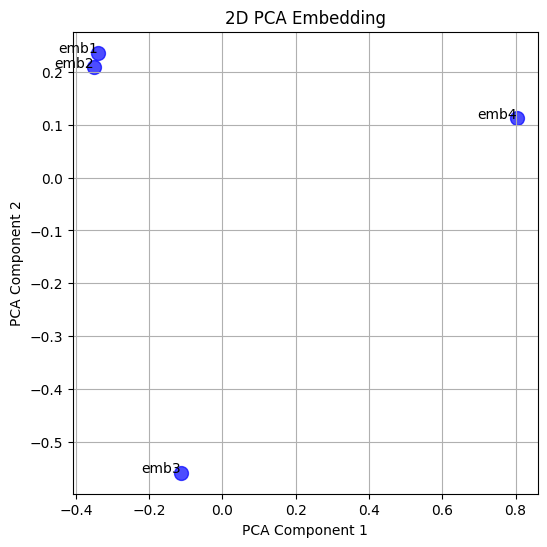

In [25]:
import matplotlib.pyplot as plt

labels = ['emb1', 'emb2', 'emb3', 'emb4']

plt.figure(figsize=(6, 6))
plt.scatter(pca_emb[:, 0], pca_emb[:, 1], s=100, c='blue', alpha=0.7)

for i, label in enumerate(labels):
    plt.annotate(label, (pca_emb[i, 0], pca_emb[i, 1]), fontsize=10, ha='right')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Embedding')
plt.grid(True)
plt.show()

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

sim_kutya_eb = cosine_similarity([emb1], [emb2])[0][0]
sim_kutya_macska = cosine_similarity([emb1], [emb3])[0][0]
sim_eb_macska = cosine_similarity([emb1], [emb3])[0][0]
sim_kutya_varos = cosine_similarity([emb1], [emb4])[0][0]

print(f"'{text1}' ↔ '{text2}': {sim_kutya_eb:.3f}")
print(f"'{text1}' ↔ '{text3}': {sim_kutya_macska:.3f}")
print(f"'{text2}' ↔ '{text3}': {sim_eb_macska:.3f}")
print(f"'{text1}' ↔ '{text4}': {sim_kutya_varos:.3f}")

'dog' ↔ 'hound': 0.756
'dog' ↔ 'cat': 0.603
'hound' ↔ 'cat': 0.603
'dog' ↔ 'city': 0.278


Érdemes mindezt magyarul is kipróbálni, meglepő eredmények fognak születni.

### Szemantikus keresés

In [49]:
dokumentumok = [
   "Python egy programozási nyelv, amit web fejlesztésre használnak",
   "A macska egy kis ragadozó emlős",
   "JavaScript böngészőkben futó szkript nyelv",
   "A kutya az ember legjobb barátja",
   "HTML weblapok készítésének alapja",
   "A teknős lassú mozgású hüllő",
   "CSS a weblapok stílusának meghatározására szolgál",
   "Az elefánt a legnagyobb szárazföldi emlős",
   "React egy JavaScript könyvtár felhasználói felületek építéséhez",
   "A pingvin egy úszó madár"
]

In [50]:
def szemantikus_kereses(kerdes, dokumentumok, top_k=3):
   """Szemantikus keresés dokumentumokban"""
   kerdes_embedding = get_embedding(kerdes)
   eredmenyek = []
   for doc in dokumentumok:
       doc_embedding = get_embedding(doc)
       hasonlosag = cosine_similarity([kerdes_embedding], [doc_embedding])[0][0]
       eredmenyek.append((doc, hasonlosag))
   eredmenyek.sort(key=lambda x: x[1], reverse=True)
   return eredmenyek[:top_k]

In [51]:
keresesek = [
   "programozás és kódolás",
   "állatok és természet", 
   "web technológiák"
]

In [52]:
for kerdes in keresesek:
   print(f"Keresés: '{kerdes}'")
   eredmenyek = szemantikus_kereses(kerdes, dokumentumok)
   
   for i, (doc, pontszam) in enumerate(eredmenyek, 1):
       print(f"{i}. ({pontszam:.3f}) {doc}")
   print("-" * 60)

Keresés: 'programozás és kódolás'
1. (0.505) Python egy programozási nyelv, amit web fejlesztésre használnak
2. (0.432) JavaScript böngészőkben futó szkript nyelv
3. (0.366) HTML weblapok készítésének alapja
------------------------------------------------------------
Keresés: 'állatok és természet'
1. (0.350) A kutya az ember legjobb barátja
2. (0.324) A pingvin egy úszó madár
3. (0.316) Az elefánt a legnagyobb szárazföldi emlős
------------------------------------------------------------
Keresés: 'web technológiák'
1. (0.499) HTML weblapok készítésének alapja
2. (0.465) Python egy programozási nyelv, amit web fejlesztésre használnak
3. (0.425) CSS a weblapok stílusának meghatározására szolgál
------------------------------------------------------------


### Hasonlóság mérése

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock, minkowski
from scipy.stats import pearsonr
import numpy as np

def compare_all_metrics(text1, text2):
    """Compare two texts using multiple similarity metrics"""
    
    emb1 = get_embedding(text1)
    emb2 = get_embedding(text2)

    emb1_np = np.array(emb1)
    emb2_np = np.array(emb2)
    
    results = {}
    
    results['cosine'] = cosine_similarity([emb1], [emb2])[0][0]
    
    results['dot_product'] = np.dot(emb1_np, emb2_np)
    
    eucl_dist = euclidean(emb1_np, emb2_np)
    results['euclidean_distance'] = eucl_dist
    results['euclidean_similarity'] = 1 / (1 + eucl_dist)
    
    manh_dist = cityblock(emb1_np, emb2_np)
    results['manhattan_distance'] = manh_dist
    results['manhattan_similarity'] = 1 / (1 + manh_dist)
    
    results['pearson'] = pearsonr(emb1_np, emb2_np)[0]
    
    mink_dist = minkowski(emb1_np, emb2_np, p=3)
    results['minkowski_similarity'] = 1 / (1 + mink_dist)
    
    return results

test_pairs = [
    ("dogs are the best friend of man", "dogs are always loyal"),
    ("dogs are the best friend of man", "cats like to eat fish"),
    ("dogs are the best friend of man", "the capitol Hungary is Budapest")
]

for text1, text2 in test_pairs:
    print(f"\n=== '{text1}' vs '{text2}' ===")
    metrics = compare_all_metrics(text1, text2)
    
    for metric_name, value in metrics.items():
        print(f"{metric_name:20}: {value:.4f}")


=== 'dogs are the best friend of man' vs 'dogs are always loyal' ===
cosine              : 0.6037
dot_product         : 0.6037
euclidean_distance  : 0.8903
euclidean_similarity: 0.5290
manhattan_distance  : 27.3592
manhattan_similarity: 0.0353
pearson             : 0.6033
minkowski_similarity: 0.7639

=== 'dogs are the best friend of man' vs 'cats like to eat fish' ===
cosine              : 0.1696
dot_product         : 0.1696
euclidean_distance  : 1.2887
euclidean_similarity: 0.4369
manhattan_distance  : 39.7923
manhattan_similarity: 0.0245
pearson             : 0.1694
minkowski_similarity: 0.6896

=== 'dogs are the best friend of man' vs 'the capitol Hungary is Budapest' ===
cosine              : 0.0377
dot_product         : 0.0377
euclidean_distance  : 1.3873
euclidean_similarity: 0.4189
manhattan_distance  : 42.9116
manhattan_similarity: 0.0228
pearson             : 0.0389
minkowski_similarity: 0.6755


Az OpenAI esetében a cosine vagy a dot product a megfelelő választás.

## 10. RAG - Retreival Augmented Generation

A RAG koncepciója nem bonyolult, erre egy egyszerű példán át biztosan megérthető:
- a felhasználó elküld egy kérdés a nagy nyelvi modell felületén
- a kérés nem rögtön a modellhez érkezik, hanem történik egy előfeldolgozás, amely során előállításra kerül a kérés embeddingje
  - ami mint már tudjuk, nagyjából a kérdés jelentését fejezi ki számokkal
- az embedding vektor alapján egy adatbázisban megkeressük a releváns információkat
  - azok a releváns információk, amiknek a vektorai hasonlóak az adatbázisban
  - ez a lépés a RETREIVAL
- a kinyert adatokat hozzáadjuk a felhasználó eredeti kérdéséhez
  - ez a lépés a AUGMENTATION
- az augmentált kérést küldjük el a nyelvi modellnek
  - akinek így meglesz a kérésre vonatkozó releváns információ, így pontosabban tud válaszolni
  - ez a lépés a GENERATION

Miért van erre szükég?
- az LLM-ek tudása korlátos
- speciális tudásra van szükség (mondjuk EOS specifikus tudás)
- ad hoc feldolgozás (pl egy dokumentum feltöltése után az alapján válaszolás)

In [80]:
dokumentumok = [
    "A történet főhőse John Doe.",
    "A főhős kedvenc étele a töltött káposzta.",
    "A gyilkos fekete furgonnal járta az utcákat.",
    "A történet Floridában játszódik.",
    #"A gyilkos kedvenc étterme a Holt Dog."
]
def egyszeru_rag(query, docs, top_k=2):
    query_emb = get_embedding(query)
    sim_list = []
    for doc in docs:
        doc_emb = get_embedding(doc)
        similarity = cosine_similarity([query_emb], [doc_emb])[0][0]
        sim_list.append((doc, similarity))
    sim_list.sort(key=lambda x: x[1], reverse=True)
    relevans = [doc for doc, _ in sim_list[:top_k]]
    context = "\n".join(relevans)
    prompt = f"""Az alábbi információk alapján válaszold meg a kérdést:\n{context}\nKérdés: {query}\nVálasz:"""
    return lm(prompt), relevans, prompt

In [81]:
kerdes = "Mi John Doe kedvenc étele?"
valasz, forrasok, prompt = egyszeru_rag(kerdes, dokumentumok)

In [82]:
print(kerdes)

Mi John Doe kedvenc étele?


In [83]:
print(forrasok)

['A történet főhőse John Doe.', 'A főhős kedvenc étele a töltött káposzta.']


In [84]:
print(prompt)

Az alábbi információk alapján válaszold meg a kérdést:
A történet főhőse John Doe.
A főhős kedvenc étele a töltött káposzta.
Kérdés: Mi John Doe kedvenc étele?
Válasz:


In [85]:
print(valasz[0])

John Doe kedvenc étele a töltött káposzta.


A kikommentelt
- **#"A gyilkos kedvenc étterme a Holt Dog."**

jól mutatja, hogy mi a legnagyobb probléma a RAG-al.

## 11. LLM fine-tuning

A modellek olyan jellegű tanítása, amely során azok súlyait finoman módosítjuk.

Vannak olyan modellek, amelyeknek nyíltak, szabadon elérhetőek a súlyaik (Pl. Llama). Ezeket lehet fine-tuningolni, amely során a súlyokat finoman, kis mértékben módosítjuk. Ezzel azonban több probléma is van:
- Költséges
  - Számítási kapacitás
    - 70B paraméteres modellhez 4-8 A100 GPU (40GB RAM + 4.5M Ft), napokig (5-7) is eltarthat
  - Szakértelem
  - Tárkapacitás
- Adatminőség
  - Tiszta, jól annotált, kiegyensúlyozott tanító adatok kellenek
  - Kellenek adatok a validáláshoz is
- Felejtés: Az eredeti tudás részben elveszhet
- A teljes modell újratanítása csak tech óriásoknak vagy speciális kutatási projekteknek éri meg.

Nem minden cég enged hozzáférést a súlyaihoz, így azok teljes fine-tuningjára vagy nincs lehetőség, vagy csak az általuk biztosított apin keresztül van lehetőség. Az OpenAI GPT-3.5 Turbo-t lehet fine-tuningolni az OpenAI API-n keresztül, de pl. a GPT-4-hez jelenleg nem elérhető fine-tuning (csak nagyobb enterprise partnereknek). Ezek azonban elég költségek megoldások, bár valószínűleg a teljes fine-tuningnál azért olcsóbbak. A fine-tuning során (legalábbis az OpenAI-nál) a modell minden súlyának tanítása történik, ezért ez meglehetősen számításigényes, és több ezer-tízezer tanító adatot igényel, azok előállítása pedig szakértelmet igényel.

A probléma ezekkel az, hogy ha a tanításhoz használt adatok gyorsan változnak, akkor ez egy nagyon-nagyon költséges állandó újratanítási folyamat lesz, sőt az is lehet, hogy nincs lehetőség napokat várni az újratanításra.

Azoknál a modelleknél amelyekhez a fejlesztő hozzáférést enged a súlyokhoz, lehetőség van úgynevezett parameter efficient fine-tuning-ra (PEFT). Ez azt jelenti, hogy nem a modell teljes súly állományát módosítjuk a tanítás során, hanem olyan módszereket használunk amivel annál lényegesen kevesebb paramétert kell fine-tuningolni. Sok ilyen módszer létezik, talán az egyik leggyakoribb a LoRA és a QLoRA.

Ezeknek nagy előnye, hogy
- akár már pár száz (megfelelő minőségű) tanító adattal is el lehet érni a teljes fine-tuningot megközelítő eredményt,
  - "el lehet érni", de ez nagyon feladat függő, lehet, hogy több ezer adat sem lesz elég
- lényegesen kevesebb erőforrást igényelnek (ez a lényegük),
- sokkal kevésbé hajlamosak a túltanulásra, mert csak kevés paramétert tanítunk.

Elsősorban akkor éri meg foglalkozni fine-tuninggal bármilyen formában, ha:
- Rendelkezésre állnak jó minőségű, kiegyensúlyozott tanító és validáló adatok,
- Specifikus stílust/nyelvezetet kell a modellnek követnie,
- Kritikus a pontosság (pl. orvosi diagnózis, jogi dokumentumok)
- Hosszú távban gondolkodás
- Rendelkezésre áll a megfelelő szakértelem

### LoRA - Low-Rank Adaptation

**Klasszikus Fine-tuning**
- W_new = W_original + ΔW
  - ΔW egy teljes méretű súlymátrix

**LoRA**
- ΔW = A × B
  - A = (d × r) matrix
  - B = (r × k) matrix
  - r << d,k (r - "rank")

**Például**
- eredeti súlymátrix: 4096 × 4096 = 16M paraméter
- LoRA (rank 64): (4096 × 64) + (64 × 4096) = 524K parameters
  - 97%-al kevesebb paraméter (nem 97%-a, annyival kevesebb!)

**Működése**
- W_original NEM változik meg
- tanítás során az A és a B mátrixokat kell megtanulni
- output = W_original × input + (A × B) × input
- W_new = W_original + A × B (csak szükség esetén)

**Előnyei**
- két kicsi mátrixot kell csak tárolni, ez hasznos a memória használat szempontjából is és a tárhely szempontjából is
- lehet őket gyorsan cserélhetni: csak az A és B mátrixot le kell cserélni
- lehet több LoRA adaptert használni egyszerre
- az eredeti modell paraméterek megmaradnak változatlanul

PEFT módszerek

| Módszer       | Paraméterigény  | Memóriaigény    | Túltanulási kockázat | Gyorsaság    |
| ------------- | --------------- | --------------- | -------------------- | ------------ |
| LoRA          | Alacsony        | Alacsony        | Alacsony             | Gyors        |
| Adapters      | Alacsony        | Alacsony        | Alacsony             | Gyors        |
| Prompt Tuning | Nagyon alacsony | Minimális       | Közepes              | Nagyon gyors |
| Prefix Tuning | Alacsony        | Alacsony        | Alacsony             | Gyors        |
| QLoRA         | Nagyon alacsony | Nagyon alacsony | Alacsony             | Nagyon gyors |
| IA³           | Extrém alacsony | Minimális       | Alacsony             | Nagyon gyors |

(Infused Adapter by Inhibiting and Amplifying Inner Activations)

In [33]:
import dspy
lm = dspy.LM('ollama_chat/gemma3:1b', api_base='http://localhost:11434', api_key='')
dspy.configure(lm=lm)

In [34]:
lm(messages=[{"role": "user", "content": "Say this is a test!"}])

["Okay! Let's do this. 😊 \n\nLet's see what you've got."]

In [35]:
qa = dspy.Predict('question: str -> response: str')
response = qa(question="what are high memory and low memory on linux?")

print(response.response)

High memory and low memory are a common situation on Linux, often related to how the system manages its memory allocation and caching. Let's break down the key differences:

**High Memory (High RAM):**

*   **What it means:**  The system has a significant amount of RAM available.  It's capable of handling more data and processes simultaneously.
*   **Causes:**
    *   **Large applications:** Running resource-intensive applications (e.g., video editors, games, databases) can consume a lot of RAM.
    *   **Multiple applications running simultaneously:**  More applications running concurrently increase memory demand.
    *   **Large datasets:** Working with large files (e.g., images, videos, spreadsheets) requires more RAM to store the data.
    *   **Memory-intensive operations:**  Tasks like compiling code, running simulations, or complex calculations can be memory-intensive.
*   **Consequences:**
    *   **Slow performance:** If the system runs out of RAM, it starts swapping data to t

In [36]:
dspy.inspect_history(n=1)





[2025-07-23T17:18:46.863620]

System message:

Your input fields are:
1. `question` (str):
Your output fields are:
1. `response` (str):
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## question ## ]]
{question}

[[ ## response ## ]]
{response}

[[ ## completed ## ]]
In adhering to this structure, your objective is: 
        Given the fields `question`, produce the fields `response`.


User message:

[[ ## question ## ]]
what are high memory and low memory on linux?

Respond with the corresponding output fields, starting with the field `[[ ## response ## ]]`, and then ending with the marker for `[[ ## completed ## ]]`.


Response:

```
[[ ## response ## ]]
High memory and low memory are a common situation on Linux, often related to how the system manages its memory allocation and caching. Let's break down the key differences:

**High Memory (High RAM):**

*   **What it means:**  The system has a significant amount of RAM availab

In [37]:
import ujson

with open("ragqa_arena_tech_examples.jsonl") as f:
    data = [ujson.loads(line) for line in f]

In [38]:
data[0]

{'question': 'why igp is used in mpls?',
 'response': "An IGP exchanges routing prefixes between gateways/routers.  \nWithout a routing protocol, you'd have to configure each route on every router and you'd have no dynamic updates when routes change because of link failures. \nFuthermore, within an MPLS network, an IGP is vital for advertising the internal topology and ensuring connectivity for MP-BGP inside the network.",
 'gold_doc_ids': [2822, 2823]}

In [39]:
data = [dspy.Example(**d).with_inputs('question') for d in data]

example = data[2]
example

Example({'question': 'why are my text messages coming up as maybe?', 'response': 'This is part of the Proactivity features new with iOS 9: It looks at info in emails to see if anyone with this number sent you an email and if it finds the phone number associated with a contact from your email, it will show you "Maybe". \n\nHowever, it has been suggested there is a bug in iOS 11.2 that can result in "Maybe" being displayed even when "Find Contacts in Other Apps" is disabled.', 'gold_doc_ids': [3956, 3957, 8034]}) (input_keys={'question'})

In [40]:
cot = dspy.ChainOfThought('question -> response')
cot(question="should curly braces appear on their own line?")

Prediction(
    reasoning="The question asks about the presence of curly braces on their own line.  The prompt implies a specific format, and the current structure doesn't inherently require curly braces to appear on their own line.  The question is about the *presence* of curly braces, not their placement.",
    response="The response should be:\nThe question doesn't specify a particular format for curly braces.  They can appear on their own line if that's the desired style."
)

In [41]:
import random

random.Random(0).shuffle(data)
trainset, devset, testset = data[:200], data[200:500], data[500:1000]

len(trainset), len(devset), len(testset)

(200, 300, 500)

In [42]:
from dspy.evaluate import SemanticF1


metric = SemanticF1(decompositional=True)
pred = cot(**example.inputs())
score = metric(example, pred)

print(f"Question: \t {example.question}\n")
print(f"Gold Response: \t {example.response}\n")
print(f"Predicted Response: \t {pred.response}\n")
print(f"Semantic F1 Score: {score:.2f}")

Question: 	 why are my text messages coming up as maybe?

Gold Response: 	 This is part of the Proactivity features new with iOS 9: It looks at info in emails to see if anyone with this number sent you an email and if it finds the phone number associated with a contact from your email, it will show you "Maybe". 

However, it has been suggested there is a bug in iOS 11.2 that can result in "Maybe" being displayed even when "Find Contacts in Other Apps" is disabled.

Predicted Response: 	 I will send you a text message.

Semantic F1 Score: 0.07


In [43]:
evaluate = dspy.Evaluate(devset=devset, metric=metric, num_threads=1,
                         display_progress=True, display_table=2)

evaluate(cot)

2025/07/23 17:18:47 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 0.81 / 2 (40.7%):   0%|          | 1/300 [00:00<00:09, 32.13it/s]

2025/07/23 17:18:47 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 0.88 / 3 (29.3%):   1%|          | 2/300 [00:00<00:05, 57.38it/s]

2025/07/23 17:18:47 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 2.51 / 5 (50.2%):   1%|▏         | 4/300 [00:00<00:04, 70.21it/s]

Average Metric: 3.51 / 9 (39.0%):   3%|▎         | 9/300 [02:45<1:52:01, 23.10s/it]

2025/07/23 17:22:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 4.51 / 10 (45.1%):   3%|▎         | 10/300 [04:28<3:09:44, 39.26s/it]

2025/07/23 17:23:36 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 4.51 / 11 (41.0%):   4%|▎         | 11/300 [06:07<4:14:06, 52.76s/it]

2025/07/23 17:25:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 4.51 / 12 (37.6%):   4%|▍         | 12/300 [07:45<5:04:55, 63.52s/it]

2025/07/23 17:27:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 7.71 / 16 (48.2%):   5%|▌         | 16/300 [11:39<4:55:19, 62.39s/it]

2025/07/23 17:30:51 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 8.53 / 17 (50.1%):   6%|▌         | 17/300 [13:04<5:25:32, 69.02s/it]

2025/07/23 17:33:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 9.21 / 18 (51.2%):   6%|▌         | 18/300 [15:31<7:10:57, 91.69s/it]

2025/07/23 17:34:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 9.21 / 19 (48.5%):   6%|▋         | 19/300 [16:30<6:25:14, 82.26s/it]

2025/07/23 17:35:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 10.21 / 21 (48.6%):   7%|▋         | 21/300 [18:40<5:49:49, 75.23s/it]

2025/07/23 17:37:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/23 17:38:23 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 10.25 / 22 (46.6%):   7%|▋         | 22/300 [20:10<6:08:37, 79.56s/it]

2025/07/23 17:39:11 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/23 17:39:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 12.25 / 24 (51.0%):   8%|▊         | 24/300 [21:55<4:58:39, 64.93s/it]

2025/07/23 17:41:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 12.94 / 25 (51.7%):   8%|▊         | 25/300 [23:01<4:59:19, 65.31s/it]

2025/07/23 17:42:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 12.94 / 26 (49.8%):   9%|▊         | 26/300 [24:43<5:47:10, 76.03s/it]

2025/07/23 17:44:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.94 / 27 (51.6%):   9%|▉         | 27/300 [26:32<6:31:09, 85.97s/it]

2025/07/23 17:45:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.94 / 30 (46.5%):  10%|█         | 30/300 [28:58<4:40:34, 62.35s/it]

2025/07/23 17:48:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/23 17:48:51 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 14.62 / 31 (47.2%):  10%|█         | 31/300 [30:29<5:18:29, 71.04s/it]

2025/07/23 17:49:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 14.62 / 32 (45.7%):  11%|█         | 32/300 [31:23<4:54:06, 65.85s/it]

2025/07/23 17:50:23 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.59 / 36 (43.3%):  12%|█▏        | 36/300 [34:17<3:34:59, 48.86s/it]

2025/07/23 17:53:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 16.59 / 37 (44.8%):  12%|█▏        | 37/300 [35:06<3:34:31, 48.94s/it]

2025/07/23 17:54:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/23 17:54:37 ERROR dspy.utils.parallelizer: Error for Example({'question': 'how to check whether my intel-based mac is 32-bit or 64-bit', 'response': 'Go to the Apple Menu and select "About this Mac".  \nAlternatively, you can use the arch command without arguments to display the machine\'s architecture type.  \nTo check the kernel version, launch System Profiler (renamed System Information in OS X 10.7) and click on the Software heading.  \nAnother method is to run the command sysctl hw.cpu64bit_capable in a shell, which will indicate if the CPU can run 64-bit programs.  \nIf your MacBook Pro is newer than a 2008 model, it will have a 64-bit processor and OS.  \nYou can also run Activity Monitor and check the Kind column for the kernel_task process to see if it\'s running in 32-bit or 64-bit mode.  \nTo run applications in the correct mode, you can look for

Average Metric: 17.34 / 38 (45.6%):  13%|█▎        | 39/300 [36:34<3:22:17, 46.50s/it]

2025/07/23 17:55:41 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/23 17:55:55 WARNING dspy.utils.parallelizer: SIGINT received. Cancelling.


KeyboardInterrupt: 